In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper 
import torch 
import torchtuples as tt
from pycox.models import DeepHitSingle
from pycox.evaluation import EvalSurv


# Decision Support System

This notebook can be run, all the necessary files are available.



In [2]:
import pickle

with open("data/X_test_run.pkl","rb") as handle:
    X_test=pickle.load(handle)
with open("data/y_test_run.pkl","rb") as handle:
    y_test=pickle.load(handle)



In [3]:
df_test = pd.read_pickle("data/df_test_run.pkl")
info_test = pd.read_pickle("data/info_test_run.pkl")



In [4]:
model = torch.load( "data/final_model.pth")

In [6]:
surv = model.predict_surv_df(X_test)
get_target = lambda df: (df['weeks_on_market'].values.astype("float32"), 
                         df['status'].values.astype("float32"))

durations_test, events_test = get_target(df_test)
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')
c_index = ev.concordance_td()
time_grid = np.linspace(durations_test.min(), durations_test.max(), 90)
i_brier = ev.integrated_brier_score(time_grid)
print("DeepHit performance on the test set")
print("Time Dependent C-Index: {0} and Integrated Brier: {1}".format(c_index,i_brier))

DeepHit performance on the test set
Time Dependent C-Index: 0.6024506852025329 and Integrated Brier: 0.0994199691418685


In [7]:
from lifelines import CoxPHFitter
with open("data/cph_model.pkl","rb") as handle:
    cph=pickle.load(handle)
cph_pred = cph.predict_survival_function(df_test.drop(["expose_price_sqm","object_type_ordinal"], axis=1))
ev_cox = EvalSurv(cph_pred, durations_test, events_test, censor_surv='km')
c_index_cox = ev_cox.concordance_td()

i_brier_cox = ev_cox.integrated_brier_score(time_grid)

print("Cox PH performance on the test set")
print("Time Dependent C-Index: {0} and Integrated Brier: {1}".format(c_index_cox,i_brier_cox))


Cox PH performance on the test set
Time Dependent C-Index: 0.5849102616467344 and Integrated Brier: 0.11480355151368926


# Temporal Component: Overpricer Class

In [10]:
class Overpricer:
    
    def __init__(self, model, data, row):
        self.model = model
        self.data = data
        self.row = row
    
    def build_dataset(self,min_dop=1.0, max_dop=1.1, dop_index=17):
        
        
        dop_list = np.array([max_dop,min_dop])
        overprice_data = np.tile(self.data[self.row,:],(dop_list.shape[0],1))
        overprice_data[:,dop_index] = dop_list
        
        self.dop_list = dop_list
        self.overprice_data = overprice_data
        
    
    def calculate_opportunity(self):
        
        pred = self.model.predict_surv_df(self.data[self.row,:].reshape(1,-1)).iloc[1:]

        median = pred.index[np.argmin(np.abs(pred - 0.5).values,axis=0)[0]].astype(int)
        upper = pred.index[np.argmin(np.abs(pred - 0.25).values,axis=0)[0]].astype(int)
        
        surv = self.model.predict_surv_df(self.overprice_data)
        hazard = surv.diff(-1)/surv
        hazard = hazard.iloc[:upper,:]
        opportunity = (hazard.iloc[:,0] - hazard.iloc[:,1])
        
        self.opportunity = opportunity
        self.median = median
        self.upper = upper
        return([median,upper,surv, hazard,opportunity])
        print("Opportunities are calculated for the property with median survival at ", median, " weeks")
        
    def calculate_liquidity_cost(self):
    
        if np.any(self.opportunity > 0.0):
            market_state = "hot"
            minimum_value = 0.0
            
        else:
            market_state = "cold"
            minimum_value = self.opportunity.mean()
        
        green = np.sum(self.opportunity[:self.median][self.opportunity[:self.median] > minimum_value]-minimum_value)
        red = np.sum(self.opportunity[self.median:][self.opportunity[self.median:] > minimum_value]-minimum_value)
        
        if green == 0.0:
            cost = 1.0
        else:
            cost = red/(red+green)
            
        self.cost = cost
        self.market_state = market_state
        print("Market State: ", market_state,
              "\nLiquidity Cost: ", cost)
        max_idx=np.where(self.opportunity==self.opportunity.max())[0]+1
        week_highest_opportunity = max_idx[0]
        return([market_state,cost,week_highest_opportunity])
    
    def plot_opportunity_curve(self):
        fig,ax=plt.subplots(figsize=(8,5))

        
        x=list(range(1,len(self.opportunity)+1))

        ax.step(x,self.opportunity, color = "black")
        ax.set_title("Opportunity Curve for Property # "+str(self.row))
        max_idx=np.where(self.opportunity==self.opportunity.max())[0]+1
        ax.axvline(max_idx)

        ax.fill_between(x[:self.median],0, self.opportunity.max(), 
                        facecolor='darkgreen', alpha=0.5)
        ax.fill_between(x[self.median-1:],0, self.opportunity.max(),
                        facecolor='darkred', alpha=0.5)
        ax.fill_between(x, self.opportunity.min(),0,
                        facecolor='grey', alpha=0.5)
        ax.legend(['Market State: '+ self.market_state + 
                   "\nLiquidity Cost: " + str(round(self.cost,4)),
                  'Week of Highest Opportunity: '+ str(max_idx[0]),
                  'Expected Week of Sale: ' + str(self.median)], fontsize=15)
        return(ax)
        plt.show()
        
   

In [11]:
row = np.random.choice(X_test.shape[0])
row

14490

Market State:  hot 
Liquidity Cost:  0.5954192


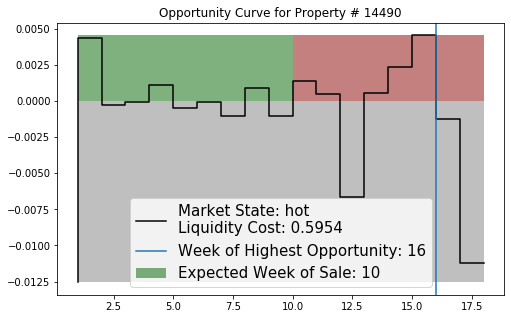

In [12]:
op = Overpricer(model,X_test,row)
op.build_dataset()
stats = op.calculate_opportunity()
costs = op.calculate_liquidity_cost()
op.plot_opportunity_curve()

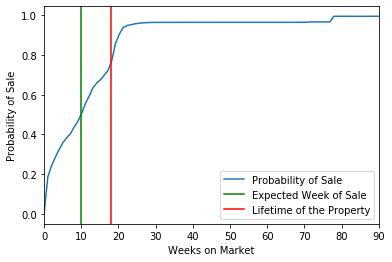

In [13]:
import matplotlib.pyplot as plt
(1-stats[2][0]).plot()
plt.ylabel("Probability of Sale")
plt.xlabel("Weeks on Market")
plt.axvline(stats[0],color="green")
plt.axvline(stats[1],color="red")
plt.legend(["Probability of Sale","Expected Week of Sale","Lifetime of the Property"])
#plt.savefig("presentation_10035_ps.pdf",bbox_inches = "tight")


# Spatial Component: Refine Decisions by SHAP values


Compute the market state, liquidity cost, expected week of sale, and week of highest opportunity for each records in the test data set. Merge the resulting data set with SHAP values which are computed earlier. Find the polygons for the region of choice (here Berlin) and plot the properties which can be overpriced with SHAP values.




In [8]:
market_states_df = pd.read_pickle("data/market_states_df.pkl")

The code below takes about 20 minutes to run. To avoid waiting, the prepared data set is saved and it can be loaded from the cell above. After running the cell above, you can continue inspecting from the section "Apply the Overpricing Heuristic" on.


In [69]:
from tqdm.auto import tqdm

market_states = pd.DataFrame()

for i in tqdm(range(X_test.shape[0])):
    
    
    op = Overpricer(model,X_test,i)
    op.build_dataset()
    stats = op.calculate_opportunity()
    costs = op.calculate_liquidity_cost()
    
    temp = pd.DataFrame([costs[0],costs[1],stats[0], costs[2],stats[1] ]).T
    temp.columns = ["market_state",
                   "liquidity_cost",
                   "week_expected_sale",
                   "week_highest_opportunity",
                   "lifetime"]
                    
    market_states = market_states.append(temp)



Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.20898883
Market State:  hot 
Liquidity Cost:  0.04204501
Market State:  hot 
Liquidity Cost:  0.0
Market State:  cold 
Liquidity Cost:  0.7107447
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.99420494
Market State:  hot 
Liquidity Cost:  0.9120516
Market State:  hot 
Liquidity Cost:  0.57333577
Market State:  hot 
Liquidity Cost:  0.54556936
Market State:  hot 
Liquidity Cost:  0.90007526
Market State:  hot 
Liquidity Cost:  0.39561522
Market State:  cold 
Liquidity Cost:  0.942725
Market State:  hot 
Liquidity Cost:  0.21774058
Market State:  hot 
Liquidity Cost:  0.8490933
Market State:  cold 
Liquidity Cost:  0.7675758
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.58937365
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.70822304
Market State:  hot 
Liquidity Cost:

Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.13785271
Market State:  cold 
Liquidity Cost:  0.9572727
Market State:  hot 
Liquidity Cost:  0.8458889
Market State:  hot 
Liquidity Cost:  0.8982946
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.9288175
Market State:  hot 
Liquidity Cost:  0.7877131
Market State:  hot 
Liquidity Cost:  0.57769424
Market State:  hot 
Liquidity Cost:  0.30252522
Market State:  hot 
Liquidity Cost:  0.5265388
Market State:  hot 
Liquidity Cost:  0.65878546
Market State:  hot 
Liquidity Cost:  0.77225393
Market State:  hot 
Liquidity Cost:  0.18287688
Market State:  hot 
Liquidity Cost:  0.26323
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.6660788
Market State:  hot 
Liquidity Cost:  0.6256186
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.8595878
Market State:  hot 
Liquidity Cost:  0.62733215
Market State:  hot 
Liquidity 

Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.463911
Market State:  hot 
Liquidity Cost:  0.45551616
Market State:  hot 
Liquidity Cost:  0.9948931
Market State:  hot 
Liquidity Cost:  0.44564712
Market State:  hot 
Liquidity Cost:  0.44816107
Market State:  hot 
Liquidity Cost:  0.48879918
Market State:  cold 
Liquidity Cost:  0.9067582
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.25221133
Market State:  hot 
Liquidity Cost:  0.27621877
Market State:  hot 
Liquidity Cost:  0.5627353
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.9062164
Market State:  hot 
Liquidity Cost:  0.74169755
Market State:  hot 
Liquidity Cost:  0.800157
Market State:  cold 
Liquidity Cost:  0.98520285
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.083273046
Market State:  hot 
Liquidity Cost:  0.6341975
Market State:  cold 
Liquidity Cost:  0.4622069
Market State:  cold 
Liqu

Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.51976734
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.6727358
Market State:  cold 
Liquidity Cost:  0.6308213
Market State:  cold 
Liquidity Cost:  0.89099145
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.36166024
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.44656324
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.89936876
Market State:  hot 
Liquidity Cost:  0.8508067
Market State:  hot 
Liquidity Cost:  0.2637467
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.72253317
Market State:  cold 
Liquidity Cost:  0.88884604
Market State:  hot 
L

Market State:  hot 
Liquidity Cost:  0.2939195
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.3122295
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.3900992
Market State:  hot 
Liquidity Cost:  0.8895816
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.5602833
Market State:  hot 
Liquidity Cost:  0.33980355
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.84543365
Market State:  hot 
Liquidity Cost:  0.41294417
Market State:  hot 
Liquidity Cost:  0.83547693
Market State:  hot 
Liquidity Cost:  0.42075697
Market State:  hot 
Liquidity Cost:  0.9982174
Market State:  hot 
Liquidity Cost:  0.96262705
Market State:  hot 
Liquidity Cost:  0.13198353
Market State:  hot 
Liquidity Cost:  0.03626069
Market State:  hot 
Liquidity Cost:  0.9399673
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0


Market State:  hot 
Liquidity Cost:  0.0868866
Market State:  hot 
Liquidity Cost:  0.6596468
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  5.0869867e-06
Market State:  hot 
Liquidity Cost:  0.7531174
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.6859482
Market State:  hot 
Liquidity Cost:  0.40612
Market State:  hot 
Liquidity Cost:  0.7216348
Market State:  hot 
Liquidity Cost:  0.38018042
Market State:  hot 
Liquidity Cost:  0.8923584
Market State:  hot 
Liquidity Cost:  0.21037374
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.56224185
Market State:  hot 
Liquidity Cost:  0.9244313
Market State:  hot 
Liquidity Cost:  0.8968894
Market State:  cold 
Liquidity Cost:  0.77991366
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.1951766
Market State:  hot 
Liquidity Cost:  0.11

Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.91873807
Market State:  hot 
Liquidity Cost:  0.11791852
Market State:  cold 
Liquidity Cost:  0.86689234
Market State:  hot 
Liquidity Cost:  0.54195046
Market State:  hot 
Liquidity Cost:  0.7801012
Market State:  hot 
Liquidity Cost:  0.36379263
Market State:  hot 
Liquidity Cost:  0.6497533
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.88971144
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.50837886
Market State:  hot 
Liquidity Cost:  0.27669647
Market State:  hot 
Liquidity Cost:  0.6440885
Market State:  hot 
Liquidity Cost:  0.47969142
Market State:  cold 
Liquidity Cost:  0.70624167
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.74020886
Market State:  cold 
Liquidity Cost:  0.96512383
Market State:  hot 
Liquidity Cost

Market State:  hot 
Liquidity Cost:  0.83304024
Market State:  hot 
Liquidity Cost:  0.9161839
Market State:  cold 
Liquidity Cost:  0.9832457
Market State:  hot 
Liquidity Cost:  0.45769587
Market State:  hot 
Liquidity Cost:  0.31471354
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.48309964
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.8506524
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.5864997
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.13107136
Market State:  hot 
Liquidity Cost:  0.35332254
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.8361944
Market State:  cold 
Liquidity Cost:  0.556111
Market State:  hot 
Liquidity Cost:  0.50771815
Market State:  hot 
Liquidity Cost:  0.44993225
Market State:  hot 
Liquidity Cost:  0.0054064076
Market State:  hot 
Liquidity Cost:

Market State:  hot 
Liquidity Cost:  0.6619741
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.9810615
Market State:  hot 
Liquidity Cost:  0.882229
Market State:  hot 
Liquidity Cost:  0.3669083
Market State:  hot 
Liquidity Cost:  0.7496145
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.78347665
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.18588017
Market State:  hot 
Liquidity Cost:  0.992406
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.6621141
Market State:  hot 
Liquidity Cost:  4.100209e-05
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.8323313
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.37248534
Market State:  hot 
Liquidity Cost:  0.50607014
Market State:  hot 
Liquidity Cost:  0.0
Market State:

Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.9525601
Market State:  hot 
Liquidity Cost:  0.42537227
Market State:  cold 
Liquidity Cost:  0.63837236
Market State:  hot 
Liquidity Cost:  0.6175594
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.57159615
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.90734535
Market State:  hot 
Liquidity Cost:  0.8519545
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.809623
Market State:  hot 
Liquidity Cost:  0.7118225
Market State:  hot 
Liquidity Cost:  0.7740246
Market State:  hot 
Liquidity Cost:  0.9878962
Market State:  hot 
Liquidity Cost:  0.60353
Market State:  hot 
Liquidity Cost:  0.84013844
Market State:  

Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.76903325
Market State:  cold 
Liquidity Cost:  0.9027149
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.7693454
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.4813493
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.49170598
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.7673578
Market State:  hot 
Liquidity Cost:  0.81051236
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.9566546
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.90132815
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.48097268
Market State:  hot 
Liquidity Cost:  0.7075728
Market State:  hot 
Liquidity Cost:  0.2003637
Market State:  cold 
Liquidity Cost:  0.94499993
Market State

Market State:  hot 
Liquidity Cost:  0.71915495
Market State:  hot 
Liquidity Cost:  0.6231346
Market State:  hot 
Liquidity Cost:  0.0
Market State:  cold 
Liquidity Cost:  0.89625806
Market State:  hot 
Liquidity Cost:  0.23439252
Market State:  hot 
Liquidity Cost:  0.55994004
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.8490862
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.7788863
Market State:  hot 
Liquidity Cost:  0.71967447
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.6174809
Market State:  hot 
Liquidity Cost:  0.33054182
Market State:  hot 
Liquidity Cost:  0.93710613
Market State:  cold 
Liquidity Cost:  0.8899412
Market State:  hot 
Liquidity Cost:  0.94327694
Market State:  hot 
Liquidity Cost:  0.6555849
Market State:  hot 
Liquidity Cost:  0.6981172
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  

Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.93761855
Market State:  hot 
Liquidity Cost:  0.71642613
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.33479387
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.6557815
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.51693565
Market State:  cold 
Liquidity Cost:  0.79208654
Market State:  hot 
Liquidity Cost:  0.5994984
Market State:  hot 
Liquidity Cost:  0.05687331
Market State:  hot 
Liquidity Cost:  0.0
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.75778335
Market State:  hot 
Liquidity Cost:  0.63871324
Market State:  hot 
Liquidity Cost:  0.6987599
Market State:  hot 
Liquidity Cost:  0.4494263
Market State:  hot 
Liquidity Cost:  0.1836498
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.9832343
Market State:  cold 
Liquidity Cost:  1.0
Ma

Market State:  hot 
Liquidity Cost:  0.96122247
Market State:  hot 
Liquidity Cost:  0.01132577
Market State:  hot 
Liquidity Cost:  0.88236445
Market State:  hot 
Liquidity Cost:  0.28705359
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.094588175
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.12770867
Market State:  hot 
Liquidity Cost:  0.9720974
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.6784087
Market State:  hot 
Liquidity Cost:  0.66757756
Market State:  hot 
Liquidity Cost:  0.94888824
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.57822025
Market State:  hot 
Liquidity Cost:  0.3241979
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.10097372
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.88693243
Ma

Market State:  hot 
Liquidity Cost:  0.39483646
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.8091763
Market State:  cold 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.9017882
Market State:  cold 
Liquidity Cost:  0.39523196
Market State:  hot 
Liquidity Cost:  0.97388077
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.97270334
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.87224466
Market State:  hot 
Liquidity Cost:  0.7267186
Market State:  hot 
Liquidity Cost:  0.9764507
Market State:  hot 
Liquidity Cost:  0.8017655
Market State:  hot 
Liquidity Cost:  0.32962403
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.7601883
Market State:  hot 
Liquidity Cost:  0.5093403
Market State:  hot 
Liquidity Cost:  0.5256469
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.57873833
Market State:  hot 
Liquidity Cost:  

Market State:  hot 
Liquidity Cost:  0.6813559
Market State:  hot 
Liquidity Cost:  0.36761567
Market State:  hot 
Liquidity Cost:  0.42460132
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.8314584
Market State:  hot 
Liquidity Cost:  0.96622413
Market State:  hot 
Liquidity Cost:  0.7262145
Market State:  hot 
Liquidity Cost:  0.106676035
Market State:  hot 
Liquidity Cost:  0.7220849
Market State:  hot 
Liquidity Cost:  0.9152325
Market State:  cold 
Liquidity Cost:  0.35032135
Market State:  hot 
Liquidity Cost:  0.70861506
Market State:  hot 
Liquidity Cost:  0.46540824
Market State:  cold 
Liquidity Cost:  0.29611588
Market State:  hot 
Liquidity Cost:  0.18696788
Market State:  hot 
Liquidity Cost:  0.9780635
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.4949913
Market State:  hot 
Liquidity 

Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.0939651
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.99280804
Market State:  hot 
Liquidity Cost:  0.8180944
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.8268056
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.17740093
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.65801096
Market State:  hot 
Liquidity Cost:  0.72020704
Market State:  hot 
Liquidity Cost:  0.95033646
Market State:  cold 
Liquidity Cost:  0.9656521
Market State:  hot 
Liquidity Cost:  0.5671171
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.18221787
Market State:  hot 
Liquidity Cost:  0.8685718
Market State:  hot 
Liquidity Cost:  0.05607259
Market State:  cold 
Liquidity Cost:  0.82525605
Market State:  hot 
Liquidity Cost:  0.12280

Market State:  hot 
Liquidity Cost:  0.8052754
Market State:  cold 
Liquidity Cost:  0.5849286
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.2320073
Market State:  hot 
Liquidity Cost:  0.76732606
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.2526524
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.6153493
Market State:  hot 
Liquidity Cost:  0.379636
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.3688984
Market State:  hot 
Liquidity Cost:  0.28947383
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.991465
Market State:  hot 
Liquidity Cost:  0.07455908
Market State:  cold 
Liquidity Cost:  0.81046075
Market State:  cold 
Liquidity Cost:  0.8265252
Market State:  hot 
Liquidity Cost:  0.5905631
Market State:  hot 
Liquidity Cost:  1.0
Market S

Market State:  hot 
Liquidity Cost:  0.9655647
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.9049507
Market State:  hot 
Liquidity Cost:  0.7333745
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.631087
Market State:  hot 
Liquidity Cost:  0.77018666
Market State:  hot 
Liquidity Cost:  0.5964729
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.88020396
Market State:  hot 
Liquidity Cost:  0.631726
Market State:  hot 
Liquidity Cost:  0.45292246
Market State:  hot 
Liquidity Cost:  0.8797279
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.8568526
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.5418584
Market State:  hot 
Liquidity Cost:  0.83942944
Market State:  cold 
Liquidity Cost:  0.44548485
Market State:  hot 
Liquidity Cost:  0.3628094
Mark

Market State:  hot 
Liquidity Cost:  0.865485
Market State:  hot 
Liquidity Cost:  0.39027315
Market State:  hot 
Liquidity Cost:  0.7018292
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.8133377
Market State:  hot 
Liquidity Cost:  0.35872635
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.48060828
Market State:  hot 
Liquidity Cost:  0.5445629
Market State:  hot 
Liquidity Cost:  0.9081503
Market State:  hot 
Liquidity Cost:  0.39326608
Market State:  hot 
Liquidity Cost:  0.80355227
Market State:  hot 
Liquidity Cost:  0.47118565
Market State:  hot 
Liquidity Cost:  0.73311204
Market State:  hot 
Liquidity Cost:  0.28482178
Market State:  hot 
Liquidity Cost:  0.12798342
Market State:  hot 
Liquidity Cost:  0.97312033
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.41203928
Market State:  cold 
Liquidity Cost:  0.9233706
Market State:  hot 
Liqui

Market State:  hot 
Liquidity Cost:  0.893093
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.86250424
Market State:  hot 
Liquidity Cost:  0.35691258
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.89717
Market State:  hot 
Liquidity Cost:  0.0
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.0
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.47899136
Market State:  hot 
Liquidity Cost:  0.84186876
Market State:  hot 
Liquidity Cost:  0.86425555
Market State:  hot 
Liquidity Cost:  0.60498786
Market State:  cold 
Liquidity Cost:  0.9471382
Market State:  cold 
Liquidity Cost:  0.817763
Market State:  hot 
Liquidity Cost:  0.5553334
Market State:  hot 
Liquidity Cost:  0.71262324
Market State:  hot 
Liquidity Cost:  0.5599871
Market State:

Market State:  hot 
Liquidity Cost:  0.93031883
Market State:  hot 
Liquidity Cost:  0.81173366
Market State:  hot 
Liquidity Cost:  0.99118596
Market State:  hot 
Liquidity Cost:  0.5752225
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.40290362
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.5427367
Market State:  hot 
Liquidity Cost:  0.94407505
Market State:  hot 
Liquidity Cost:  0.7206293
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.0
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.875229
Market State:  cold 
Liquidity Cost:  0.4762155
Market State:  hot 
Liquidity Cost:  0.44554818
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.8167899
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot

Market State:  hot 
Liquidity Cost:  0.9229044
Market State:  hot 
Liquidity Cost:  0.8167706
Market State:  hot 
Liquidity Cost:  0.49074548
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.5028196
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.93183583
Market State:  hot 
Liquidity Cost:  0.41393715
Market State:  hot 
Liquidity Cost:  0.7457835
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.6426596
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.7585438
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.6043239
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.7291979
Market State:  cold 
Liquidity Cost:  0.54662365
Market State:  hot 


Market State:  hot 
Liquidity Cost:  0.5609885
Market State:  hot 
Liquidity Cost:  0.6609868
Market State:  cold 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.89794755
Market State:  hot 
Liquidity Cost:  0.6867573
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.71639943
Market State:  hot 
Liquidity Cost:  0.2761096
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.01423358
Market State:  hot 
Liquidity Cost:  0.8888461
Market State:  hot 
Liquidity Cost:  0.47928312
Market State:  hot 
Liquidity Cost:  0.016367095
Market State:  hot 
Liquidity Cost:  0.88931566
Market State:  cold 
Liquidity Cost:  0.55585986
Market State:  hot 
Liquidity Cost:  0.060835037
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.21075487
Market State:  hot 
Liquidity Cost:  0.27369267
Market State:  hot 
Liquidity Cost

Market State:  hot 
Liquidity Cost:  0.57626575
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.8329623
Market State:  hot 
Liquidity Cost:  0.36512575
Market State:  hot 
Liquidity Cost:  0.95227355
Market State:  cold 
Liquidity Cost:  0.908066
Market State:  cold 
Liquidity Cost:  0.92486334
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.69499
Market State:  hot 
Liquidity Cost:  0.15271191
Market State:  hot 
Liquidity Cost:  0.48785487
Market State:  hot 
Liquidity Cost:  0.06449976
Market State:  hot 
Liquidity Cost:  0.7958659
Market State:  hot 
Liquidity Cost:  0.93769175
Market State:  hot 
Liquidity Cost:  0.3874414
Market State:  hot 
Liquidity Cost:  0.46971765
Market State:  hot 
Liquidity Cost:  0.26568925
Market State:  hot 
Liquidity Cost:  

Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.8910902
Market State:  hot 
Liquidity Cost:  0.8947446
Market State:  hot 
Liquidity Cost:  0.64084923
Market State:  hot 
Liquidity Cost:  0.79290456
Market State:  hot 
Liquidity Cost:  0.4207558
Market State:  hot 
Liquidity Cost:  0.67185795
Market State:  cold 
Liquidity Cost:  0.693825
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.77970654
Market State:  cold 
Liquidity Cost:  0.86068594
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.3382487
Market State:  hot 
Liquidity Cost:  0.093018055
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.28698906
Market State:  hot 
Liquidity Cost:  0.71581984
Market State:  hot 
Liquidity Cost:  0.06406441
Market State:  hot 
Liquidity Cost:  0.74506605
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.629316
Market State:  cold 
Liquidit

Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.9756188
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.056546308
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.012293063
Market State:  hot 
Liquidity Cost:  0.5427382
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.27857277
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.06506357
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.6971498
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.96040463
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.5743097
Market State:  cold 
Liquidity Cost:  0.941688
Market State:  hot 
Liquidity 

Market State:  cold 
Liquidity Cost:  0.72286654
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.67181087
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.74256736
Market State:  cold 
Liquidity Cost:  0.5267241
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.81013894
Market State:  hot 
Liquidity Cost:  0.6958415
Market State:  hot 
Liquidity Cost:  0.8920573
Market State:  hot 
Liquidity Cost:  0.6504993
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.23329161
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.029531108
Market State:  hot 
Liquidity Cost:  0.3633768
Market State:  hot 
Liquidity Cost:  0.9047095
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.74962413
Market State:  cold 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.7497945

Market State:  hot 
Liquidity Cost:  0.84948176
Market State:  hot 
Liquidity Cost:  0.91800237
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.0
Market State:  cold 
Liquidity Cost:  0.99707425
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.4261399
Market State:  cold 
Liquidity Cost:  0.058602165
Market State:  hot 
Liquidity Cost:  0.45468307
Market State:  hot 
Liquidity Cost:  0.9611823
Market State:  hot 
Liquidity Cost:  0.7819055
Market State:  cold 
Liquidity Cost:  0.86132497
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.59245145
Market State:  hot 
Liquidity Cost:  0.5165903
Market State:  hot 
Liquidity Cost:  0.648955
Market State:  hot 
Liquidity Cost:  0.18208775
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.174757
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.66038406
Market State:  hot 
Liquidity Cost: 

Market State:  hot 
Liquidity Cost:  0.8203059
Market State:  hot 
Liquidity Cost:  0.7347502
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.83192104
Market State:  hot 
Liquidity Cost:  0.39784715
Market State:  hot 
Liquidity Cost:  0.5815238
Market State:  hot 
Liquidity Cost:  0.5973577
Market State:  cold 
Liquidity Cost:  0.92126244
Market State:  hot 
Liquidity Cost:  0.14214171
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.92686534
Market State:  hot 
Liquidity Cost:  0.96943283
Market State:  hot 
Liquidity Cost:  0.49351647
Market State:  hot 
Liquidity Cost:  0.6144375
Market State:  hot 
Liquidity Cost:  0.82348365
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.9633081
Market State:  hot 
Liquidity Cost:  0.01888218
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.

Market State:  hot 
Liquidity Cost:  0.9009293
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.6209359
Market State:  hot 
Liquidity Cost:  0.7868703
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.72055465
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.98017895
Market State:  cold 
Liquidity Cost:  0.9104932
Market State:  hot 
Liquidity Cost:  0.6404559
Market State:  hot 
Liquidity Cost:  0.38407832
Market State:  hot 
Liquidity Cost:  0.67285305
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.97191834
Market State:  hot 
Liquidity Cost:  0.4467455
Market State:  hot 
Liquidity Cost:  0.9545647
Market State:  hot 
Liquidity Cost:  0.5591768
Market State:  cold 
Liquidity Cost:  0.843718
Market

Market State:  hot 
Liquidity Cost:  0.13402253
Market State:  cold 
Liquidity Cost:  0.8851268
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.6230558
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.72413296
Market State:  hot 
Liquidity Cost:  0.37192455
Market State:  hot 
Liquidity Cost:  0.30253264
Market State:  hot 
Liquidity Cost:  0.21236347
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.44154322
Market State:  hot 
Liquidity Cost:  0.8644768
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.2554299
Market State:  hot 
Liquidity Cost:  0.48477957
Market State:  cold 
Liquidity Cost:  0.94163877
Market State:  hot 
Liquidity Cost:  0.91942537
Market State:  cold 
Liquidity Cost:  0.8779578
Market State:  hot 
Liquidity Cost:  0.7963887
Market State:  hot 
Liquidity Cost:  

Market State:  hot 
Liquidity Cost:  0.23114611
Market State:  hot 
Liquidity Cost:  0.6322612
Market State:  cold 
Liquidity Cost:  0.38523445
Market State:  hot 
Liquidity Cost:  0.64005727
Market State:  hot 
Liquidity Cost:  0.9613194
Market State:  cold 
Liquidity Cost:  0.9327052
Market State:  hot 
Liquidity Cost:  0.6677881
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.39775994
Market State:  cold 
Liquidity Cost:  0.71861887
Market State:  hot 
Liquidity Cost:  0.72654736
Market State:  hot 
Liquidity Cost:  0.96569175
Market State:  hot 
Liquidity Cost:  0.9566753
Market State:  cold 
Liquidity Cost:  0.78448325
Market State:  hot 
Liquidity Cost:  0.96370846
Market State:  hot 
Liquidity Cost:  0.40910915
Market State:  hot 
Liquidity Cost:  0.5152738
Market State:  hot 
Liquidity Cost:  0.86670804
Market State:  hot 
Liquidity Cost:  0.44088286
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.39214423
Market 

Market State:  hot 
Liquidity Cost:  0.41992706
Market State:  hot 
Liquidity Cost:  0.1820562
Market State:  cold 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.79991084
Market State:  hot 
Liquidity Cost:  0.9539569
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.58221126
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.87947494
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.6715934
Market State:  hot 
Liquidity Cost:  0.7003174
Market State:  hot 
Liquidity Cost:  0.77885073
Market State:  hot 
Liquidity Cost:  0.6410096
Market State:  hot 
Liquidity Cost:  0.17334403
Market State:  hot 
Liquidity Cost:  0.7882883
Market State:  hot 
Liquidity Cost:  0.6994999
Market State:  hot 
Liquidity Cost:  1.0
Market State

Market State:  hot 
Liquidity Cost:  0.40672678
Market State:  hot 
Liquidity Cost:  0.36491022
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.6835719
Market State:  cold 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.16342263
Market State:  hot 
Liquidity Cost:  0.19973166
Market State:  hot 
Liquidity Cost:  0.78838676
Market State:  hot 
Liquidity Cost:  0.668646
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.6583938
Market State:  hot 
Liquidity Cost:  0.84304893
Market State:  hot 
Liquidity Cost:  0.7774682
Market State:  hot 
Liquidity Cost:  0.52707773
Market State:  hot 
Liquidity Cost:  0.05282226
Market State:  hot 
Liquidity Cost:  0.7067428
Market State:  hot 
Liquidity Cost:  0.8535373
Market State:  cold 
Liquidity Cost:  0.62337697
Market State:  cold 
Liquidity Cost:  0.7544217
Market State:  hot 
Liquidity Cost:  0.93179864
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liqu

Market State:  hot 
Liquidity Cost:  0.7514456
Market State:  hot 
Liquidity Cost:  0.5028927
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.4131017
Market State:  hot 
Liquidity Cost:  0.4657232
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.6566706
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.5962737
Market State:  hot 
Liquidity Cost:  0.8803024
Market State:  hot 
Liquidity Cost:  0.87002736
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.55668753
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.09797894
Market State:  hot 
Liquidity Cost:  0.6370918
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.6207194
Market State:  hot 
Liquidity Cost:  0.16908851
Market State:  hot 
Liquidity Cost:  0.7807484
Market St

Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.29661644
Market State:  cold 
Liquidity Cost:  0.99183077
Market State:  hot 
Liquidity Cost:  0.050207578
Market State:  cold 
Liquidity Cost:  0.11165972
Market State:  cold 
Liquidity Cost:  0.51244724
Market State:  cold 
Liquidity Cost:  0.7170655
Market State:  hot 
Liquidity Cost:  0.9296641
Market State:  cold 
Liquidity Cost:  0.8070404
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.9047278
Market State:  cold 
Liquidity Cost:  0.90240324
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.5019973
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.38087997
Market State:  cold 
Liquidity Cost:  0.16707617
Market State:  hot 
Liquidity Cost:  0.8235267
Market State:  hot 
Liquidity Cost:  0.5057017
Market State:  cold 
Liquidity Cost:  0.916909
Market State:  hot 
Liquidity Cost:  0.99214315
Market State:  hot

Market State:  cold 
Liquidity Cost:  0.87602353
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.73542583
Market State:  hot 
Liquidity Cost:  0.12320141
Market State:  hot 
Liquidity Cost:  0.80847543
Market State:  hot 
Liquidity Cost:  0.46148187
Market State:  hot 
Liquidity Cost:  0.5263836
Market State:  hot 
Liquidity Cost:  0.9052959
Market State:  cold 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.657688
Market State:  hot 
Liquidity Cost:  0.9176317
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.8421245
Market State:  hot 
Liquidity Cost:  0.32576767
Market State:  cold 
Liquidity Cost:  0.8237052
Market State:  hot 
Liquidity Cost:  0.8454882
Market State:  hot 
Liquidity Cost:  0.6174036
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.79942

Market State:  hot 
Liquidity Cost:  0.6197745
Market State:  hot 
Liquidity Cost:  0.38518026
Market State:  cold 
Liquidity Cost:  0.8046319
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.24087715
Market State:  hot 
Liquidity Cost:  0.8175513
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.365221
Market State:  hot 
Liquidity Cost:  0.6492816
Market State:  hot 
Liquidity Cost:  0.08299054
Market State:  cold 
Liquidity Cost:  0.19174458
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.20625503
Market State:  cold 
Liquidity Cost:  0.8846185
Market State:  hot 
Liquidity Cost:  0.55841506
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.9734555
Market State:  hot 
Liquidity Cost:  0.0
Market State:  cold 
Liquidity Cost:  0.75821406
Mar

Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.93297225
Market State:  cold 
Liquidity Cost:  0.78589416
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.871288
Market State:  hot 
Liquidity Cost:  0.34340551
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.69232714
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.6206205
Market State:  hot 
Liquidity Cost:  0.31823656
Market State:  hot 
Liquidity Cost:  0.73958033
Market State:  hot 
Liquidity Cost:  0.063301705
Market State:  hot 
Liquidity Cost:  0.52415097
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.91382504
Market State:  hot 
Liquidity Cost:  0.7780249
Market State:  cold 
Liquidity Cost:  0.67691857
Market State:  hot 
Liquidity Cost:  0.976989
Market State:  hot 
Liquidity Cost:  0.48390123
Market State:  hot 
Liquidity Cost:  0.49774814
Market State:  hot 
Liquidit

Market State:  cold 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.7486355
Market State:  hot 
Liquidity Cost:  0.1404618
Market State:  hot 
Liquidity Cost:  0.98788613
Market State:  cold 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.7280713
Market State:  hot 
Liquidity Cost:  0.81287867
Market State:  hot 
Liquidity Cost:  0.14175215
Market State:  cold 
Liquidity Cost:  0.7356077
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.92503154
Market State:  hot 
Liquidity Cost:  0.8961226
Market State:  hot 
Liquidity Cost:  0.89932007
Market State:  hot 
Liquidity Cost:  0.73048955
Market State:  hot 
Liquidity Cost:  0.030943546
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.33002993
Market State:  cold 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.8920052
Market State:  hot 
Liquidity Cost:  0.56431675
Market State:  hot 
Liquidity Co

Market State:  cold 
Liquidity Cost:  0.99255073
Market State:  hot 
Liquidity Cost:  0.54372174
Market State:  cold 
Liquidity Cost:  0.85503393
Market State:  cold 
Liquidity Cost:  0.82082313
Market State:  hot 
Liquidity Cost:  0.9080544
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.48708278
Market State:  hot 
Liquidity Cost:  0.9575676
Market State:  cold 
Liquidity Cost:  0.96459866
Market State:  hot 
Liquidity Cost:  0.58231515
Market State:  hot 
Liquidity Cost:  0.8715
Market State:  cold 
Liquidity Cost:  0.93135226
Market State:  hot 
Liquidity Cost:  0.70815665
Market State:  cold 
Liquidity Cost:  0.739511
Market State:  hot 
Liquidity Cost:  0.9119794
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.106960826
Market State:  hot 
Liquidity Cost:  0.44957387
Market State:  cold 
Liquidity Cost:  0.9650981
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.4069831
Market State: 

Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.8649149
Market State:  hot 
Liquidity Cost:  0.9846689
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.4922987
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.3357462
Market State:  cold 
Liquidity Cost:  0.7440156
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.6175238
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.2857619
Market State:  hot 
Liquidity Cost:  0.7105945
Market State:  hot 
Liquidity Cost:  0.4004755
Market State:  hot 
Liquidity Cost:  0.37104967
Market State:  cold 
Liquidity Cost:  0.9907852
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.39577717
Market State:  hot 
Liquidity Cost:  0.25623286
Market State:  hot 
Liquidity Cost:  0.8003614
Market S

Market State:  hot 
Liquidity Cost:  0.0
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.46677747
Market State:  cold 
Liquidity Cost:  0.7411393
Market State:  hot 
Liquidity Cost:  0.36694324
Market State:  hot 
Liquidity Cost:  0.8908698
Market State:  cold 
Liquidity Cost:  0.97612906
Market State:  cold 
Liquidity Cost:  0.7680493
Market State:  hot 
Liquidity Cost:  0.48160073
Market State:  cold 
Liquidity Cost:  0.9256798
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.62385446
Market State:  cold 
Liquidity Cost:  0.6281674
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.6750944
Market State:  hot 
Liquidity Cost:  0.685407
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.61262596
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.76859313
Market State:  cold 
Liquidity Cost:  0.92

Market State:  hot 
Liquidity Cost:  0.6028848
Market State:  hot 
Liquidity Cost:  0.66630566
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.17522039
Market State:  cold 
Liquidity Cost:  0.94397867
Market State:  hot 
Liquidity Cost:  0.8881134
Market State:  cold 
Liquidity Cost:  0.86579967
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.77784246
Market State:  hot 
Liquidity Cost:  0.83773667
Market State:  hot 
Liquidity Cost:  0.5295421
Market State:  hot 
Liquidity Cost:  0.42994553
Market State:  hot 
Liquidity Cost:  0.24995902
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.57893443
Market State:  hot 
Liquidity Cost:  0.81339556
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.9391395
Market State:  hot 
Liquidity Cost:  1.0

Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.17338142
Market State:  cold 
Liquidity Cost:  0.7370153
Market State:  hot 
Liquidity Cost:  0.5716573
Market State:  hot 
Liquidity Cost:  0.7880044
Market State:  hot 
Liquidity Cost:  0.97252285
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.96868646
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.7010528
Market State:  hot 
Liquidity Cost:  0.13625258
Market State:  hot 
Liquidity Cost:  0.5050297
Market State:  hot 
Liquidity Cost:  0.49857673
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.71782273
Market State:  hot 
Liquidity Cost:  0.8092775
Market State:  hot 
Liquidity Cost:  0.92058337
Market State:  hot 
Liquidity Cost:  0.76759535
Market State:  hot 
Liquidity Cost:  0.1749791
Market State:  hot 
Liquidity Cost:  0.

Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.5733861
Market State:  hot 
Liquidity Cost:  0.47207183
Market State:  hot 
Liquidity Cost:  0.709484
Market State:  cold 
Liquidity Cost:  0.54847986
Market State:  hot 
Liquidity Cost:  0.73333573
Market State:  hot 
Liquidity Cost:  0.13237993
Market State:  hot 
Liquidity Cost:  0.5281269
Market State:  hot 
Liquidity Cost:  0.44675055
Market State:  hot 
Liquidity Cost:  0.4204092
Market State:  cold 
Liquidity Cost:  0.8013411
Market State:  hot 
Liquidity Cost:  0.635326
Market State:  hot 
Liquidity Cost:  0.8781517
Market State:  hot 
Liquidity Cost:  0.6992282
Market State:  hot 
Liquidity Cost:  0.6797728
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.87987036
Market State:  cold 
Liquidity Cost:  0.86606884
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:

Market State:  hot 
Liquidity Cost:  0.40157002
Market State:  hot 
Liquidity Cost:  0.9703297
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.2755825
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.91487736
Market State:  cold 
Liquidity Cost:  0.898222
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.4026521
Market State:  hot 
Liquidity Cost:  0.9119566
Market State:  hot 
Liquidity Cost:  0.608868
Market State:  hot 
Liquidity Cost:  0.74163985
Market State:  hot 
Liquidity Cost:  0.32984483
Market State:  hot 
Liquidity Cost:  0.12720603
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.28243655
Market State:  hot 
Liquidity Cost:  0.48498827
Market State:  hot 
Liquidity Cost:  0.71846443
Market State:  hot 
Liquidity Cost:  1.0
Market

Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.12280859
Market State:  hot 
Liquidity Cost:  0.5388519
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.96894944
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.69055766
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.5417051
Market State:  cold 
Liquidity Cost:  0.8364883
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.49136198
Market State:  hot 
Liquidity Cost:  0.5144571
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.6168148
Market State:  hot 
Liquidity Cost:  0.6696174
Market State:  cold 
Liquidity Cost:  0.793837
Market State:  hot 
Liquidity Cost:  0.66713786
Market State:  hot 

Market State:  hot 
Liquidity Cost:  0.7708477
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.0
Market State:  cold 
Liquidity Cost:  0.89338994
Market State:  hot 
Liquidity Cost:  0.61060536
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.9302874
Market State:  hot 
Liquidity Cost:  0.8976026
Market State:  hot 
Liquidity Cost:  0.18857884
Market State:  cold 
Liquidity Cost:  0.18565786
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.7412766
Market State:  hot 
Liquidity Cost:  0.6515537
Market State:  cold 
Liquidity Cost:  0.7854197
Market State:  hot 
Liquidity Cost:  0.2655613
Market State:  hot 
Liquidity Cost:  0.78769326
Market State:  hot 
Liquidity Cost:  0.46701676
Market State:  hot 
Liquidity Cost:  0.75792754
Market State:  hot 
Liquidity Cost:  0.5113849
Market State:  hot 
Liquidity Cost:  0.5361711
Market State:  hot 
Liquidity Cost:  0.7246778
Market State:  hot 
Liquidi

Market State:  hot 
Liquidity Cost:  0.9097549
Market State:  hot 
Liquidity Cost:  0.7015442
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.5748318
Market State:  hot 
Liquidity Cost:  0.35964453
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.5403942
Market State:  cold 
Liquidity Cost:  0.8824087
Market State:  hot 
Liquidity Cost:  0.70219886
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.99894863
Market State:  hot 
Liquidity Cost:  0.02573823
Market State:  hot 
Liquidity Cost:  0.3454472
Market State:  hot 
Liquidity Cost:  0.98796844
Market State:  hot 
Liquidity Cost:  0.39518368
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.6045264
Market State:  cold 
Liquidity Cost:  0.86031216
Market State:  hot 
Liquidity Cost:  1.0
Mar

Market State:  hot 
Liquidity Cost:  0.99808437
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.30527607
Market State:  hot 
Liquidity Cost:  0.3506263
Market State:  hot 
Liquidity Cost:  0.7916367
Market State:  hot 
Liquidity Cost:  0.0
Market State:  cold 
Liquidity Cost:  0.46779925
Market State:  cold 
Liquidity Cost:  0.7090771
Market State:  hot 
Liquidity Cost:  0.94999367
Market State:  hot 
Liquidity Cost:  0.69948786
Market State:  hot 
Liquidity Cost:  0.16782759
Market State:  hot 
Liquidity Cost:  0.98324394
Market State:  hot 
Liquidity Cost:  0.0
Market State:  cold 
Liquidity Cost:  0.86488104
Market State:  hot 
Liquidity Cost:  0.8545169
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.5401769
Market State:  cold 
Liquidity Cost:  0.8320336
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.72821254
Market State:  hot 
Liquidity Cost: 

Market State:  hot 
Liquidity Cost:  0.55211717
Market State:  hot 
Liquidity Cost:  0.6521261
Market State:  hot 
Liquidity Cost:  0.49803215
Market State:  hot 
Liquidity Cost:  0.38398188
Market State:  hot 
Liquidity Cost:  0.9531767
Market State:  cold 
Liquidity Cost:  0.4770306
Market State:  hot 
Liquidity Cost:  0.4432442
Market State:  hot 
Liquidity Cost:  0.38680997
Market State:  hot 
Liquidity Cost:  0.6813268
Market State:  hot 
Liquidity Cost:  0.8659449
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.81784284
Market State:  hot 
Liquidity Cost:  0.024346488
Market State:  hot 
Liquidity Cost:  0.7691028
Market State:  hot 
Liquidity Cost:  0.78834325
Market State:  hot 
Liquidity Cost:  0.9795169
Market State:  hot 
Liquidity Cost:  0.36308816
Market State:  hot 
Liquidity Cost:  0.57478917
Market State:  cold 
Liquidity Cost:  0.8358278
Market State:  hot 
Liquidity Cost:  0.91644055
Market State:  hot 
Liquidity Cost:  1.0
Market Stat

Market State:  hot 
Liquidity Cost:  0.727415
Market State:  hot 
Liquidity Cost:  0.2907103
Market State:  hot 
Liquidity Cost:  0.6801127
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.303722
Market State:  cold 
Liquidity Cost:  0.65055054
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.94098943
Market State:  hot 
Liquidity Cost:  0.84324276
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.68004876
Market State:  hot 
Liquidity Cost:  0.07426211
Market State:  cold 
Liquidity Cost:  0.99429786
Market State:  hot 
Liquidity Cost:  0.6270748
Market State:  hot 
Liquidity Cost:  0.7723984
Market State:  hot 
Liquidity Cost:  0.94888747
Market State:  hot 
Liquidity Cost:  0.7647107
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.24955061
Market State:  hot 
Liquidity Cost:  0.67

Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.8494879
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.93294835
Market State:  hot 
Liquidity Cost:  0.5948318
Market State:  hot 
Liquidity Cost:  0.6726441
Market State:  cold 
Liquidity Cost:  0.6728676
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.58704287
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.6767649
Market State:  hot 
Liquidity Cost:  0.21145672
Market State:  cold 
Liquidity Cost:  0.9644347
Market State:  cold 
Liquidity Cost:  0.9794378
Market State:  hot 
Liquidity Cost:  0.57552236
Market State:  hot 
Liquidity Cost:  0.3080587
Market State:  hot 

Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.15310442
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.9150415
Market State:  hot 
Liquidity Cost:  0.7491142
Market State:  hot 
Liquidity Cost:  0.6742075
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.31620044
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.9674989
Market State:  hot 
Liquidity Cost:  0.8417803
Market State:  hot 
Liquidity Cost:  0.8590474
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.5068484
Market State:  hot 
Liquidity Cost:  0.4566136
Market State:  hot 
Liquidity Cost:  0.78217477
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.9719175
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.7149683
Market State:  hot 
Liquidity Cost:  1.0
Market State:  

Market State:  hot 
Liquidity Cost:  0.71737283
Market State:  hot 
Liquidity Cost:  0.8601485
Market State:  cold 
Liquidity Cost:  0.84041554
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.19298162
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.7322786
Market State:  hot 
Liquidity Cost:  0.744514
Market State:  cold 
Liquidity Cost:  0.99218136
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.95662516
Market State:  cold 
Liquidity Cost:  0.82017213
Market State:  hot 
Liquidity Cost:  0.3997972
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.3121349
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.7219638
Market State:  cold 
Liquidity Cost:  1.0
Market State:  ho

Market State:  hot 
Liquidity Cost:  0.7461875
Market State:  hot 
Liquidity Cost:  0.74637824
Market State:  hot 
Liquidity Cost:  0.0
Market State:  cold 
Liquidity Cost:  0.790843
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.4823586
Market State:  hot 
Liquidity Cost:  0.2449345
Market State:  hot 
Liquidity Cost:  0.24107522
Market State:  hot 
Liquidity Cost:  0.3439553
Market State:  hot 
Liquidity Cost:  0.11029219
Market State:  hot 
Liquidity Cost:  0.61630976
Market State:  cold 
Liquidity Cost:  0.8537675
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.34338364
Market State:  hot 
Liquidity Cost:  0.67316765
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.72793645
Market State:  hot 
Liquidity Cost:  0.47027037
Market State:  hot 
Liquidity Cost:  0.41309878
Market State:  cold 
Liquidity Cost:  0.9573586
Market State:  hot 
Liquidity Co

Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.54251754
Market State:  cold 
Liquidity Cost:  0.72042245
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.17461812
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.4927916
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.670213
Market State:  hot 
Liquidity Cost:  0.5356609
Market State:  hot 
Liquidity Cost:  0.15992446
Market State:  hot 
Liquidity Cost:  0.28462905
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.3377106
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.90722454
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.5744738
Market State:  cold 
Liquidity Cost:  0.8410929
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot

Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.8980211
Market State:  hot 
Liquidity Cost:  0.93795353
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.8320264
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.44439238
Market State:  hot 
Liquidity Cost:  0.7951674
Market State:  hot 
Liquidity Cost:  0.4770426
Market State:  hot 
Liquidity Cost:  0.5875378
Market State:  hot 
Liquidity Cost:  0.6149215
Market State:  hot 
Liquidity Cost:  0.6318209
Market State:  hot 
Liquidity Cost:  0.5433727
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.59488076
Market State:  hot 
Liquidity Cost:  0.61542267
Market State:  hot 
Liquidity Cost:  0.55531305
Market State:  hot 
Liquidity Cost:  0.32318363
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.32120708
Market State:  hot 
Liquidity Cost:  1

Liquidity Cost:  0.5245578
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.89251125
Market State:  cold 
Liquidity Cost:  0.7389934
Market State:  hot 
Liquidity Cost:  0.6254136
Market State:  hot 
Liquidity Cost:  0.7342408
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.5552937
Market State:  hot 
Liquidity Cost:  0.31706834
Market State:  cold 
Liquidity Cost:  0.2795457
Market State:  cold 
Liquidity Cost:  0.7158563
Market State:  hot 
Liquidity Cost:  0.51722777
Market State:  hot 
Liquidity Cost:  0.35074028
Market State:  hot 
Liquidity Cost:  0.8973906
Market State:  cold 
Liquidity Cost:  0.64839506
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.9292437
Market State:  hot 
Liquidity Cost:  0.6126519
Market State:  cold 
Liquidity Cost:  0.9497983
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.5507687
Marke

Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.6470716
Market State:  cold 
Liquidity Cost:  0.7981866
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.723663
Market State:  hot 
Liquidity Cost:  0.47207472
Market State:  hot 
Liquidity Cost:  0.82507956
Market State:  hot 
Liquidity Cost:  0.6748136
Market State:  hot 
Liquidity Cost:  0.6300337
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.9035665
Market State:  hot 
Liquidity Cost:  0.14730458
Market State:  hot 
Liquidity Cost:  0.49360314
Market State:  hot 
Liquidity Cost:  0.86216706
Market State:  hot 
Liquidity Cost:  0.7249373
Market State:  hot 
Liquidity Cost:  0.60711074
Market State:  cold 
Liquidity Cost:  0.9465369
Market State:  hot 
Liquidity Cost:  0.8900632
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.9920821
Market State:  hot 
Liquidity Cost

Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.80013824
Market State:  hot 
Liquidity Cost:  0.0
Market State:  cold 
Liquidity Cost:  0.91341966
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.8493335
Market State:  hot 
Liquidity Cost:  0.14976017
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.8931001
Market State:  hot 
Liquidity Cost:  0.6540944
Market State:  hot 
Liquidity Cost:  0.7537687
Market State:  hot 
Liquidity Cost:  0.702911
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.28625175
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.92388576
Market State:  hot 
Liquidity Cost:  0.0
Market State:  cold 
Liquidity 

Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.7179959
Market State:  cold 
Liquidity Cost:  0.7068795
Market State:  hot 
Liquidity Cost:  0.65415525
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.9493378
Market State:  hot 
Liquidity Cost:  0.674898
Market State:  hot 
Liquidity Cost:  0.8284528
Market State:  hot 
Liquidity Cost:  0.82531905
Market State:  hot 
Liquidity Cost:  0.40577063
Market State:  hot 
Liquidity Cost:  0.82697684
Market State:  cold 
Liquidity Cost:  0.977606
Market State:  cold 
Liquidity Cost:  0.9325595
Market State:  hot 
Liquidity Cost:  0.31076393
Market State:  hot 
Liquidity Cost:  0.7881728
Market State:  hot 
Liquidity Cost:  0.75920284
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.49620467
Market State:  hot 
Liquidity Cost:  0.7459877
Market State:  hot 
Liquidity Cost:  0.9646152
Market State:  cold 
Liquidit

Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.8975724
Market State:  hot 
Liquidity Cost:  0.1906386
Market State:  cold 
Liquidity Cost:  0.82175505
Market State:  cold 
Liquidity Cost:  0.98860687
Market State:  hot 
Liquidity Cost:  0.7808327
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.61845374
Market State:  hot 
Liquidity Cost:  0.18027498
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.31851104
Market State:  hot 
Liquidity Cost:  0.6685911
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.8462566
Market State:  hot 
Liquidity Cost:  0.6548048
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liq

Market State:  hot 
Liquidity Cost:  0.5315412
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.6704821
Market State:  hot 
Liquidity Cost:  0.5631301
Market State:  cold 
Liquidity Cost:  0.83424485
Market State:  hot 
Liquidity Cost:  0.57488924
Market State:  cold 
Liquidity Cost:  0.6185687
Market State:  hot 
Liquidity Cost:  0.2565007
Market State:  hot 
Liquidity Cost:  0.29256868
Market State:  hot 
Liquidity Cost:  0.93521637
Market State:  cold 
Liquidity Cost:  0.5702705
Market State:  hot 
Liquidity Cost:  0.69957227
Market State:  cold 
Liquidity Cost:  0.4168783
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.852197
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.7239456
Market State:  hot 
Liquidity Cost:  0.86517656
Market State:  hot 
Liquidity Cost:  0.72333837
Market State:  hot 
Liquidity Cost:  0.52654624
Market State:  hot 
Liqui

Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.8753369
Market State:  hot 
Liquidity Cost:  0.8160918
Market State:  hot 
Liquidity Cost:  0.9373182
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.3229237
Market State:  hot 
Liquidity Cost:  0.5796998
Market State:  cold 
Liquidity Cost:  0.44588608
Market State:  hot 
Liquidity Cost:  0.4682359
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.13151021
Market State:  hot 
Liquidity Cost:  0.61703044
Market State:  hot 
Liquidity Cost:  0.9593807
Market State:  cold 
Liquidity Cost:  0.8557398
Market State:  hot 
Liquidity Cost:  0.0
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.7007646
Market State:  hot 
Liquidity Cost:  0.8229429
Market State:

Market State:  hot 
Liquidity Cost:  0.3165081
Market State:  hot 
Liquidity Cost:  0.8876602
Market State:  hot 
Liquidity Cost:  0.5900047
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.7070063
Market State:  hot 
Liquidity Cost:  0.6026674
Market State:  hot 
Liquidity Cost:  0.0684397
Market State:  cold 
Liquidity Cost:  0.9302305
Market State:  cold 
Liquidity Cost:  0.9154312
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.9473718
Market State:  hot 
Liquidity Cost:  0.76127976
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.9587604
Market State:  hot 
Liquidity Cost:  0.34952542
Market State:  hot 
Liquidity Cost:  0.6451526
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.41419506
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.3075936
Market State:  hot 
Liquidity Cost:  0.75873286
Market State:  cold 
Liquidity Cost: 

Market State:  hot 
Liquidity Cost:  0.5794411
Market State:  cold 
Liquidity Cost:  0.89584404
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.7746201
Market State:  cold 
Liquidity Cost:  0.5645058
Market State:  hot 
Liquidity Cost:  0.9526081
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.51164466
Market State:  cold 
Liquidity Cost:  0.81822723
Market State:  hot 
Liquidity Cost:  0.22060612
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.43490732
Market State:  hot 
Liquidity Cost:  0.69901776
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.39861318
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.0
Market State:  cold 
Liquidity Cost:  0.5205965
Market State:  hot 
Liquidity Cost:  1.0
Market State

Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.78998125
Market State:  hot 
Liquidity Cost:  0.7165152
Market State:  hot 
Liquidity Cost:  0.5014482
Market State:  hot 
Liquidity Cost:  0.15348075
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.09679708
Market State:  hot 
Liquidity Cost:  0.48513132
Market State:  hot 
Liquidity Cost:  0.8255121
Market State:  hot 
Liquidity Cost:  0.6144162
Market State:  cold 
Liquidity Cost:  0.90459526
Market State:  hot 
Liquidity Cost:  0.34720182
Market State:  hot 
Liquidity Cost:  0.3632786
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.948752
Market State:  hot 
Liquidity Cost:  0.5855275
Market State:  cold 
Liquidity Cost:  0.9507629
Market State:  hot 
Liquidity Cost:  0.32588828
Market State:  hot 
Liquidity Cost:  0.9893426
Market State:  hot 
Liquidity Cost:  0.7174751
Market State:  hot 
Liquidit

Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.44733298
Market State:  cold 
Liquidity Cost:  0.91929394
Market State:  hot 
Liquidity Cost:  0.6003977
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.5918803
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.9377406
Market State:  hot 
Liquidity Cost:  0.43996593
Market State:  hot 
Liquidity Cost:  0.65539235
Market State:  hot 
Liquidity Cost:  0.97203267
Market State:  cold 
Liquidity Cost:  0.9918394
Market State:  cold 
Liquidity Cost:  0.6270509
Market State:  hot 
Liquidity Cost:  0.36290166
Market State:  hot 
Liquidity Cost:  0.68133265
Market State:  hot 
Liquidity Cost:  0.68217945
Market State:  cold 
Liquidity Cost:  1.0
Market

Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.8833628
Market State:  hot 
Liquidity Cost:  0.9070238
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.91356355
Market State:  hot 
Liquidity Cost:  0.40464714
Market State:  hot 
Liquidity Cost:  0.31571865
Market State:  cold 
Liquidity Cost:  0.9278786
Market State:  hot 
Liquidity Cost:  0.5609658
Market State:  hot 
Liquidity Cost:  0.6011942
Market State:  hot 
Liquidity Cost:  0.54112023
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.56571096
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.87245196
Market State:  hot 
Liquidity Cost:  0.26138029
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.5638915
Market Sta

Market State:  hot 
Liquidity Cost:  0.4315964
Market State:  cold 
Liquidity Cost:  0.6870965
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.28553286
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.22681937
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.9351797
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.084607616
Market State:  hot 
Liquidity Cost:  0.24432833
Market State:  hot 
Liquidity Cost:  0.24384318
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.94871455
Market State:  hot 
Liquidity Cost:  0.5787038
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.854374
Market State:  hot 
Liquidity Cost:  0.99436337
Market State:  hot 
Liquidity Cost:  0.59101164
Market State:  hot 
Liquidity Cost:  0.55597496
Mark

Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.6036806
Market State:  hot 
Liquidity Cost:  0.99009836
Market State:  hot 
Liquidity Cost:  0.63810873
Market State:  hot 
Liquidity Cost:  0.6941706
Market State:  hot 
Liquidity Cost:  0.5789584
Market State:  hot 
Liquidity Cost:  0.31412157
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.8103921
Market State:  hot 
Liquidity Cost:  0.06608477
Market State:  hot 
Liquidity Cost:  0.77161336
Market State:  hot 
Liquidity Cost:  0.8395736
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.35418198
Market State:  cold 
Liquidity Cost:  0.87214637
Market State:  hot 
Liquidity Cost:  0.6493107
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.20647173
Market State:  hot 
Liquidity Cost:  0.45719284
Market State:  hot 
Liquidity Cost:  0.9425205
Market State:  cold 
Liquidity Co

Market State:  hot 
Liquidity Cost:  0.7024123
Market State:  hot 
Liquidity Cost:  0.6818452
Market State:  cold 
Liquidity Cost:  0.8745605
Market State:  hot 
Liquidity Cost:  0.51284254
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.780279
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.802058
Market State:  hot 
Liquidity Cost:  0.32903844
Market State:  hot 
Liquidity Cost:  0.3484272
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.9171599
Market State:  cold 
Liquidity Cost:  0.8769212
Market State:  hot 
Liquidity Cost:  0.68065876
Market State:  cold 
Liquidity Cost:  0.3068723
Market State:  hot 
Liquidity Cost:  0.23165627
Market State:  hot 
Liquidity Cost:  0.7500412
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.581754
Market State:  hot 
Liquidity Cost:  0.5590809
Market State:  hot 
Liquidity Cost:  0.

Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.21297929
Market State:  hot 
Liquidity Cost:  0.7745489
Market State:  hot 
Liquidity Cost:  0.674116
Market State:  hot 
Liquidity Cost:  0.107502595
Market State:  hot 
Liquidity Cost:  0.33759084
Market State:  hot 
Liquidity Cost:  0.8791268
Market State:  hot 
Liquidity Cost:  0.63590616
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.34827715
Market State:  hot 
Liquidity Cost:  0.9410551
Market State:  hot 
Liquidity Cost:  0.19769423
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.50259036
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.67029065
Market State:  hot 
Liquidity Cost:  0.7946371
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.86051494
Market State:  hot 
Liquidity Cost:  0.8358334
Market State:  cold 
Liquidity Cost:  1

Market State:  hot 
Liquidity Cost:  0.56731004
Market State:  hot 
Liquidity Cost:  0.7464829
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.69655234
Market State:  cold 
Liquidity Cost:  0.7553048
Market State:  hot 
Liquidity Cost:  0.8981464
Market State:  hot 
Liquidity Cost:  0.76503634
Market State:  cold 
Liquidity Cost:  0.5934581
Market State:  hot 
Liquidity Cost:  0.753282
Market State:  hot 
Liquidity Cost:  0.9729422
Market State:  hot 
Liquidity Cost:  0.62931925
Market State:  hot 
Liquidity Cost:  0.47263905
Market State:  hot 
Liquidity Cost:  0.5907408
Market State:  hot 
Liquidity Cost:  0.99966764
Market State:  hot 
Liquidity Cost:  0.673089
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.953081
Market State:  hot 
Liquidity Cost:  0.43561798
Market State:  hot 
Liquidity Cost:  0.8373844
Market State:  hot 
Liquidity 

Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.69992924
Market State:  hot 
Liquidity Cost:  0.24887091
Market State:  hot 
Liquidity Cost:  0.8056321
Market State:  hot 
Liquidity Cost:  0.48398796
Market State:  hot 
Liquidity Cost:  0.59747714
Market State:  hot 
Liquidity Cost:  0.62273186
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.8607455
Market State:  hot 
Liquidity Cost:  0.5807973
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.7660333
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.76925707
Market State:  hot 
Liquidity Cost:  0.9844374
Market State:  hot 
Liquidity Cost:  0.93784076
Market State:  hot 
Liquidity Cost:  0.49066085
Market State:  hot 
Liquidity Cost:  0.61908084
Market State:  hot 
Liquidity Cost:  0.69983894
Market State:  hot 
Liquidity Cost:  0.7864135
Market State:  cold 
Liquidity C

Market State:  hot 
Liquidity Cost:  0.41278347
Market State:  hot 
Liquidity Cost:  0.10456583
Market State:  cold 
Liquidity Cost:  0.8298624
Market State:  cold 
Liquidity Cost:  0.95539534
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.15883039
Market State:  hot 
Liquidity Cost:  0.83651334
Market State:  hot 
Liquidity Cost:  0.3221934
Market State:  hot 
Liquidity Cost:  0.4222818
Market State:  hot 
Liquidity Cost:  0.7011574
Market State:  hot 
Liquidity Cost:  0.761464
Market State:  hot 
Liquidity Cost:  0.9571464
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.86753666
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.6865419
Market State:  cold 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.6163616
Market State:  hot 
Liquidity Cost:  0.41795582
Market State:  hot 
Liquidity Cost:  0.40809152
Market State:  hot 
Liquidity C

Market State:  hot 
Liquidity Cost:  0.5709424
Market State:  hot 
Liquidity Cost:  0.98893195
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.19981682
Market State:  hot 
Liquidity Cost:  0.3506179
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.79100555
Market State:  hot 
Liquidity Cost:  0.39429703
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.45569277
Market State:  hot 
Liquidity Cost:  0.36217415
Market State:  hot 
Liquidity Cost:  0.5483863
Market State:  hot 
Liquidity Cost:  0.56191266
Market State:  cold 
Liquidity Cost:  0.9504645
Market State:  hot 
Liquidity Cost:  0.79983044
Market State:  hot 
Liquidity Cost:  0.28595948
Market State:  hot 
Liquidity Cost:  0.9181144
Market State:  hot 
Liquidity Cost:  0.462841
Market State:  hot 
Liquidity Cost:  0.00013520972
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity

Market State:  hot 
Liquidity Cost:  0.21643029
Market State:  hot 
Liquidity Cost:  0.73772556
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.22657622
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.20579916
Market State:  hot 
Liquidity Cost:  0.42210847
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.97259116
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.6444532
Market State:  hot 
Liquidity Cost:  0.7579227
Market State:  hot 
Liquidity Cost:  0.62618846
Market State:  hot 
Liquidity Cost:  0.8535851
Market State:  hot 
Liquidity 

Market State:  hot 
Liquidity Cost:  0.73102534
Market State:  hot 
Liquidity Cost:  0.9168435
Market State:  hot 
Liquidity Cost:  0.70734334
Market State:  hot 
Liquidity Cost:  0.5934853
Market State:  hot 
Liquidity Cost:  0.033613984
Market State:  hot 
Liquidity Cost:  0.0
Market State:  cold 
Liquidity Cost:  0.93140054
Market State:  hot 
Liquidity Cost:  0.6628413
Market State:  hot 
Liquidity Cost:  0.30247545
Market State:  hot 
Liquidity Cost:  0.459786
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.67987907
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.4888194
Market State:  hot 
Liquidity Cost:  0.6712258
Market State:  hot 
Liquidity Cost:  0.15222445
Market State:  hot 
Liquidity Cost:  0.025841165
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.78303707
Market State:  hot 
Liquidity Cost:  0.45972967
Market State:  hot 
Liquidity Cost:  0.5522636
Market State:  hot 
Liqui

Market State:  cold 
Liquidity Cost:  0.9847386
Market State:  hot 
Liquidity Cost:  0.6492316
Market State:  hot 
Liquidity Cost:  0.7288339
Market State:  cold 
Liquidity Cost:  0.83702105
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.9697431
Market State:  hot 
Liquidity Cost:  0.060945805
Market State:  hot 
Liquidity Cost:  0.50716954
Market State:  hot 
Liquidity Cost:  0.7488707
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.6812368
Market State:  hot 
Liquidity Cost:  0.74876213
Market State:  hot 
Liquidity Cost:  0.8099291
Market State:  hot 
Liquidity Cost:  0.0
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.38383505
Market State:  hot 
Liquidity Cost:  0.32124576
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market St

Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.92448306
Market State:  hot 
Liquidity Cost:  0.5184481
Market State:  hot 
Liquidity Cost:  0.9048648
Market State:  cold 
Liquidity Cost:  0.8368297
Market State:  hot 
Liquidity Cost:  0.64609873
Market State:  hot 
Liquidity Cost:  0.18649037
Market State:  hot 
Liquidity Cost:  0.7640088
Market State:  hot 
Liquidity Cost:  0.18144105
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.7436847
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.8161651
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.9897841
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.9166194
Market State:  hot 
Liquidity Cost:  0.35937247
Market State:  hot 
Liquidity Cost:  0.34369946
Market State:  hot 
Liquidity Cost:  0.9902389
Market State:  cold 
Liquidity Cost:  0.

Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.92931813
Market State:  hot 
Liquidity Cost:  0.64784306
Market State:  hot 
Liquidity Cost:  0.96424484
Market State:  cold 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.69352365
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.75614065
Market State:  cold 
Liquidity Cost:  0.83550656
Market State:  hot 
Liquidity Cost:  0.6087384
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.4211385
Market State:  hot 
Liquidity Cost:  0.88651836
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.59697014
Market State:  hot 
Liquidity Cost:  0.87220365
Market State:  hot 
Liquidity Cost:  0.45208108
Market State:  cold 
Liquidity Cost:  0.83903676
Market State:  hot 
Liquidity Cost:  0.85563445
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  

Market State:  hot 
Liquidity Cost:  0.0
Market State:  cold 
Liquidity Cost:  0.6596079
Market State:  hot 
Liquidity Cost:  0.6460403
Market State:  hot 
Liquidity Cost:  0.44919354
Market State:  hot 
Liquidity Cost:  0.42370328
Market State:  hot 
Liquidity Cost:  0.60476
Market State:  cold 
Liquidity Cost:  0.94900155
Market State:  hot 
Liquidity Cost:  0.50720006
Market State:  hot 
Liquidity Cost:  0.57518715
Market State:  hot 
Liquidity Cost:  0.053177696
Market State:  hot 
Liquidity Cost:  0.9087053
Market State:  hot 
Liquidity Cost:  0.40012634
Market State:  hot 
Liquidity Cost:  0.6297427
Market State:  hot 
Liquidity Cost:  0.9747854
Market State:  hot 
Liquidity Cost:  0.32010946
Market State:  hot 
Liquidity Cost:  0.3633502
Market State:  hot 
Liquidity Cost:  0.31001502
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.7976171
Market State:  hot 
Liquidity Cost:  0.8973194
Market State:  hot 
L

Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.52816945
Market State:  hot 
Liquidity Cost:  0.8561235
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.76978487
Market State:  hot 
Liquidity Cost:  0.48657095
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.018608917
Market State:  hot 
Liquidity Cost:  0.76608306
Market State:  hot 
Liquidity Cost:  0.9339127
Market State:  hot 
Liquidity Cost:  0.946371
Market State:  hot 
Liquidity Cost:  0.78726965
Market State:  hot 
Liquidity Cost:  0.52325153
Market State:  hot 
Liquidity Cost:  0.49659127
Market State:  hot 
Liquidity Cost:  0.26263976
Market State:  hot 
Liquidity Cost:  0.23768444
Market State:  hot 
Liquidity Cost:  0.54376644
Market State:  hot 
Liquidity Cost:  0.5525509
Market State:  hot 
Liquidity Cost:  0.60454684
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity

Market State:  hot 
Liquidity Cost:  0.6694752
Market State:  hot 
Liquidity Cost:  0.40765345
Market State:  hot 
Liquidity Cost:  0.5563268
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.10234336
Market State:  hot 
Liquidity Cost:  0.48190197
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.75843614
Market State:  cold 
Liquidity Cost:  0.6907227
Market State:  hot 
Liquidity Cost:  0.8249581
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.63091934
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.102692254
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.60689986
Market State:  hot 
Liquidity Cost:  0.61489964
Market State:  hot 
Liquidity Cost:  0.9691096
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.8486784
Market State:  hot 
Liquidity Cost:  0.52526

Market State:  hot 
Liquidity Cost:  0.09298575
Market State:  hot 
Liquidity Cost:  0.5723532
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.7461729
Market State:  hot 
Liquidity Cost:  0.21074949
Market State:  hot 
Liquidity Cost:  0.6434065
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.97507817
Market State:  hot 
Liquidity Cost:  0.31564757
Market State:  hot 
Liquidity Cost:  0.9427338
Market State:  hot 
Liquidity Cost:  0.8018077
Market State:  cold 
Liquidity Cost:  0.88827854
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.78499424
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.7241843
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.26792526
Market State:  hot 
Liquidity Cost:  1.0
Market S

Market State:  cold 
Liquidity Cost:  0.8521375
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.8597479
Market State:  hot 
Liquidity Cost:  0.54033893
Market State:  hot 
Liquidity Cost:  0.3852804
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.71002895
Market State:  hot 
Liquidity Cost:  0.6007301
Market State:  hot 
Liquidity Cost:  0.52405494
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.8104672
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.9289773
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.7704836
Market State:  hot 
Liquidity Cost:  0.6938089
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.11903355
Market State:  hot 
Liquidity Cost:  0.39685625
Market State:  hot 
Liquidity Cost:  0.9898578
Market State:  hot 
Liquidity Cost:  0.6061021
Market State:  hot 
Liquidity Cost:  0.19

Market State:  hot 
Liquidity Cost:  0.74521303
Market State:  cold 
Liquidity Cost:  0.72163874
Market State:  hot 
Liquidity Cost:  0.50953746
Market State:  hot 
Liquidity Cost:  0.7149776
Market State:  hot 
Liquidity Cost:  0.45397785
Market State:  hot 
Liquidity Cost:  0.9657209
Market State:  hot 
Liquidity Cost:  0.3085212
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.75107896
Market State:  hot 
Liquidity Cost:  0.12946759
Market State:  hot 
Liquidity Cost:  0.10062797
Market State:  hot 
Liquidity Cost:  0.41319042
Market State:  hot 
Liquidity Cost:  0.6746853
Market State:  hot 
Liquidity Cost:  0.54186076
Market State:  hot 
Liquidity Cost:  0.61475253
Market State:  cold 
Liquidity Cost:  0.97838646
Market State:  hot 
Liquidity Cost:  0.89629346
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.95421517
Market State:  hot 
Liquidity Cost:  0.92261213
Market State: 

Market State:  hot 
Liquidity Cost:  0.89611757
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.73549217
Market State:  cold 
Liquidity Cost:  0.96450394
Market State:  hot 
Liquidity Cost:  0.6024518
Market State:  hot 
Liquidity Cost:  0.63406783
Market State:  hot 
Liquidity Cost:  0.8661068
Market State:  hot 
Liquidity Cost:  0.48420134
Market State:  hot 
Liquidity Cost:  0.6642397
Market State:  cold 
Liquidity Cost:  0.7317902
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.99899507
Market State:  cold 
Liquidity Cost:  0.94947165
Market State:  cold 
Liquidity Cost:  0.9711542
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.94758534
Market State:  hot 
Liquidity Cost:  0.5626565
Market State:  hot 
Liquidity Cost:  0.4751383
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:

Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.98093176
Market State:  hot 
Liquidity Cost:  0.69125736
Market State:  hot 
Liquidity Cost:  0.7548443
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.8502346
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.62587863
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.57704234
Market State:  hot 
Liquidity Cost:  0.23966454
Market State:  cold 
Liquidity Cost:  0.9433278
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.64675725
Market State:  hot 
Liquidity Cost:  0.49727303
Market State:  hot 
Liquidity Cost:  0.6143661
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.7118095
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.88214904
Market State:  hot 
Liquidity Cost:  1.0
Market St

Market State:  hot 
Liquidity Cost:  0.8198039
Market State:  hot 
Liquidity Cost:  0.83718723
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.9142862
Market State:  hot 
Liquidity Cost:  0.24589077
Market State:  hot 
Liquidity Cost:  0.73387665
Market State:  hot 
Liquidity Cost:  0.7069074
Market State:  hot 
Liquidity Cost:  0.81828165
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.21491708
Market State:  hot 
Liquidity Cost:  0.77151865
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.8226062
Market State:  cold 
Liquidity Cost:  0.9362763
Market State:  hot 
Liquidity Cost:  0.48372978
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.8004517
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.543853
Market State:  hot 
Liquidity Cost:  0.6521375
Market State:  hot 
Liquidity Cost:  0.9

Market State:  hot 
Liquidity Cost:  0.7873698
Market State:  hot 
Liquidity Cost:  0.41702214
Market State:  hot 
Liquidity Cost:  0.47903705
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.4355013
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.7614968
Market State:  hot 
Liquidity Cost:  0.71775967
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.5389282
Market State:  hot 
Liquidity Cost:  0.7998973
Market State:  hot 
Liquidity Cost:  0.5942646
Market State:  cold 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.59342116
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.38789365
Market State:  hot 
Liquidity Cost:  0.9715988
Market State:  hot 
Liquidity Cost:  0.32559592
Market State:

Market State:  hot 
Liquidity Cost:  0.49848673
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.07599116
Market State:  hot 
Liquidity Cost:  0.9472881
Market State:  cold 
Liquidity Cost:  0.70767784
Market State:  hot 
Liquidity Cost:  0.571332
Market State:  cold 
Liquidity Cost:  0.950184
Market State:  hot 
Liquidity Cost:  0.4850836
Market State:  cold 
Liquidity Cost:  0.6768618
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.37986556
Market State:  hot 
Liquidity Cost:  0.5801963
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.32181945
Market State:  hot 
Liquidity Cost:  0.96817994
Market State:  hot 
Liquidity Cost:  1.3790232e-06
Market State:  hot 
Liquidity Cost:  0.058389287
Market State:  hot 
Liquidity Cost:  0.9137345
Market State:  hot 
Liquidity Cost:  0.36578032
Market State:  hot 
Liquidity Cost:  0.6956098
Market State:  hot 
Liq

Market State:  hot 
Liquidity Cost:  0.6697563
Market State:  hot 
Liquidity Cost:  0.94123834
Market State:  hot 
Liquidity Cost:  0.76232177
Market State:  hot 
Liquidity Cost:  0.88044137
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.6437047
Market State:  hot 
Liquidity Cost:  0.54563713
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.52701676
Market State:  hot 
Liquidity Cost:  0.9710399
Market State:  hot 
Liquidity Cost:  0.90810615
Market State:  hot 
Liquidity Cost:  0.5302648
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.3672534
Market State:  hot 
Liquidity Cost:  0.8310063
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.051547382
Market State:  cold 
Liquidity Cost:  0.71587414
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.6243264
Market State:  hot 
Liquidity Cost:  1

Market State:  hot 
Liquidity Cost:  0.670491
Market State:  hot 
Liquidity Cost:  0.3174397
Market State:  hot 
Liquidity Cost:  0.38863337
Market State:  hot 
Liquidity Cost:  0.162578
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.86082065
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.6236533
Market State:  cold 
Liquidity Cost:  0.8106994
Market State:  hot 
Liquidity Cost:  0.25000456
Market State:  hot 
Liquidity Cost:  0.6402748
Market State:  hot 
Liquidity Cost:  0.9432242
Market State:  hot 
Liquidity Cost:  0.945197
Market State:  hot 
Liquidity Cost:  0.61334634
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.6299083
Market State:  hot 
Liquidity Cost:  0.8048469
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.34062445
Mark

Market State:  hot 
Liquidity Cost:  0.46692786
Market State:  hot 
Liquidity Cost:  0.615835
Market State:  hot 
Liquidity Cost:  0.6162784
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.8140725
Market State:  hot 
Liquidity Cost:  0.8769029
Market State:  hot 
Liquidity Cost:  0.6303349
Market State:  hot 
Liquidity Cost:  0.7943867
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.8621814
Market State:  hot 
Liquidity Cost:  0.85307056
Market State:  hot 
Liquidity Cost:  0.85291845
Market State:  cold 
Liquidity Cost:  0.9087482
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.07975956
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.7710225
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.6116882
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.5476704
Market State:  hot 
Liquidity Cost:  0.91723

Market State:  hot 
Liquidity Cost:  0.9359287
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.2973711
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.64515924
Market State:  hot 
Liquidity Cost:  0.6888525
Market State:  hot 
Liquidity Cost:  0.10691784
Market State:  hot 
Liquidity Cost:  0.9697969
Market State:  hot 
Liquidity Cost:  0.0047774976
Market State:  hot 
Liquidity Cost:  0.6175869
Market State:  hot 
Liquidity Cost:  0.7476146
Market State:  hot 
Liquidity Cost:  0.8757106
Market State:  hot 
Liquidity Cost:  0.44702974
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.20330688
Market State:  hot 
Liquidity Cost:  0.47180548
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.8513654
Market State:  cold 
Liquidity Cost:  0.80588764
Market State:  hot 
Liquidity Cost:  0.6141475
Market State:  hot 
Liquidity Cos

Market State:  hot 
Liquidity Cost:  0.44813988
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.7343505
Market State:  hot 
Liquidity Cost:  0.6813753
Market State:  hot 
Liquidity Cost:  0.064306535
Market State:  hot 
Liquidity Cost:  0.19841433
Market State:  hot 
Liquidity Cost:  0.7021522
Market State:  hot 
Liquidity Cost:  0.59996814
Market State:  hot 
Liquidity Cost:  0.34566462
Market State:  hot 
Liquidity Cost:  0.76557904
Market State:  hot 
Liquidity Cost:  0.30637982
Market State:  hot 
Liquidity Cost:  0.8696788
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.95841295
Market State:  cold 
Liquidity Cost:  0.6837853
Market State:  hot 
Liquidity Cost:  0.4792284
Market State:  hot 
Liquidity Cost:  0.5388647
Market State:  hot 
Liquidity Cost:  0.5914802
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Co

Market State:  hot 
Liquidity Cost:  0.35735324
Market State:  hot 
Liquidity Cost:  0.45867854
Market State:  hot 
Liquidity Cost:  0.82247096
Market State:  cold 
Liquidity Cost:  0.86283356
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.60030633
Market State:  hot 
Liquidity Cost:  0.6868875
Market State:  hot 
Liquidity Cost:  0.65146893
Market State:  hot 
Liquidity Cost:  0.86166924
Market State:  hot 
Liquidity Cost:  0.82777965
Market State:  hot 
Liquidity Cost:  0.93805224
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.6129844
Market State:  hot 
Liquidity Cost:  0.4970562
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.9817027
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.7599637
Market State:  cold 
Liquidity Cost:  0.814935
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0

Market State:  hot 
Liquidity Cost:  0.5059129
Market State:  hot 
Liquidity Cost:  0.57264936
Market State:  hot 
Liquidity Cost:  0.87637675
Market State:  hot 
Liquidity Cost:  0.08408038
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.2239572
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.23424713
Market State:  hot 
Liquidity Cost:  0.66744596
Market State:  hot 
Liquidity Cost:  0.741884
Market State:  cold 
Liquidity Cost:  0.84245604
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.24138919
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.33055693
Market State:  hot 
Liquidity Cost:  0.39391914
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.88386446
Market State:  hot 
Liquidity Cost:  0.7937634
Mar

Market State:  hot 
Liquidity Cost:  0.622114
Market State:  cold 
Liquidity Cost:  0.8609494
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.797867
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.7948263
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.6896259
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.7623195
Market State:  cold 
Liquidity Cost:  0.8077153
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.6914447
Market State:  hot 
Liquidity Cost:  0.44111612
Market State:  hot 
Liquidity Cost:  0.1485341
Market State:  hot 
Liquidity Cost:  0.57965297
Market State:  hot 
Liquidity Cost:  0.48326358
Market State:  cold 
Liquidity Cost:  0.6115879
Market State:  hot 
Liquidity Cost:  0.8009565
Market State:  cold 
Liquidity Cost:  1.0
Market S

Market State:  hot 
Liquidity Cost:  0.7457708
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.029449658
Market State:  cold 
Liquidity Cost:  0.73305756
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.7450625
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.0
Market State:  cold 
Liquidity Cost:  0.84559447
Market State:  hot 
Liquidity Cost:  0.9825643
Market State:  hot 
Liquidity Cost:  0.0
Market State:  cold 
Liquidity Cost:  0.9382762
Market State:  hot 
Liquidity Cost:  0.811338
Market State:  hot 
Liquidity Cost:  0.81390846
Market State:  hot 
Liquidity Cost:  0.6996744
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.8069855
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.91231316
Market State:  hot 
Liquidity Cost:  0.11163934
Market State:  hot 
Liquidity Cost:  1.0
Market Stat

Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.72590053
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.50428605
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.8138398
Market State:  hot 
Liquidity Cost:  0.956733
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.0152180195
Market State:  hot 
Liquidity Cost:  0.33850062
Market State:  hot 
Liquidity Cost:  0.5519392
Market State:  hot 
Liquidity Cost:  0.6320074
Market State:  hot 
Liquidity Cost:  0.73929095
Market State:  hot 
Liquidity Cost:  0.46859357
Market State:  hot 
Liquidity Cost:  0.062700234
Market State:  hot 
Liquidity Cost:  0.54075176
Market State:  hot 
Liquidity Cost:  0.37281102
Market State:  hot 
Liquidity Cost:  0.5457326
Market State:  hot 
Liquidity Cost:  0.77282834
Market State:  hot 
Liquidity Cost:  0.9514844
Market State:  cold 
Liquidity Cost:  0.5821819
Market State:  hot 
Liqu

Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.95308495
Market State:  hot 
Liquidity Cost:  0.76998943
Market State:  hot 
Liquidity Cost:  0.20654589
Market State:  cold 
Liquidity Cost:  0.6426712
Market State:  hot 
Liquidity Cost:  0.49441287
Market State:  hot 
Liquidity Cost:  0.37849027
Market State:  hot 
Liquidity Cost:  0.1633967
Market State:  hot 
Liquidity Cost:  0.99175626
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.8923353
Market State:  hot 
Liquidity Cost:  0.43955827
Market State:  hot 
Liquidity Cost:  0.123156026
Market State:  hot 
Liquidity Cost:  0.35511598
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.4021678
Market State:  cold 
Liquidity Cost:  0.5480083
Ma

Market State:  hot 
Liquidity Cost:  0.6210506
Market State:  hot 
Liquidity Cost:  0.7447152
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.33761176
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.36268288
Market State:  cold 
Liquidity Cost:  0.86171174
Market State:  cold 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.947993
Market State:  hot 
Liquidity Cost:  0.6784019
Market State:  hot 
Liquidity Cost:  0.51234317
Market State:  hot 
Liquidity Cost:  0.8553905
Market State:  hot 
Liquidity Cost:  0.2160447
Market State:  hot 
Liquidity Cost:  0.5551854
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.34541926
Market State:  hot 
Liquidity Cost:  0.6968434
Market State:  hot 
Liquidity Cost:  0.44491374
Market State:  hot 
Liquidity Cost:  0.22945946
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.9439931
Market State:  hot 
Liquidity Cost

Market State:  hot 
Liquidity Cost:  0.13563815
Market State:  cold 
Liquidity Cost:  0.93442965
Market State:  hot 
Liquidity Cost:  0.88732463
Market State:  cold 
Liquidity Cost:  0.2758822
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.3804914
Market State:  hot 
Liquidity Cost:  0.26375753
Market State:  hot 
Liquidity Cost:  0.68466026
Market State:  hot 
Liquidity Cost:  0.5812327
Market State:  hot 
Liquidity Cost:  0.24077952
Market State:  hot 
Liquidity Cost:  0.7313443
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.05239544
Market State:  hot 
Liquidity Cost:  0.30119553
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.72141266
Market State:  hot 
Liquidity Cost:  0.48676154
Market State:  hot 
Liquidity Cost:  0.7010086
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.7700557
Market State:  hot 
Liquidity C

Market State:  cold 
Liquidity Cost:  0.87483364
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.05233923
Market State:  hot 
Liquidity Cost:  0.5894658
Market State:  hot 
Liquidity Cost:  0.67081875
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.70855284
Market State:  hot 
Liquidity Cost:  0.96395767
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.89067847
Market State:  cold 
Liquidity Cost:  0.7570192
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.13259184
Market State:  cold 
Liquidity Cost:  0.754792
Market State:  hot 
Liquidity Cost:  0.6221411
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
L

Market State:  hot 
Liquidity Cost:  0.3249765
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.6493311
Market State:  hot 
Liquidity Cost:  0.6490961
Market State:  hot 
Liquidity Cost:  0.7014836
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.6532051
Market State:  hot 
Liquidity Cost:  0.4742784
Market State:  hot 
Liquidity Cost:  0.9438187
Market State:  hot 
Liquidity Cost:  0.0011042249
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.76029783
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.5406553
Market State:  hot 
Liquidity Cost:  0.4973154
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.24444348
Market State:  hot 
Liquidity Cost:  0.5606865
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.045349974
Market State:  cold 
Liquidity Cost:  0.9939201
Market State:  hot 
Liquidity Cost:  0.

Market State:  hot 
Liquidity Cost:  0.97126245
Market State:  hot 
Liquidity Cost:  0.81969637
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.934674
Market State:  hot 
Liquidity Cost:  0.55366427
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.16184951
Market State:  hot 
Liquidity Cost:  0.8510689
Market State:  hot 
Liquidity Cost:  0.7905884
Market State:  hot 
Liquidity Cost:  0.76966375
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.9235506
Market State:  hot 
Liquidity Cost:  0.5347089
Market State:  hot 
Liquidity Cost:  0.7863599
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.8516973
Market State:  hot 
Liquidity Cost:  0.4458973
Market State:  hot 
Liquidity Cost:  1.0
Market State:  

Market State:  hot 
Liquidity Cost:  0.3476172
Market State:  hot 
Liquidity Cost:  0.08995016
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.13013802
Market State:  hot 
Liquidity Cost:  0.48495972
Market State:  hot 
Liquidity Cost:  0.89821845
Market State:  hot 
Liquidity Cost:  0.71053714
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.5827594
Market State:  hot 
Liquidity Cost:  0.8190538
Market State:  cold 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.41706073
Market State:  hot 
Liquidity Cost:  0.96594906
Market State:  hot 
Liquidity Cost:  0.5984693
Market State:  cold 
Liquidity Cost:  0.9817737
Market State:  hot 
Liquidity Cost:  0.0
Market State:  cold 
Liquidity Cost:  0.97193956
Market 

Market State:  hot 
Liquidity Cost:  0.99076456
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.9100676
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.8444457
Market State:  hot 
Liquidity Cost:  0.7228262
Market State:  hot 
Liquidity Cost:  0.817797
Market State:  hot 
Liquidity Cost:  0.8339054
Market State:  cold 
Liquidity Cost:  0.8145072
Market State:  hot 
Liquidity Cost:  0.81781703
Market State:  hot 
Liquidity Cost:  0.6034417
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.25657833
Market State:  hot 
Liquidity Cost:  0.98894334
Market State:  hot 
Liquidity Cost:  0.4758225
Market State:  hot 
Liquidity Cost:  0.55243427
Market State:  hot 
Liquidity Cost:  0.65958804
Market State:  hot 
Liquidity Cost:  0.673413
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.70268327
Market State:  hot 
Liquidity Cost:  0.60690314
Market State:  hot 
Liquidit

Market State:  hot 
Liquidity Cost:  0.65089154
Market State:  cold 
Liquidity Cost:  0.61173636
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.690293
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.14600478
Market State:  hot 
Liquidity Cost:  0.8700447
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.89826775
Market State:  hot 
Liquidity Cost:  0.77515596
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.39786726
Market State:  cold 
Liquidity Cost:  0.93494105
Market State:  hot 
Liquidity Cost:  0.8459792
Market State:  hot 
Liquidity Cost:  0.6414131
Market State:  hot 
Liquidity Cost:  0.96940875
Market State:  hot 
Liquidity Cost:  0.8090803
Market State:  cold 
Liquidity Cost:  0.85319334
Market State:  hot 
Liquidity Cost:  0.9693874
Market State:  cold 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost: 

Market State:  hot 
Liquidity Cost:  0.46304157
Market State:  hot 
Liquidity Cost:  0.53364176
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.100695774
Market State:  hot 
Liquidity Cost:  0.9622535
Market State:  cold 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.704796
Market State:  hot 
Liquidity Cost:  0.04191633
Market State:  hot 
Liquidity Cost:  0.9949884
Market State:  cold 
Liquidity Cost:  0.8445372
Market State:  hot 
Liquidity Cost:  0.3846389
Market State:  cold 
Liquidity Cost:  0.9334655
Market State:  cold 
Liquidity Cost:  0.5546091
Market State:  hot 
Liquidity Cost:  0.469286
Market State:  hot 
Liquidity Cost:  0.9215524
Market State:  hot 
Liquidity Cost:  0.3867957
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.83279353
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0

Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.6300055
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.69567806
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.9177527
Market State:  hot 
Liquidity Cost:  0.3891088
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.8836346
Market State:  hot 
Liquidity Cost:  0.9311769
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.27095395
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.39794585
Market State:  hot 
Liquidity Cost:  0.7112978
Market State:  hot 
Liquidity Cost:  0.1357618
Market State:  hot 
Liquidity Cost:  0.84428394
Market State:  hot 
Liquidity Cost:  0.44452015
Market State:  hot 
Liquidity Cost:  0.5950373
Market State:  cold 
Liquidity Cost:  0.64901274
Market State:  cold 
Liquidity Cost:  0.7079992


Market State:  cold 
Liquidity Cost:  0.80757344
Market State:  cold 
Liquidity Cost:  0.7102138
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.880501
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.78326374
Market State:  hot 
Liquidity Cost:  0.5544
Market State:  hot 
Liquidity Cost:  0.33249655
Market State:  hot 
Liquidity Cost:  0.659807
Market State:  hot 
Liquidity Cost:  0.29985097
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.8173135
Market State:  hot 
Liquidity Cost:  0.20649527
Market State:  hot 
Liquidity Cost:  0.5621015
Market State:  hot 
Liquidity Cost:  0.75603104
Market State:  hot 
Liquidity Cost:  0.81127083
Market State:  hot 
Liquidity Cost:  0.27449587
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.7886994
M

Market State:  hot 
Liquidity Cost:  0.725524
Market State:  hot 
Liquidity Cost:  0.63013536
Market State:  hot 
Liquidity Cost:  0.52169114
Market State:  hot 
Liquidity Cost:  0.93332726
Market State:  hot 
Liquidity Cost:  0.64542407
Market State:  hot 
Liquidity Cost:  0.89109445
Market State:  hot 
Liquidity Cost:  0.44227332
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.3661379
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.85036
Market State:  hot 
Liquidity Cost:  0.32424402
Market State:  hot 
Liquidity Cost:  0.66601074
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.64771193
Market State:  hot 
Liquidity Cost:  0.9582838
Market State:  hot 
Liquidity Cost:  0.46253526
Market State:  hot 
Liquidity Cost:  0.8619822
Market State:  hot 
Liquidity Cost:  0.5692099
Market State:  cold 
Liquidity Cost

Market State:  hot 
Liquidity Cost:  0.7207893
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.50226
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.426664
Market State:  hot 
Liquidity Cost:  0.06992544
Market State:  hot 
Liquidity Cost:  0.39957276
Market State:  cold 
Liquidity Cost:  0.884113
Market State:  hot 
Liquidity Cost:  0.54575944
Market State:  hot 
Liquidity Cost:  0.50452715
Market State:  hot 
Liquidity Cost:  0.49133793
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.55536693
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.61809677
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.28086188
Market State:  hot 
Liquidity Cost:  0.59674174
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.6468503
Market State:  hot 
Liquidity Cost:  0.43180186

Market State:  hot 
Liquidity Cost:  0.24929135
Market State:  hot 
Liquidity Cost:  0.46904194
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.4312568
Market State:  hot 
Liquidity Cost:  0.8945857
Market State:  hot 
Liquidity Cost:  0.46750116
Market State:  hot 
Liquidity Cost:  0.8933757
Market State:  hot 
Liquidity Cost:  0.35309333
Market State:  hot 
Liquidity Cost:  0.70057225
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.6072276
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.94926876
Market State:  hot 
Liquidity Cost:  0.9358237
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.52621
Market State:  hot 
Liquidity Cost:  0.4422688
Market State:  hot 
Liquidity Cost:  0.5399085
Market State:  hot 
Liquidity Cost:  0.12180619
Market State:  hot 
Liquidity Cost:  0.5298

Market State:  hot 
Liquidity Cost:  0.9594902
Market State:  hot 
Liquidity Cost:  0.24407028
Market State:  hot 
Liquidity Cost:  0.7017393
Market State:  hot 
Liquidity Cost:  0.32719386
Market State:  cold 
Liquidity Cost:  0.7526334
Market State:  hot 
Liquidity Cost:  0.45379025
Market State:  hot 
Liquidity Cost:  0.4396922
Market State:  hot 
Liquidity Cost:  0.3666593
Market State:  hot 
Liquidity Cost:  0.79423296
Market State:  hot 
Liquidity Cost:  0.24703352
Market State:  cold 
Liquidity Cost:  0.85103333
Market State:  hot 
Liquidity Cost:  0.6087586
Market State:  hot 
Liquidity Cost:  0.43439323
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.9628808
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.48255885
Market State:  hot 
Liquidity Cost:  0.44574198
Market State:  hot 
Liquidity Cost:  0.6574734
Market State:  hot 
Liquid

Market State:  hot 
Liquidity Cost:  0.32932258
Market State:  cold 
Liquidity Cost:  0.7297049
Market State:  hot 
Liquidity Cost:  0.62013775
Market State:  hot 
Liquidity Cost:  0.52551526
Market State:  hot 
Liquidity Cost:  0.3767937
Market State:  cold 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.84133875
Market State:  hot 
Liquidity Cost:  0.65640897
Market State:  cold 
Liquidity Cost:  0.8284642
Market State:  hot 
Liquidity Cost:  0.44504702
Market State:  hot 
Liquidity Cost:  0.866721
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.8654011
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.9180092
Market State:  hot 
Liquidity Cost:  0.45078534
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.5983458
Market State:  hot 
Liquidity Cost:  0.44159484
Market State:  hot 
Liquidity Cost:  

Market State:  hot 
Liquidity Cost:  0.41064095
Market State:  hot 
Liquidity Cost:  0.5112559
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.04631041
Market State:  hot 
Liquidity Cost:  0.5637493
Market State:  hot 
Liquidity Cost:  6.337619e-05
Market State:  hot 
Liquidity Cost:  0.61150455
Market State:  hot 
Liquidity Cost:  0.5809087
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.4793524
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.99680233
Market State:  hot 
Liquidity Cost:  0.7059794
Market State:  hot 
Liquidity Cost:  0.7061079
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.8090063
Market State:  cold 
Liquidity Cost:  0.6919061
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.0
Market State:  cold 
Liquidity Cost:  0.974863
Market State:  hot 
Liquidity Cost:  0.822214

Market State:  hot 
Liquidity Cost:  0.9932544
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.30850926
Market State:  hot 
Liquidity Cost:  0.7820904
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.8593593
Market State:  hot 
Liquidity Cost:  0.9009977
Market State:  hot 
Liquidity Cost:  0.54483044
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.48884815
Market State:  hot 
Liquidity Cost:  0.5672471
Market State:  hot 
Liquidity Cost:  0.622263
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.95532113
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.94219875
Market State:  hot 
Liquidity Cost:  0.6735818
Market State:  cold 
Liquidity Cost:  0.93285084
Market State:  hot 
Liquidity Cost:  0.8977787
Market State:  hot 
Liquidity Cost:  1.0
Market

Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.0
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.59112537
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.46836555
Market State:  hot 
Liquidity Cost:  0.30993325
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.5721586
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.64637
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.78113985
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.53447324
Market State:  cold 
Liquidity Cost:  0.7658432
Ma

Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.048492454
Market State:  hot 
Liquidity Cost:  0.6649463
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.67459375
Market State:  hot 
Liquidity Cost:  0.6812364
Market State:  hot 
Liquidity Cost:  0.5901725
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.6851867
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.0
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.1631928
Market State:  hot 
Liquidity Cost:  0.46583652
Market State:  hot 
Liquidity Cost:  0.9618304
Market State:  hot 
Liquidity Cost:  0.52947605
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.59276676
Market State:  hot 
Liquidity Cost:  0.41668648
Market State:  cold 
Liquidity Cost:  0.83677495
Market State:  hot 
Liquidity Cost:  0.39810207
Ma

Market State:  hot 
Liquidity Cost:  0.84122205
Market State:  hot 
Liquidity Cost:  0.9545331
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.16006921
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.3385563
Market State:  hot 
Liquidity Cost:  0.5248914
Market State:  hot 
Liquidity Cost:  0.5368136
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.40071908
Market State:  hot 
Liquidity Cost:  0.21920067
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.85690486
Market State:  hot 
Liquidity Cost:  0.356491
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.12956114
Market State:  hot 
Liquidity Cost:  0.77569616
Market State:  hot 
Liquidity Cost:  0.464771
Market State:  hot 
Liquidity Cost:  0.5057916
Market S

Market State:  hot 
Liquidity Cost:  0.389817
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.9567096
Market State:  hot 
Liquidity Cost:  0.15372838
Market State:  hot 
Liquidity Cost:  0.7788779
Market State:  hot 
Liquidity Cost:  0.18918794
Market State:  hot 
Liquidity Cost:  0.70101076
Market State:  hot 
Liquidity Cost:  0.5860377
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.6947061
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.39258748
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.53291696
Market State:  hot 
Liquidity Cost:  0.785188
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.50402486
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.9212521
Market State:  hot 
Liquidity Cost:  0.4122891
Market State:  hot 
Liquidity Cost:  0.9482555
Mark

Market State:  hot 
Liquidity Cost:  0.91884774
Market State:  hot 
Liquidity Cost:  0.7235494
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.0
Market State:  cold 
Liquidity Cost:  0.8970903
Market State:  hot 
Liquidity Cost:  0.12849453
Market State:  cold 
Liquidity Cost:  0.87540364
Market State:  hot 
Liquidity Cost:  0.6212972
Market State:  cold 
Liquidity Cost:  0.78351897
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.6929423
Market State:  hot 
Liquidity Cost:  0.49313787
Market State:  hot 
Liquidity Cost:  0.84865993
Market State:  hot 
Liquidity Cost:  0.48472396
Market State:  hot 
Liquidity Cost:  0.8283381
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.6487736
Market State:  hot 
Liquidity Cost:  0.37614673
Market State:  hot 
Liquidity Cost:  0.04986771
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  

Market State:  hot 
Liquidity Cost:  0.365518
Market State:  hot 
Liquidity Cost:  0.97370994
Market State:  cold 
Liquidity Cost:  0.6122395
Market State:  hot 
Liquidity Cost:  0.6387503
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.89955604
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.2906937
Market State:  hot 
Liquidity Cost:  0.587028
Market State:  hot 
Liquidity Cost:  0.74755937
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.51992214
Market State:  hot 
Liquidity Cost:  0.2541734
Market State:  hot 
Liquidity Cost:  0.85760456
Market State:  hot 
Liquidity Cost:  0.99701387
Market State:  hot 
Liquidity Cost:  0.61256886
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.8394179
Market State:  cold 
Liquidity Cost:  0.66188574
Market State:  hot 
Liquidity Cost:  0.7315778
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost

Market State:  hot 
Liquidity Cost:  0.54319435
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.4369201
Market State:  hot 
Liquidity Cost:  0.58586735
Market State:  hot 
Liquidity Cost:  0.5762841
Market State:  cold 
Liquidity Cost:  0.6659026
Market State:  hot 
Liquidity Cost:  0.52745837
Market State:  hot 
Liquidity Cost:  0.24129537
Market State:  hot 
Liquidity Cost:  0.5363588
Market State:  hot 
Liquidity Cost:  0.39044464
Market State:  hot 
Liquidity Cost:  0.6366897
Market State:  hot 
Liquidity Cost:  0.21936056
Market State:  hot 
Liquidity Cost:  0.9628952
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.48778254
Market State:  hot 
Liquidity Cost:  0.09134768
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.9229549
Market State:  hot 
Liquidity Cost:  0.4862563
Market State:  hot 
Liquidity Cost

Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.87354916
Market State:  hot 
Liquidity Cost:  0.5957154
Market State:  hot 
Liquidity Cost:  0.28976783
Market State:  hot 
Liquidity Cost:  0.73623407
Market State:  hot 
Liquidity Cost:  0.6736852
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.65662265
Market State:  hot 
Liquidity Cost:  0.06735118
Market State:  hot 
Liquidity Cost:  0.9488058
Market State:  hot 
Liquidity Cost:  0.3189946
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.7432964
Market State:  hot 
Liquidity Cost:  0.6411171
Market State:  hot 
Liquidity Cost:  0.29476514
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.47937274
Market State:  hot 
Liquidity Cost:  0.47557747
Market State:  hot 
Liquidity Cost:  0.2730504
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.57

Market State:  hot 
Liquidity Cost:  0.74591017
Market State:  hot 
Liquidity Cost:  0.080247305
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.3406399
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.6266454
Market State:  hot 
Liquidity Cost:  0.6058414
Market State:  hot 
Liquidity Cost:  0.6543628
Market State:  cold 
Liquidity Cost:  0.90188307
Market State:  hot 
Liquidity Cost:  0.7632816
Market State:  hot 
Liquidity Cost:  0.7210205
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.5406151
Market State:  cold 
Liquidity Cost:  0.9045928
Market State:  hot 
Liquidity Cost:  0.33388272
Market State:  hot 
Liquidity Cost:  0.0022129908
Market State:  hot 
Liquidity Cost:  0.5492053
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.9912286
Market State:  cold 
Liquidity Cost:  0.7775887
Market State:  hot 
Liquidity Cost:  0.9117031
Market State:  hot 
Liquid

Market State:  hot 
Liquidity Cost:  0.062106747
Market State:  hot 
Liquidity Cost:  0.7901349
Market State:  hot 
Liquidity Cost:  0.17717128
Market State:  cold 
Liquidity Cost:  0.7775687
Market State:  hot 
Liquidity Cost:  0.49145472
Market State:  cold 
Liquidity Cost:  0.65325344
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.34869146
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.7984443
Market State:  hot 
Liquidity Cost:  0.5259842
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.25584352
Market State:  hot 
Liquidity Cost:  0.6233357
Market State:  cold 
Liquidity Cost:  0.9837486
Market State:  hot 
Liquidity Cost:  0.61484694
Market State:  cold 
Liquidity Cost:  0.9521407
M

Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.86372083
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.582968
Market State:  hot 
Liquidity Cost:  0.5959362
Market State:  hot 
Liquidity Cost:  0.9338165
Market State:  hot 
Liquidity Cost:  0.0839738
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.7636184
Market State:  hot 
Liquidity Cost:  0.28794762
Market State:  hot 
Liquidity Cost:  0.27199006
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.24874207
Market State:  hot 
Liquidity Cost:  0.40092495
Market State:  hot 
Liquidity Cost:  0.30361104
Market State:  hot 
Liquidity Cost:  0.98227495
Market State:  hot 
Liquidity Cost:  0.0
Market State:  cold 
Liquidity Cost:  0.662891
Market State:  cold 
Liquidity Cost:  1.0
Market Stat

Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.81305856
Market State:  hot 
Liquidity Cost:  0.7643207
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.62079525
Market State:  hot 
Liquidity Cost:  0.2169746
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.7565736
Market State:  hot 
Liquidity Cost:  0.50105333
Market State:  hot 
Liquidity Cost:  0.28627443
Market State:  cold 
Liquidity Cost:  0.5310625
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.5529261
Market State:  cold 
Liquidity Cost:  0.81841254
Market State:  hot 
Liquidity Cost:  0.6445437
Market State:  hot 
Liquidity Cost:  0.5157331
Market State:  hot 
Liquidity Cost:  0.62854385
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.77818066
Market State:  cold 
Liquidity Cost:  0.98012

Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.25936797
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.51613253
Market State:  hot 
Liquidity Cost:  0.49206683
Market State:  hot 
Liquidity Cost:  0.5707986
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.9221288
Market State:  hot 
Liquidity Cost:  0.8353336
Market State:  hot 
Liquidity Cost:  0.621186
Market State:  hot 
Liquidity Cost:  0.46049148
Market State:  hot 
Liquidity Cost:  0.56385666
Market State:  hot 
Liquidity Cost:  0.66838163
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.39302084
Market State:  hot 
Liquidity Cost:  0.63071835
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.73409534
Market Sta

Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.2906856
Market State:  hot 
Liquidity Cost:  0.915773
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.8477935
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.71327025
Market State:  hot 
Liquidity Cost:  0.8827535
Market State:  hot 
Liquidity Cost:  0.74264365
Market State:  cold 
Liquidity Cost:  0.6419709
Market State:  hot 
Liquidity Cost:  0.0
Market State:  cold 
Liquidity Cost:  0.57317036
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.5131764
Market State:  hot 
Liquidity Cost:  0.73075134
Market State:  hot 
Liquidity Cost:  0.3233832
Market State:  hot 
Liquidity Cost:  0.49348676
Market State:  hot 
Liquidity Cost:  0.4235482
Market State:  hot 
Liquidity Cost:  0.94203687
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.0
Market 

Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.65675235
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.8618279
Market State:  hot 
Liquidity Cost:  0.6341392
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.26264846
Market State:  hot 
Liquidity Cost:  0.5930697
Market State:  cold 
Liquidity Cost:  0.86274195
Market State:  hot 
Liquidity Cost:  0.43057817
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.64555544
Market State:  hot 
Liquidity Cost:  0.58159655
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.7069665
Market State:  hot 
Liquidity

Market State:  hot 
Liquidity Cost:  0.28452304
Market State:  hot 
Liquidity Cost:  0.7510022
Market State:  hot 
Liquidity Cost:  0.058804914
Market State:  hot 
Liquidity Cost:  0.5573187
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.693827
Market State:  hot 
Liquidity Cost:  0.657601
Market State:  hot 
Liquidity Cost:  0.6457265
Market State:  hot 
Liquidity Cost:  0.77626204
Market State:  hot 
Liquidity Cost:  0.5245764
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.44854677
Market State:  hot 
Liquidity Cost:  0.6245122
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.9670591
Market State:  hot 
Liquidity Cost:  0.6545421
Market State:  hot 
Liquidity Cost:  0.63113564
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.8737745
Market State:  hot 
Liquidity Cost:  0.856463

Market State:  hot 
Liquidity Cost:  0.11806211
Market State:  hot 
Liquidity Cost:  0.4069326
Market State:  hot 
Liquidity Cost:  0.6978244
Market State:  hot 
Liquidity Cost:  0.7724718
Market State:  hot 
Liquidity Cost:  0.41075405
Market State:  hot 
Liquidity Cost:  0.9922017
Market State:  hot 
Liquidity Cost:  0.0
Market State:  cold 
Liquidity Cost:  0.8713424
Market State:  hot 
Liquidity Cost:  0.84183466
Market State:  hot 
Liquidity Cost:  0.63327414
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.618862
Market State:  hot 
Liquidity Cost:  0.657342
Market State:  hot 
Liquidity Cost:  0.5816863
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.76946735
Market State:  hot 
Liquidity Cost:  0.43478146
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.37447557
Market State:  hot 
Liquidity Cost:  0.98502725
Market State:  cold 
Liquidity Cost

Market State:  hot 
Liquidity Cost:  0.6671438
Market State:  cold 
Liquidity Cost:  0.746351
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.6315552
Market State:  hot 
Liquidity Cost:  7.707686e-08
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.1267426
Market State:  hot 
Liquidity Cost:  0.6167738
Market State:  hot 
Liquidity Cost:  0.45118558
Market State:  hot 
Liquidity Cost:  0.6338157
Market State:  hot 
Liquidity Cost:  0.5258123
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.99798834
Market State:  hot 
Liquidity Cost:  0.44726157
Market State:  hot 
Liquidity Cost:  0.81650925
Market State:  hot 
Liquidity Cost:  0.78625125
Market State:  hot 
Liquidity Cost:  0.62099254
Market State:  hot 
Liquidity Cost:  0.45238715
Market State:  hot 
Liquidity Cost:  0.60162354
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity C

Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.9047912
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.73640645
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.8283764
Market State:  hot 
Liquidity Cost:  0.7249897
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.67640996
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.30181137
Market State:  hot 
Liquidity Cost:  0.7238623
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.8012286
Market State:  hot 
Liquidity Cost:  0.7651004
Market State:  hot 
Liquidity Cost:  0.49070242
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.36891538
Market State:  hot 
Liquidity Cost:  0.6632957
Market State:  ho

Market State:  hot 
Liquidity Cost:  0.3923958
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.93191856
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.6392851
Market State:  hot 
Liquidity Cost:  0.991262
Market State:  hot 
Liquidity Cost:  0.5740717
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.67867506
Market State:  hot 
Liquidity Cost:  0.92053854
Market State:  cold 
Liquidity Cost:  0.74479157
Market State:  cold 
Liquidity Cost:  0.8575806
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.35316613
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.0154724885
Market State:  hot 
Liquidity Cost:  0.24693161
Market State:  hot 
Liquidity Cost:  0.72690386
Market State:  hot 
Liquidity Cost:  0.90168256
Market State:  cold 
Liquidity Cost:  0.658

Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.933386
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.30507904
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.9115418
Market State:  hot 
Liquidity Cost:  0.01694772
Market State:  hot 
Liquidity Cost:  0.56836617
Market State:  hot 
Liquidity Cost:  0.47802192
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.90384674
Market State:  hot 
Liquidity Cost:  0.82363725
Market State:  cold 
Liquidity Cost:  0.92328054
Market State:  hot 
Liquidity Cost:  0.6729207
Market State:  hot 
Liquidity Cost:  0.75671285
Market State:  hot 
Liquidity Cost:  0.9492733
Market State:  hot 
Liquidity Cost:  0.048823565
Market State:  hot 
Liquidity Cost:  0.43323815
M

Market State:  hot 
Liquidity Cost:  0.6827956
Market State:  hot 
Liquidity Cost:  0.8505336
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.26634938
Market State:  hot 
Liquidity Cost:  0.5784103
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.69856316
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.6607341
Market State:  hot 
Liquidity Cost:  0.5449688
Market State:  hot 
Liquidity Cost:  0.08045211
Market State:  hot 
Liquidity Cost:  0.857143
Market State:  hot 
Liquidity Cost:  0.30651334
Market State:  hot 
Liquidity Cost:  0.6277221
Market State:  hot 
Liquidity Cost:  0.27313846
Market State:  hot 
Liquidity Cost:  0.9737389
Market State:  cold 
Liquidity Cost:  0.98186004
Market State:  hot 
Liquidity Cost:  0.78805137
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.09962519
Market State:  hot 
Liquidity Cost:

Liquidity Cost:  0.6302531
Market State:  hot 
Liquidity Cost:  0.96048707
Market State:  hot 
Liquidity Cost:  0.5362464
Market State:  hot 
Liquidity Cost:  0.3681498
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.1257616
Market State:  hot 
Liquidity Cost:  0.8201678
Market State:  hot 
Liquidity Cost:  0.7974289
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.9077487
Market State:  hot 
Liquidity Cost:  0.0
Market State:  cold 
Liquidity Cost:  0.40072384
Market State:  hot 
Liquidity Cost:  0.58937097
Market State:  hot 
Liquidity Cost:  0.1947063
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.47243825
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0

Market State:  hot 
Liquidity Cost:  0.99090886
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.78083354
Market State:  hot 
Liquidity Cost:  0.71717054
Market State:  hot 
Liquidity Cost:  0.6191067
Market State:  hot 
Liquidity Cost:  0.28314942
Market State:  cold 
Liquidity Cost:  0.16715068
Market State:  hot 
Liquidity Cost:  0.024069782
Market State:  cold 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.6757218
Market State:  hot 
Liquidity Cost:  0.47456598
Market State:  hot 
Liquidity Cost:  0.79535115
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.20695965
Market State:  hot 
Liquidity Cost:  0.47752294
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.8802357
Market State:  hot 
Liquidity Cost:  0.5134895

Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.85463536
Market State:  hot 
Liquidity Cost:  0.8439094
Market State:  hot 
Liquidity Cost:  0.73008245
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.085665025
Market State:  hot 
Liquidity Cost:  0.10492796
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.7603991
Market State:  hot 
Liquidity Cost:  0.31859425
Market State:  hot 
Liquidity Cost:  0.77930903
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.59581405
Market State:  hot 
Liquidity Cost:  0.946372
Market State:  hot 
Liquidity Cost:  0.2963736
Market State:  cold 
Liquidity Cost:  0.710964
Market State:  hot 
Liquidity Cost:  0.78425395
Market State:  hot 
Liquidity Cost:  0.5386723
Market State:  hot 
Liquidity Cost:  0.5590998
Market State:  hot 
Liquidity Cost:  0.

Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.6583702
Market State:  hot 
Liquidity Cost:  0.955558
Market State:  hot 
Liquidity Cost:  0.87817717
Market State:  hot 
Liquidity Cost:  0.33192384
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.70968056
Market State:  hot 
Liquidity Cost:  0.41649818
Market State:  cold 
Liquidity Cost:  0.70865333
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.8333373
Market State:  hot 
Liquidity Cost:  0.6348907
Market State:  hot 
Liquidity Cost:  0.84019136
Market State:  hot 
Liquidity Cost:  0.8664635
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.49374342
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.3895686
Market State:  hot 
Liquidity Cost:  0.5730955
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.868389
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
L

Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.7092078
Market State:  hot 
Liquidity Cost:  0.94791824
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.7364998
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.5941324
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.17710578
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.7390734
Market State:  hot 
Liquidity Cost:  0.40566012
Market State:  hot 
Liquidity Cost:  0.8986027
Market State:  cold 
Liquidity Cost:  0.92125946
Market State:  hot 
Liquidity Cost:  0.30474946
Market State:  hot 
Liquidity Cost:  0.7463778
Market State:  hot 
Liquidity Cost:  0.80387616
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.38526517
Market State:  hot 
Liquidity Cost:  0.20155904
Market State:  cold 
Liquidity Cost:  0.970684

Market State:  hot 
Liquidity Cost:  0.645443
Market State:  hot 
Liquidity Cost:  0.14589491
Market State:  cold 
Liquidity Cost:  0.96456283
Market State:  hot 
Liquidity Cost:  0.18007855
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.979943
Market State:  hot 
Liquidity Cost:  0.5128727
Market State:  hot 
Liquidity Cost:  0.9046012
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.89707744
Market State:  hot 
Liquidity Cost:  0.638111
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.7309539
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.35445902
Market State:  hot 
Liquidity Cost:  0.7061716
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.9894345
Market State:  hot 
Liquidity Cost:  0.38212812
Market State:  hot 
Liquidity Cost:  0.87767607
Market State:  cold 
Liquidity Cost:  0.86043197
Market State:  hot 
Liquidity Cost: 

Market State:  hot 
Liquidity Cost:  0.99310035
Market State:  hot 
Liquidity Cost:  0.8678197
Market State:  hot 
Liquidity Cost:  0.70262086
Market State:  hot 
Liquidity Cost:  0.40768376
Market State:  hot 
Liquidity Cost:  0.47366467
Market State:  hot 
Liquidity Cost:  0.16302548
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.7214562
Market State:  hot 
Liquidity Cost:  0.91694134
Market State:  hot 
Liquidity Cost:  0.3810809
Market State:  hot 
Liquidity Cost:  0.6736077
Market State:  hot 
Liquidity Cost:  0.6757186
Market State:  hot 
Liquidity Cost:  0.791768
Market State:  hot 
Liquidity Cost:  0.72786117
Market State:  hot 
Liquidity Cost:  0.8480971
Market State:  hot 
Liquidity Cost:  0.41047698
Market State:  hot 
Liquidity Cost:  0.32944387
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.08515006
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidit

Market State:  hot 
Liquidity Cost:  0.8391011
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.8376285
Market State:  hot 
Liquidity Cost:  0.6721391
Market State:  hot 
Liquidity Cost:  0.5096937
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.053915888
Market State:  hot 
Liquidity Cost:  0.671523
Market State:  hot 
Liquidity Cost:  0.93986386
Market State:  cold 
Liquidity Cost:  0.90532184
Market State:  hot 
Liquidity Cost:  0.74928236
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.89186734
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.42515096
Market State:  hot 
Liquidity Cost:  0.66254455
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.5094709
Market State:  hot 
Liquidity Cost:  0.124923006
Market State:  cold 
Liquidity Cost:  0.9783595
Market State:  hot 
Liquidity Cost: 

Market State:  cold 
Liquidity Cost:  0.9624052
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.07928994
Market State:  hot 
Liquidity Cost:  0.36561158
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.8729753
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.923156
Market State:  hot 
Liquidity Cost:  0.43613824
Market State:  hot 
Liquidity Cost:  0.057086673
Market State:  hot 
Liquidity Cost:  0.8713233
Market State:  hot 
Liquidity Cost:  0.77069706
Market State:  hot 
Liquidity Cost:  0.70537376
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.25539586
Market State:  hot 
Liquidity Cost:  0.3921691
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.0
Market State:  cold 
Liquidity Cost:  0.93305546
Market State:  hot 
Liquidity Cost:  0.31723607
Market State:  hot 
Liquidity Cost:  0.9369002
Market State:  hot 
Liquidity Cost:  

Market State:  hot 
Liquidity Cost:  0.97744405
Market State:  hot 
Liquidity Cost:  0.8964783
Market State:  hot 
Liquidity Cost:  0.45353377
Market State:  hot 
Liquidity Cost:  0.9451955
Market State:  hot 
Liquidity Cost:  0.50828224
Market State:  hot 
Liquidity Cost:  0.5852383
Market State:  hot 
Liquidity Cost:  0.14492449
Market State:  hot 
Liquidity Cost:  0.42357537
Market State:  hot 
Liquidity Cost:  0.89313644
Market State:  hot 
Liquidity Cost:  0.79989153
Market State:  hot 
Liquidity Cost:  0.4196836
Market State:  hot 
Liquidity Cost:  0.68713075
Market State:  hot 
Liquidity Cost:  0.2090856
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.51361805
Market State:  hot 
Liquidity Cost:  0.88259494
Market State:  cold 
Liquidity Cost:  0.903446
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.97812814
Market State:  hot 
Liquid

Market State:  hot 
Liquidity Cost:  0.35905063
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.5923854
Market State:  hot 
Liquidity Cost:  0.009881198
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.20086989
Market State:  cold 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.84305996
Market State:  hot 
Liquidity Cost:  0.83323073
Market State:  hot 
Liquidity Cost:  0.43063587
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.821667
Market State:  hot 
Liquidity Cost:  0.93554133
Market State:  hot 
Liquidity Cost:  0.98514104
Market State:  hot 
Liquidity Cost:  0.36468792
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.69298065
Market State:  hot 
Liquidity Cost:  0.14432085
Market State:  cold 
Liquidity Cost:  0.17793487
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.3450653
Market State:  hot 
Liquidity Cost

Market State:  hot 
Liquidity Cost:  0.8515766
Market State:  cold 
Liquidity Cost:  0.9130447
Market State:  hot 
Liquidity Cost:  0.1512206
Market State:  hot 
Liquidity Cost:  0.47438413
Market State:  hot 
Liquidity Cost:  0.79936266
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.776523
Market State:  hot 
Liquidity Cost:  0.71746254
Market State:  hot 
Liquidity Cost:  0.7350843
Market State:  hot 
Liquidity Cost:  0.6733484
Market State:  hot 
Liquidity Cost:  0.873615
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.91159314
Market State:  hot 
Liquidity Cost:  0.9209609
Market State:  hot 
Liquidity Cost:  0.8286862
Market State:  hot 
Liquidity Cost:  0.5133686
Market State:  cold 
Liquidity Cost:  0.54293627
Market State:  hot 
Liquidity Cost:  0.57398945
Market State:  hot 
Liquidity Cost:  0.12627624
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity

Market State:  hot 
Liquidity Cost:  0.18379043
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.7201953
Market State:  hot 
Liquidity Cost:  0.48767397
Market State:  hot 
Liquidity Cost:  0.63149893
Market State:  hot 
Liquidity Cost:  0.70593315
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.98214185
Market State:  hot 
Liquidity Cost:  0.478253
Market State:  hot 
Liquidity Cost:  0.784324
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.95382607
Market State:  hot 
Liquidity Cost:  0.32877225
Market State:  hot 
Liquidity Cost:  0.5434082
Market State:  cold 
Liquidity Cost:  0.7504508
Market State:  hot 
Liquidity Cost:  0.8360097
Market State:  hot 
Liquidity Cost:  0.4939697
Market State:  hot 
Liquidity Cost:  0.5539259
Market State:  hot 
Liquidity Cost:  0.40

Market State:  cold 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.99913377
Market State:  hot 
Liquidity Cost:  0.44895783
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.53476036
Market State:  hot 
Liquidity Cost:  0.8686911
Market State:  hot 
Liquidity Cost:  0.47244093
Market State:  hot 
Liquidity Cost:  0.8779445
Market State:  hot 
Liquidity Cost:  0.1839843
Market State:  hot 
Liquidity Cost:  0.035644267
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.045266196
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.58560073
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.27951637
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.0
Market State:  cold

Market State:  cold 
Liquidity Cost:  0.81576526
Market State:  hot 
Liquidity Cost:  0.0
Market State:  cold 
Liquidity Cost:  0.96991086
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.8540737
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.4018991
Market State:  hot 
Liquidity Cost:  0.75752217
Market State:  hot 
Liquidity Cost:  0.82821465
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.9967619
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.67705506
Market State:  hot 
Liquidity Cost:  0.7050986
Market State:  hot 
Liquidity Cost:  0.5608838
Market State:  hot 
Liquidity Cost:  0.9390261
Market State:  hot 
Liquidity Cost:  0.5354217
Market State:  hot 
Liquidity Cost:  0.9458945
Market State:  hot 
Liquidity Cost:  0.4974105
Market State:  hot 
Liquidity Cost:  0.93868506

Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.12085951
Market State:  hot 
Liquidity Cost:  0.69885147
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.2783452
Market State:  cold 
Liquidity Cost:  0.7127155
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.40191352
Market State:  hot 
Liquidity Cost:  0.54025763
Market State:  hot 
Liquidity Cost:  0.5260632
Market State:  hot 
Liquidity Cost:  0.9191753
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.8208622
Market State:  hot 
Liquidity Cost:  0.88112366
Market State:  hot 
Liquidity Cost:  0.68415564
Market State:  hot 
Liquidity Cost:  0.03101136
Market State:  hot 
Liquidity Cost:  0.81991357
Market State:  hot 
Liquidity Cost:  0.31023797
Market State:  cold 
Liquidity Cost:  1.0
Mar

Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.79964006
Market State:  hot 
Liquidity Cost:  0.6773128
Market State:  hot 
Liquidity Cost:  0.5913226
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.5463669
Market State:  hot 
Liquidity Cost:  0.1096573
Market State:  hot 
Liquidity Cost:  0.6605814
Market State:  hot 
Liquidity Cost:  0.6288253
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.87206376
Market State:  hot 
Liquidity Cost:  0.6333188
Market State:  hot 
Liquidity Cost:  0.8767725
Market State:  cold 
Liquidity Cost:  0.5581436
Market State:  hot 
Liquidity Cost:  0.71892506
Market State:  hot 
Liquidity Cost:  0.16607137
Market State:  hot 
Liquidity Cost:  0.13219221
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.0
Market State:  cold 
Liquid

Market State:  hot 
Liquidity Cost:  0.9768492
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.84229743
Market State:  hot 
Liquidity Cost:  0.9409775
Market State:  hot 
Liquidity Cost:  0.57353145
Market State:  hot 
Liquidity Cost:  0.7379187
Market State:  hot 
Liquidity Cost:  0.27335584
Market State:  hot 
Liquidity Cost:  0.89878815
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.32528266
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.97669685
Market State:  cold 
Liquidity Cost:  0.76669264
Market State:  hot 
Liquidity Cost:  0.7309134
Market State:  cold 
Liquidity Cost:  0.15529808
Market State:  cold 
Liquidity Cost:  0.8559584
Market State:  hot 
Liquidity Cost:  0.84419835
Market State:  cold 
Liquidity Cost:  0.7441537
Market State:  hot 
Liquidity Cost:  0.84239906
Market State:  hot 
Liquidity Cost:  0.9932189
Market State:  hot 
Liquidity Cost:  0.83359295
Market State:  

Market State:  hot 
Liquidity Cost:  0.23631765
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.79602456
Market State:  hot 
Liquidity Cost:  0.9355342
Market State:  hot 
Liquidity Cost:  0.42088795
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.022779247
Market State:  hot 
Liquidity Cost:  0.79384625
Market State:  hot 
Liquidity Cost:  0.61353064
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.24113673
Market State:  hot 
Liquidity Cost:  0.90862805
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.7893162
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.48616853
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.07278793
Market State:  cold 
Liquidity Cost:  0.91747445
Market State:  hot 
Liquidity Cost:  1.0
Market 

Market State:  hot 
Liquidity Cost:  0.8960478
Market State:  hot 
Liquidity Cost:  0.41651598
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.30602518
Market State:  hot 
Liquidity Cost:  0.40874645
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.7885558
Market State:  cold 
Liquidity Cost:  0.5753844
Market State:  hot 
Liquidity Cost:  0.37467232
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.9889556
Market State:  hot 
Liquidity Cost:  0.13787267
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.26946205
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.3854272
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.96725047
Market State:  hot 
Liquidity Cost:  0.99612373
Market State:  hot 
Liquidity Cost:  0.8366279
Market State:  cold 
Liquidity Cost:  1.0
Ma

Market State:  hot 
Liquidity Cost:  0.31238276
Market State:  hot 
Liquidity Cost:  0.9941015
Market State:  hot 
Liquidity Cost:  0.83731616
Market State:  hot 
Liquidity Cost:  0.9373907
Market State:  hot 
Liquidity Cost:  0.7166888
Market State:  cold 
Liquidity Cost:  0.7657835
Market State:  hot 
Liquidity Cost:  0.86460596
Market State:  cold 
Liquidity Cost:  0.93177485
Market State:  cold 
Liquidity Cost:  0.85361534
Market State:  hot 
Liquidity Cost:  0.50121397
Market State:  hot 
Liquidity Cost:  0.89316887
Market State:  hot 
Liquidity Cost:  0.8847328
Market State:  hot 
Liquidity Cost:  0.73486245
Market State:  hot 
Liquidity Cost:  0.0056300606
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.9463323
Market State:  hot 
Liquidity Cost:  0.974224
Market State:  hot 
Liquidity Cost:  0.9981295
Market State:  hot 
Liquidity Cost:  0.43616453
Market State:  hot 
Liquidity Cost:  0.2922791
Market State:  hot 
Liquidity Cost:  1.0
Market Sta

Market State:  hot 
Liquidity Cost:  0.5135013
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.2293256
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.1842921
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.29425707
Market State:  hot 
Liquidity Cost:  0.4732091
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.8770033
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.09132767
Market State:  hot 
Liquidity Cost:  0.35783905
Market State:  hot 
Liquidity Cost:  0.66037697
Market State:  cold 
Liquidity Cost:  0.9163785
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity

Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.6796619
Market State:  hot 
Liquidity Cost:  0.51049066
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.6326186
Market State:  hot 
Liquidity Cost:  0.9847994
Market State:  hot 
Liquidity Cost:  0.7591415
Market State:  hot 
Liquidity Cost:  0.4516481
Market State:  hot 
Liquidity Cost:  0.28310052
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.9518718
Market State:  hot 
Liquidity Cost:  0.66566855
Market State:  hot 
Liquidity Cost:  0.85069865
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.13697118
Market State:  hot 
Liquidity Cost:  0.8295049
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.9082499
Market State:  hot 
Liquidity Cost:  0.843075
Market State:  hot 
Liquidity Cost:  1.0
Market Sta

Liquidity Cost:  0.91800016
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.8393468
Market State:  hot 
Liquidity Cost:  0.40548018
Market State:  hot 
Liquidity Cost:  0.048490684
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.381759
Market State:  hot 
Liquidity Cost:  0.91357434
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.7629074
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.90175605
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.24955335
Market State:  hot 
Liquidity Cost:  0.24297005
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.12732933
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.227

Liquidity Cost:  0.09409755
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.9951832
Market State:  hot 
Liquidity Cost:  0.08082251
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.76271015
Market State:  hot 
Liquidity Cost:  0.40612426
Market State:  hot 
Liquidity Cost:  0.99946266
Market State:  hot 
Liquidity Cost:  0.8384835
Market State:  hot 
Liquidity Cost:  0.8018748
Market State:  hot 
Liquidity Cost:  0.62727284
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.97599566
Market State:  hot 
Liquidity Cost:  0.94083244
Market State:  hot 
Liquidity Cost:  0.7554143
Market State:  cold 
Liquidity Cost:  0.95368433
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.8228296
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liq

Market State:  hot 
Liquidity Cost:  0.6563569
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.5140648
Market State:  hot 
Liquidity Cost:  0.79742765
Market State:  hot 
Liquidity Cost:  0.8362891
Market State:  hot 
Liquidity Cost:  0.8216138
Market State:  hot 
Liquidity Cost:  0.9394824
Market State:  hot 
Liquidity Cost:  0.6453703
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.17730033
Market State:  hot 
Liquidity Cost:  0.35041672
Market State:  hot 
Liquidity Cost:  0.3486673
Market State:  hot 
Liquidity Cost:  0.8638573
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.96339136
Market State:  hot 
Liquidity Cost:  0.391322
Market State:  hot 
Liquidity Cost:  1.0
Market State:  

Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.18782236
Market State:  hot 
Liquidity Cost:  0.57115686
Market State:  hot 
Liquidity Cost:  0.90583265
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.8155112
Market State:  hot 
Liquidity Cost:  0.45495886
Market State:  cold 
Liquidity Cost:  0.7372037
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.2962882
Market State:  hot 
Liquidity Cost:  0.85005087
Market State:  hot 
Liquidity Cost:  0.8043791
Market State:  hot 
Liquidity Cost:  0.3314929
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.52973336
Market State:  hot 
Liquidity Cost:  0.6444316
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.93937325
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.4314273
Mark

Market State:  hot 
Liquidity Cost:  0.7284104
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.94565153
Market State:  hot 
Liquidity Cost:  0.81132764
Market State:  hot 
Liquidity Cost:  0.89024734
Market State:  cold 
Liquidity Cost:  0.75587314
Market State:  hot 
Liquidity Cost:  0.43001375
Market State:  hot 
Liquidity Cost:  0.77642304
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.8149537
Market State:  hot 
Liquidity Cost:  0.6297874
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.005392093
Market State:  cold 
Liquidity Cost:  0.4482443
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.57737833
Market State:  cold 
Liquidity Cost:  0.98515564
Market State:  hot 
Liquidity Cost:  0.82172424
Market State:  hot 
Liquidity Cost:  0.70483696
Market State:  cold 
Liquidity Co

Liquidity Cost:  0.8909406
Market State:  hot 
Liquidity Cost:  0.0052012806
Market State:  cold 
Liquidity Cost:  0.7494572
Market State:  cold 
Liquidity Cost:  0.9677587
Market State:  cold 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.9566697
Market State:  hot 
Liquidity Cost:  0.96479636
Market State:  hot 
Liquidity Cost:  0.5154973
Market State:  cold 
Liquidity Cost:  0.80927676
Market State:  hot 
Liquidity Cost:  0.47202978
Market State:  hot 
Liquidity Cost:  0.3202533
Market State:  hot 
Liquidity Cost:  0.9600102
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.66993445
Market State:  hot 
Liquidity Cost:  0.59481436
Market State:  cold 
Liquidity Cost:  0.443775
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.3346749
Market State:  cold 
Liquidity Cost:  0.89069027
Market State:  cold 
Liquidity Cost:  0.8911029
Market State:  hot 
Liquidity Cost:  0.9

Market State:  hot 
Liquidity Cost:  0.74383515
Market State:  cold 
Liquidity Cost:  0.9769586
Market State:  hot 
Liquidity Cost:  0.21955435
Market State:  hot 
Liquidity Cost:  0.1636778
Market State:  hot 
Liquidity Cost:  0.4732311
Market State:  hot 
Liquidity Cost:  0.38515317
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.13597688
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.92705524
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.47744697
Market State:  hot 
Liquidity Cost:  0.7631879
Market State:  hot 
Liquidity Cost:  0.6658695
Market State:  hot 
Liquidity Cost:  0.07848649
Market State:  hot 
Liquidity Cost:  0.40440908
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.38546774
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.41909

Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.46439087
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.11003996
Market State:  hot 
Liquidity Cost:  0.8913921
Market State:  hot 
Liquidity Cost:  0.42083913
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.13791585
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.6564406
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.63080066
Market State:  hot 
Liquidity Cost:  0.36999676
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.49088484
Market State:  cold 
Liquidity Cost:  0.92219526
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.83437485
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
L

Market State:  hot 
Liquidity Cost:  0.70962065
Market State:  cold 
Liquidity Cost:  0.943804
Market State:  hot 
Liquidity Cost:  0.67223525
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.903956
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.7138463
Market State:  cold 
Liquidity Cost:  0.85150987
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.76951665
Market State:  hot 
Liquidity Cost:  0.4250434
Market State:  hot 
Liquidity Cost:  0.38043624
Market State:  hot 
Liquidity Cost:  0.791871
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.93496615
Market State:  hot 
Liquidity Cost:  0.8736438
Market State:  hot 
Liquidity Cost:  0.47834185
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.5989985
Market State:  hot 
Liquidity Cost:  0.0
Market State:  cold 
Liquidity Cost:  0.6631024
Market State:  hot 
Liquidity Cost:  1.

Market State:  hot 
Liquidity Cost:  0.0
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.020569634
Market State:  hot 
Liquidity Cost:  0.54906774
Market State:  hot 
Liquidity Cost:  0.30759385
Market State:  hot 
Liquidity Cost:  0.44750136
Market State:  hot 
Liquidity Cost:  0.5305719
Market State:  hot 
Liquidity Cost:  0.32364887
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.70707244
Market State:  hot 
Liquidity Cost:  0.31969243
Market State:  hot 
Liquidity Cost:  0.06946625
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.968116
Market State:  hot 
Liquidity Cost:  0.9800334
Market State:  hot 
Liquidity Cost:  0.6770044
Market State:  hot 
Liquidity Cost:  0.64474684
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.23601113
Market State:  hot 
Liquidity Cost:  1.0
Ma

Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.3606642
Market State:  hot 
Liquidity Cost:  0.6496375
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.6412694
Market State:  hot 
Liquidity Cost:  0.423246
Market State:  cold 
Liquidity Cost:  0.9825102
Market State:  hot 
Liquidity Cost:  0.93393767
Market State:  cold 
Liquidity Cost:  0.63320786
Market State:  hot 
Liquidity Cost:  0.9720619
Market State:  cold 
Liquidity Cost:  0.9179423
Market State:  hot 
Liquidity Cost:  0.2971818
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.328371
Market State:  hot 
Liquidity Cost:  0.41259074
Market State:  cold 
Liquidity Cost:  0.38565427
Market State:  hot 
Liquidity Cost:  0.76924294
Market State:  hot 
Liquidity Cost:  0.7373117
Market State:  cold 
Liquidity Cost:  0.6261051
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:

Market State:  hot 
Liquidity Cost:  0.6155869
Market State:  hot 
Liquidity Cost:  0.6446521
Market State:  hot 
Liquidity Cost:  0.96241623
Market State:  hot 
Liquidity Cost:  0.13270307
Market State:  hot 
Liquidity Cost:  0.597151
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.34047404
Market State:  hot 
Liquidity Cost:  0.22686294
Market State:  hot 
Liquidity Cost:  0.6874052
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.85385
Market State:  hot 
Liquidity Cost:  0.63106364
Market State:  hot 
Liquidity Cost:  0.5621324
Market State:  hot 
Liquidity Cost:  0.8403239
Market State:  cold 
Liquidity Cost:  0.83816344
Market State:  hot 
Liquidity Cost:  0.7678006
Market State:  hot 
Liquidity Cost:  0.20989038
Market State:  hot 
Liquidity Cost:  0.6115055
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  

Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.7898285
Market State:  hot 
Liquidity Cost:  0.70609957
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.30136842
Market State:  hot 
Liquidity Cost:  0.9570772
Market State:  hot 
Liquidity Cost:  0.64712834
Market State:  hot 
Liquidity Cost:  0.6952641
Market State:  hot 
Liquidity Cost:  0.5177553
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.6361571
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.7317363
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.6700053
Market State:  hot 
Liquidity Cost:  0.39948595
Market State:  cold 
Liquidity Cost:  0.7636293
Market State:  hot 
Liquidity Cost:  0.5134649
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.72030187
Market State:  hot 
Liquidity Cost:  0.4122125
Market State:  hot 
Liquidity Cost:  0.78

Market State:  hot 
Liquidity Cost:  0.49155837
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.8804186
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.8654572
Market State:  hot 
Liquidity Cost:  0.7215309
Market State:  hot 
Liquidity Cost:  0.97305477
Market State:  hot 
Liquidity Cost:  0.85354894
Market State:  hot 
Liquidity Cost:  0.8425705
Market State:  hot 
Liquidity Cost:  0.584104
Market State:  hot 
Liquidity Cost:  0.61479056
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.9186461
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.44078353
Market State:  hot 
Liquidity Cost:  0.9140143
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
L

Liquidity Cost:  0.43185714
Market State:  hot 
Liquidity Cost:  0.7328932
Market State:  hot 
Liquidity Cost:  0.8940296
Market State:  hot 
Liquidity Cost:  0.45830238
Market State:  hot 
Liquidity Cost:  0.6930401
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.66677815
Market State:  hot 
Liquidity Cost:  0.32683188
Market State:  hot 
Liquidity Cost:  0.61152995
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.89739805
Market State:  hot 
Liquidity Cost:  0.6840673
Market State:  hot 
Liquidity Cost:  0.22696051
Market State:  hot 
Liquidity Cost:  0.22963995
Market State:  cold 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.58857745
Market State:  hot 
Liquidity Cost:  0.660452
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liqu

Market State:  hot 
Liquidity Cost:  0.8056887
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.84105575
Market State:  hot 
Liquidity Cost:  0.31650236
Market State:  hot 
Liquidity Cost:  0.24676526
Market State:  hot 
Liquidity Cost:  0.82057697
Market State:  hot 
Liquidity Cost:  0.17116465
Market State:  hot 
Liquidity Cost:  0.60357964
Market State:  hot 
Liquidity Cost:  0.5335463
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.7953412
Market State:  cold 
Liquidity Cost:  0.9300972
Market State:  hot 
Liquidity Cost:  0.0018745847
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.5536128
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.51952046
Market State:  hot 
Liquidity Cost:  0.30397743
Ma

Liquidity Cost:  0.7564607
Market State:  hot 
Liquidity Cost:  0.77863264
Market State:  hot 
Liquidity Cost:  0.8017874
Market State:  hot 
Liquidity Cost:  0.9952482
Market State:  hot 
Liquidity Cost:  0.38255748
Market State:  hot 
Liquidity Cost:  0.0545909
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.9887542
Market State:  hot 
Liquidity Cost:  0.612679
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.26904547
Market State:  hot 
Liquidity Cost:  0.47512823
Market State:  hot 
Liquidity Cost:  0.7034324
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.8646223
Market State:  hot 
Liquidity Cost:  0.6858589
Market State:  hot 
Liquidity Cost:  0.016899148
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.7466475
Market State:  hot 
Liquidity Cost:  0.2090602
Market State:  ho

Market State:  hot 
Liquidity Cost:  0.33857346
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.9141711
Market State:  hot 
Liquidity Cost:  0.04884821
Market State:  hot 
Liquidity Cost:  0.9333195
Market State:  cold 
Liquidity Cost:  0.8868322
Market State:  hot 
Liquidity Cost:  0.773779
Market State:  hot 
Liquidity Cost:  0.8746602
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.6214662
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.6649806
Market State:  hot 
Liquidity Cost:  0.71423006
Market State:  cold 
Liquidity Cost:  0.81801736
Market State:  hot 
Liquidity Cost:  0.44011825
Market State:  hot 
Liquidity Cost:  0.69771034
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.359322
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.99441385
Market State:  hot 
Liquidity Cost:  0.41623825
Market State:  hot 
Liquidity Cost

Market State:  hot 
Liquidity Cost:  0.5051374
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.74029607
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.8614711
Market State:  hot 
Liquidity Cost:  0.92732275
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.5016073
Market State:  hot 
Liquidity Cost:  0.56721973
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.89455074
Market State:  hot 
Liquidity Cost:  0.0796271
Market State:  hot 
Liquidity Cost:  0.9266604
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.45208016
Market State:  hot 
Liquidity Cost:  0.69960105
Market State:  hot 
Liquidity Cost:  0.4346313
Market State:  hot 
Liquidity Cost:  0.84206337
Market State:  hot 
Liquidity Cost:  0.9896226
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.1939712

Market State:  hot 
Liquidity Cost:  0.8052286
Market State:  hot 
Liquidity Cost:  0.3713597
Market State:  hot 
Liquidity Cost:  0.14951111
Market State:  hot 
Liquidity Cost:  0.7933417
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.80280334
Market State:  hot 
Liquidity Cost:  0.39188576
Market State:  hot 
Liquidity Cost:  0.42736962
Market State:  hot 
Liquidity Cost:  0.64039993
Market State:  cold 
Liquidity Cost:  0.8051039
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.7865614
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.40497673
Market State:  hot 
Liquidity Cost:  0.39263847
Market State:  hot 
Liquidity Cost:  0.46755284
Market State:  hot 
Liquidity Cost:  0.6987728
Market State:  hot 
Liquidity Cost:  0.8602581
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.41681355
Market State:  hot 
Liquidity Co

Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.23481221
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.6756748
Market State:  hot 
Liquidity Cost:  0.9285783
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.53654593
Market State:  hot 
Liquidity Cost:  0.07640139
Market State:  cold 
Liquidity Cost:  0.94365364
Market State:  hot 
Liquidity Cost:  0.72493285
Market State:  cold 
Liquidity Cost:  0.7435442
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.93496525
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.5655646
Market State:  hot 
Liquidity Cost:  0.67427355
Market State:  hot 
Liquidity Cost:  0.37980843
Market State:  hot 
Liquidity Cost:  0.0
Market State:  cold 
Liquidity Cost:  0.89410454
Market State:  hot 
Liquidity Cost:  0.52438456

Market State:  hot 
Liquidity Cost:  0.5309757
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.46247047
Market State:  hot 
Liquidity Cost:  0.32093722
Market State:  hot 
Liquidity Cost:  0.3219132
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.54037523
Market State:  cold 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.9355433
Market State:  hot 
Liquidity Cost:  0.031543426
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.05283823
Market State:  hot 
Liquidity Cost:  0.4882815
Market State:  hot 
Liquidity Cost:  0.9215365
Market State:  hot 
Liquidity Cost:  0.40501705
Market State:  hot 
Liquidity Cost:  0.25774592
Market State:  hot 
Liquidity Cost:  0.7683318
Market State:  hot 
Liquidity Cost:  0.79971504
Market State:  hot 
Liquidity Cost:  0.9856

Market State:  hot 
Liquidity Cost:  0.20606221
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.8620263
Market State:  hot 
Liquidity Cost:  0.7385695
Market State:  hot 
Liquidity Cost:  0.8503186
Market State:  hot 
Liquidity Cost:  0.43628627
Market State:  hot 
Liquidity Cost:  0.32390517
Market State:  hot 
Liquidity Cost:  0.8685488
Market State:  hot 
Liquidity Cost:  0.5773659
Market State:  hot 
Liquidity Cost:  0.75078076
Market State:  hot 
Liquidity Cost:  0.019639272
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.011231252
Market State:  hot 
Liquidity Cost:  0.89088005
Market State:  hot 
Liquidity Cost:  0.9126098
Market State:  hot 
Liquidity Cost:  0.8079897
Market State:  hot 
Liquidity Cost:  0.0
Market State:  cold 
Liquidity Cost:  0.98197734
Market State:  cold 
Liquidity Cost:  0.6257785
Market State:  hot 
Liquidity Cost:  0.6271169
Market State:  hot 
Liqu

Market State:  hot 
Liquidity Cost:  0.67212784
Market State:  hot 
Liquidity Cost:  0.62168497
Market State:  hot 
Liquidity Cost:  0.8652326
Market State:  hot 
Liquidity Cost:  0.46332672
Market State:  hot 
Liquidity Cost:  0.29199687
Market State:  hot 
Liquidity Cost:  0.26195854
Market State:  hot 
Liquidity Cost:  0.775956
Market State:  hot 
Liquidity Cost:  0.5347433
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.8192855
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.5010732
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.8480573
Market State:  hot 
Liquidity Cost:  0.11122403
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.4663522
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.66231126
Market State:  hot 
Liquidity Cost:  0.32927322
Market State:  hot 
Liquidity Cost:  0.6

Market State:  hot 
Liquidity Cost:  0.34086674
Market State:  hot 
Liquidity Cost:  0.8549168
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.9258059
Market State:  hot 
Liquidity Cost:  0.6815652
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.8406065
Market State:  hot 
Liquidity Cost:  0.34620127
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.8869038
Market State:  cold 
Liquidity Cost:  0.56710225
Market State:  hot 
Liquidity Cost:  0.5172475
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.940337
Market State:  cold 
Liquidity Cost:  0.89704233
Market State:  hot 
Liquidity Cost:  0.40738353
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.0
Market State:  cold 
Liquidity Cost:  0.36293954
Market State:  cold 
Liquidity Cost:  0.727406
Mar

Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.3668537
Market State:  hot 
Liquidity Cost:  0.1789833
Market State:  hot 
Liquidity Cost:  0.4718388
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.764803
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.6034052
Market State:  hot 
Liquidity Cost:  0.8408308
Market State:  hot 
Liquidity Cost:  0.30804172
Market State:  hot 
Liquidity Cost:  0.39014134
Market State:  hot 
Liquidity Cost:  0.4942228
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.69145954
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.026662227
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.95733625
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 

Market State:  cold 
Liquidity Cost:  0.8535424
Market State:  hot 
Liquidity Cost:  0.95734155
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.97698545
Market State:  hot 
Liquidity Cost:  0.37106326
Market State:  cold 
Liquidity Cost:  0.7463077
Market State:  hot 
Liquidity Cost:  0.11342154
Market State:  hot 
Liquidity Cost:  0.9624404
Market State:  hot 
Liquidity Cost:  0.98378605
Market State:  cold 
Liquidity Cost:  0.9361812
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.6076868
Market State:  hot 
Liquidity Cost:  0.76803666
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.54698133
Market State:  hot 
Liquidity Cost:  0.90111655
Market State:  hot 
Liquidity Cost:  0.7876823
Market State:  hot 
Liquidity Cost:  0.86978096
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.18894795
Market State:  cold 
Liquidity Cost:  0.83519036
Market State:  hot 
Li

Market State:  hot 
Liquidity Cost:  0.69991535
Market State:  hot 
Liquidity Cost:  0.0
Market State:  cold 
Liquidity Cost:  0.8287174
Market State:  hot 
Liquidity Cost:  0.7543569
Market State:  hot 
Liquidity Cost:  0.5522863
Market State:  hot 
Liquidity Cost:  0.3219474
Market State:  hot 
Liquidity Cost:  0.6648094
Market State:  hot 
Liquidity Cost:  0.3246041
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.78103894
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.67584544
Market State:  hot 
Liquidity Cost:  0.7256841
Market State:  hot 
Liquidity Cost:  0.58890843
Market State:  hot 
Liquidity Cost:  0.0
Market State:  cold 
Liquidity Cost:  0.5284314
Market State:  hot 
Liquidity Cost:  0.90373677
Market State:  hot 
Liquidity Cost:  0.8630705
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.6138108
Market State:  hot 
Liquidity Cost:  1.122

Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.32080108
Market State:  hot 
Liquidity Cost:  0.9260338
Market State:  cold 
Liquidity Cost:  0.64912033
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.5639485
Market State:  hot 
Liquidity Cost:  0.3774197
Market State:  hot 
Liquidity Cost:  0.8598994
Market State:  hot 
Liquidity Cost:  0.7939694
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.5429729
Market State:  hot 
Liquidity Cost:  0.3780179
Market State:  hot 
Liquidity Cost:  0.60203016
Market State:  hot 
Liquidity Cost:  0.6890083
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.8632489
Market State:  hot 
Liquidity Cost:  0.8862516
Market State:  hot 
Liquidity Cost:  0.51447344
Market St

Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.9642042
Market State:  cold 
Liquidity Cost:  0.84071237
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.18669823
Market State:  hot 
Liquidity Cost:  0.34717625
Market State:  hot 
Liquidity Cost:  0.582423
Market State:  cold 
Liquidity Cost:  0.88642275
Market State:  hot 
Liquidity Cost:  0.18612629
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.37266365
Market State:  hot 
Liquidity Cost:  0.78851676
Market State:  hot 
Liquidity Cost:  0.10724171
Market State:  hot 
Liquidity Cost:  0.49276948
Market State:  hot 
Liquidity Cost:  0.46544075
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.8085403
Market State:  hot 
Liquidity Cost:  0.53215647
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.0
Ma

Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.6461809
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.59897965
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.8436886
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.71813804
Market State:  hot 
Liquidity Cost:  0.74687016
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.11215979
Market State:  hot 
Liquidity Cost:  0.9676667
Market State:  cold 
Liquidity Cost:  0.86769265
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.51357585
Market State:  hot 
Liquidity Cost:  0.29700986
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.14051092
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.6506203
Market State: 

Market State:  hot 
Liquidity Cost:  0.26806858
Market State:  hot 
Liquidity Cost:  0.8580486
Market State:  hot 
Liquidity Cost:  0.89626294
Market State:  hot 
Liquidity Cost:  0.9705582
Market State:  hot 
Liquidity Cost:  0.7102204
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.31763074
Market State:  hot 
Liquidity Cost:  0.888059
Market State:  hot 
Liquidity Cost:  0.37486684
Market State:  hot 
Liquidity Cost:  0.8378254
Market State:  hot 
Liquidity Cost:  0.520531
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.36031306
Market State:  hot 
Liquidity Cost:  0.5819838
Market State:  hot 
Liquidity Cost:  0.30873498
Market State:  hot 
Liquidity Cost:  0.7255239
Market State:  hot 
Liquidity Cost:  0.25841025
Market State:  hot 
Liquidity Cost:  0.38492534
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.79592746
Market State:  hot 
Liquidity 

Market State:  hot 
Liquidity Cost:  0.6068173
Market State:  hot 
Liquidity Cost:  0.9813549
Market State:  cold 
Liquidity Cost:  0.80158913
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.4046714
Market State:  cold 
Liquidity Cost:  0.80459094
Market State:  cold 
Liquidity Cost:  0.9118841
Market State:  hot 
Liquidity Cost:  0.9995083
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.5959111
Market State:  hot 
Liquidity Cost:  0.7719229
Market State:  cold 
Liquidity Cost:  0.35258237
Market State:  cold 
Liquidity Cost:  0.7357633
Market State:  hot 
Liquidity Cost:  0.73803353
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.6400147
Market Stat

Market State:  hot 
Liquidity Cost:  0.7263631
Market State:  hot 
Liquidity Cost:  0.42891413
Market State:  hot 
Liquidity Cost:  0.8500156
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.94044095
Market State:  hot 
Liquidity Cost:  0.7969452
Market State:  hot 
Liquidity Cost:  0.7242778
Market State:  hot 
Liquidity Cost:  0.08230086
Market State:  hot 
Liquidity Cost:  0.9218899
Market State:  cold 
Liquidity Cost:  0.9106277
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.010639311
Market State:  hot 
Liquidity Cost:  0.9621601
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.87018913
Market State:  hot 
Liquidity Cost:  0.7523102
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.5770388
Market State:  cold 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  1.0
Marke

Market State:  hot 
Liquidity Cost:  0.6896713
Market State:  cold 
Liquidity Cost:  0.75949395
Market State:  hot 
Liquidity Cost:  0.52992356
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.8412055
Market State:  hot 
Liquidity Cost:  0.7463431
Market State:  hot 
Liquidity Cost:  0.7270204
Market State:  hot 
Liquidity Cost:  0.49370185
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.52141845
Market State:  hot 
Liquidity Cost:  0.8596158
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.72840923
Market State:  cold 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.81178796
Market State:  cold 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.49451125
Market State:  hot 
Liquidity Cost:  0.7272395
Market State:  hot 
Liquidity Cost:  0.74217635
Market State:  hot 
Liquidity Cost:  0.5430111
Market State:  hot 
Liquidity Cost: 

Market State:  hot 
Liquidity Cost:  0.6155184
Market State:  hot 
Liquidity Cost:  0.5748977
Market State:  hot 
Liquidity Cost:  0.26851016
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.29847702
Market State:  hot 
Liquidity Cost:  0.96192926
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.4394891
Market State:  hot 
Liquidity Cost:  0.39853084
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.88227236
Market State:  hot 
Liquidity Cost:  0.18362948
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.0887831
Market State:  hot 
Liquidity Cost:  0.6809255
Market State:  hot 
Liquidity Cost:  0.80678594
Market State:  hot 
Liquidity Cost:  0.9067504
Market State:  cold 
Liquidity Cost:  0.9677874
Marke

Market State:  hot 
Liquidity Cost:  0.8842604
Market State:  hot 
Liquidity Cost:  0.9664608
Market State:  hot 
Liquidity Cost:  0.80334735
Market State:  hot 
Liquidity Cost:  0.84868455
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.9910804
Market State:  hot 
Liquidity Cost:  0.8764285
Market State:  hot 
Liquidity Cost:  0.72330874
Market State:  hot 
Liquidity Cost:  0.9023112
Market State:  hot 
Liquidity Cost:  0.32301372
Market State:  hot 
Liquidity Cost:  0.9379319
Market State:  hot 
Liquidity Cost:  0.83386093
Market State:  hot 
Liquidity Cost:  0.6378673
Market State:  hot 
Liquidity Cost:  0.12979259
Market State:  hot 
Liquidity Cost:  0.21012242
Market State:  hot 
Liquidity Cost:  0.33280763
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.3466748
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost

Market State:  hot 
Liquidity Cost:  0.5258143
Market State:  hot 
Liquidity Cost:  0.5933423
Market State:  hot 
Liquidity Cost:  0.0
Market State:  cold 
Liquidity Cost:  0.5553349
Market State:  hot 
Liquidity Cost:  0.17516394
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.9149049
Market State:  hot 
Liquidity Cost:  0.4673611
Market State:  hot 
Liquidity Cost:  0.8737413
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.8394557
Market State:  hot 
Liquidity Cost:  0.7478104
Market State:  hot 
Liquidity Cost:  0.9265229
Market State:  hot 
Liquidity Cost:  0.34347862
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.5725331
Market State:  hot 
Liquidity Cost:  0.15805992
Market State:  

Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.6750996
Market State:  hot 
Liquidity Cost:  0.57646376
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.71389043
Market State:  hot 
Liquidity Cost:  0.83693546
Market State:  hot 
Liquidity Cost:  0.8201753
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.7633631
Market State:  hot 
Liquidity Cost:  0.68685555
Market State:  hot 
Liquidity Cost:  0.69787115
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.8049257
Market State:  hot 
Liquidity Cost:  0.69828117
Market State:  hot 
Liquidity Cost:  0.7542063
Market State:  hot 
Liquidity Cost:  0.0
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.730467
Market State:  hot 
Liquidity Cost:  0.62678385
Market State:  cold 
Liquidity Cost:  0.92678094
Market State:  hot 
Liquidity Cost:  0.754587

Market State:  hot 
Liquidity Cost:  0.74515134
Market State:  hot 
Liquidity Cost:  0.5391014
Market State:  hot 
Liquidity Cost:  0.78044784
Market State:  hot 
Liquidity Cost:  0.3776856
Market State:  hot 
Liquidity Cost:  0.71164465
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.807883
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.33202422
Market State:  hot 
Liquidity Cost:  0.79462975
Market State:  hot 
Liquidity Cost:  0.7733708
Market State:  hot 
Liquidity Cost:  0.4118508
Market State:  hot 
Liquidity Cost:  0.59500957
Market State:  hot 
Liquidity Cost:  0.45841086
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.28317553
Market State:  hot 
Liquidity Cost:  0.6000941
Market State:  hot 
Liquidity Cost:  0.40602452
Market State:  hot 
Liquidity Cost:  0.50218046
Market State:  hot 
Liquidity Cost:  0.04977309
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liqui

Market State:  hot 
Liquidity Cost:  0.886009
Market State:  hot 
Liquidity Cost:  0.0
Market State:  cold 
Liquidity Cost:  0.6869251
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.5893213
Market State:  hot 
Liquidity Cost:  0.5545531
Market State:  hot 
Liquidity Cost:  0.26303586
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.6066187
Market State:  hot 
Liquidity Cost:  0.28824663
Market State:  cold 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.9407708
Market State:  hot 
Liquidity Cost:  0.9459646
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.15258853
Market State:  hot 
Liquidity Cost:  0.8831455
Market State:  hot 
Liquidity Cost:  0.65275425
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.7365923
Market State:  hot 
Liquidity Cost:  0.59883255
Market State:  hot 
Liquidity Cost:  0.5642537
M

Market State:  hot 
Liquidity Cost:  0.2582117
Market State:  hot 
Liquidity Cost:  0.98545146
Market State:  hot 
Liquidity Cost:  0.43303868
Market State:  hot 
Liquidity Cost:  0.7899704
Market State:  hot 
Liquidity Cost:  0.7831426
Market State:  hot 
Liquidity Cost:  0.37750012
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.6714728
Market State:  hot 
Liquidity Cost:  0.5917888
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.69945854
Market State:  cold 
Liquidity Cost:  0.77328414
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.5890118
Market State:  hot 
Liquidity Cost:  0.095848456
Market State:  cold 
Liquidity Cost:  0.8786083
Market State:  cold 
Liquidity Cost:  1.0
Market St

Market State:  hot 
Liquidity Cost:  0.3076097
Market State:  hot 
Liquidity Cost:  0.6456863
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.6326947
Market State:  hot 
Liquidity Cost:  0.2954052
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.6381794
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.078553244
Market State:  hot 
Liquidity Cost:  0.64847344
Market State:  hot 
Liquidity Cost:  0.70258534
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.8619783
Market State:  cold 
Liquidity Cost:  0.8757845
Market State:  hot 
Liquidity Cost:  0.4843005
Market State:  hot 
Liquidity Cost:  0.0109274285
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.85714936
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.14143404
Market State:  hot 
Liquidity Cost:  0.8298104
Market State:  cold 
Liquidity Cost:  

Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.88846457
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.9322905
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.98155266
Market State:  cold 
Liquidity Cost:  0.5462072
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.5808315
Market State:  hot 
Liquidity Cost:  0.1102423
Market State:  hot 
Liquidity Cost:  0.93327904
Market State:  hot 
Liquidity Cost:  0.93432415
Market State:  hot 
Liquidity Cost:  0.6812938
Market State:  hot 
Liquidity Cost:  0.8661505
Market State:  hot 
Liquidity Cost:  0.33095437
Market State:  hot 
Liquidity Cost:  0.7679925
Market State:  hot 
Liquidity Cost:  0.5820398
Market State:  cold 
Liquidity Cost:  0.9723701
Market State:  cold 
Liquidity Cost:  0.71477234
Market State:  hot 
Liquidity Cost:  0.25337726
Market State:  cold 
Liquidity C

Market State:  hot 
Liquidity Cost:  0.7326373
Market State:  hot 
Liquidity Cost:  0.87471545
Market State:  hot 
Liquidity Cost:  0.85510385
Market State:  hot 
Liquidity Cost:  0.6032718
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.9283204
Market State:  cold 
Liquidity Cost:  0.8214006
Market State:  hot 
Liquidity Cost:  0.124743596
Market State:  hot 
Liquidity Cost:  0.13013296
Market State:  hot 
Liquidity Cost:  0.3141717
Market State:  hot 
Liquidity Cost:  0.45546708
Market State:  hot 
Liquidity Cost:  0.73466706
Market State:  hot 
Liquidity Cost:  0.046929415
Market State:  hot 
Liquidity Cost:  0.8327192
Market State:  hot 
Liquidity Cost:  0.27264845
Market State:  hot 
Liquidity Cost:  0.84737736
Market State:  cold 
Liquidity Cost:  0.9831623
Market State:  cold 
Liquidity Cost:  0.98358643
Market State:  hot 
Liquidity Cost:  0.9922434
Market State:  hot 
Liquidity Cost:  0.86669743
Market State:  hot 
Liquidity Cost:  1.0
Market St

Market State:  hot 
Liquidity Cost:  0.3298848
Market State:  hot 
Liquidity Cost:  0.0
Market State:  cold 
Liquidity Cost:  0.90030044
Market State:  hot 
Liquidity Cost:  0.76146376
Market State:  cold 
Liquidity Cost:  0.8408514
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.77206606
Market State:  hot 
Liquidity Cost:  0.17336707
Market State:  hot 
Liquidity Cost:  0.8024548
Market State:  hot 
Liquidity Cost:  0.54012674
Market State:  hot 
Liquidity Cost:  0.9597853
Market State:  hot 
Liquidity Cost:  0.85182965
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.6897107
Market State:  hot 
Liquidity Cost:  0.068156436
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:

Market State:  hot 
Liquidity Cost:  0.46546745
Market State:  hot 
Liquidity Cost:  0.6080209
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.9032426
Market State:  hot 
Liquidity Cost:  0.8740612
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.8886798
Market State:  hot 
Liquidity Cost:  0.43171018
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.6554835
Market State:  hot 
Liquidity Cost:  0.8444375
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.12547018
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.38387927
Market State:  hot 
Liquidity Cost:  0.62853295
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.98075235
Market State:  hot 
Liquidity Cost:  0.513362
Market State:  hot 
Liquidity Cost:  0.71222407
Market S

Market State:  hot 
Liquidity Cost:  0.6962184
Market State:  hot 
Liquidity Cost:  0.5027268
Market State:  hot 
Liquidity Cost:  0.40055647
Market State:  hot 
Liquidity Cost:  0.8157129
Market State:  hot 
Liquidity Cost:  0.6052491
Market State:  cold 
Liquidity Cost:  0.9328089
Market State:  hot 
Liquidity Cost:  0.8489496
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.78355825
Market State:  hot 
Liquidity Cost:  0.55997056
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.060538698
Market State:  hot 
Liquidity Cost:  0.45096335
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.45769188
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.7807203
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.4949343
Market State:  hot 
Liquidity Cost:  0.0
Market

Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.93393135
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.9602146
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.55566466
Market State:  hot 
Liquidity Cost:  0.83305085
Market State:  hot 
Liquidity Cost:  0.63480777
Market State:  hot 
Liquidity Cost:  0.32697514
Market State:  hot 
Liquidity Cost:  0.7786385
Market State:  hot 
Liquidity Cost:  0.32424515
Market State:  cold 
Liquidity Cost:  0.8051165
Market State:  hot 
Liquidity Cost:  0.45317203
Market State:  hot 
Liquidity Cost:  0.26941416
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.9183637
Market State:  hot 
Liquidity Cost:  0.46757314
Market State:  hot 
Liquidity Cost:  0.72121936
Market State:  cold 
Liquidity Cost:  0.8097041
Market State:  hot 
Liquidity Cost:  0.41451663
Market State:  hot 
Liquidit

Market State:  hot 
Liquidity Cost:  0.31892276
Market State:  hot 
Liquidity Cost:  0.6514797
Market State:  hot 
Liquidity Cost:  0.413578
Market State:  cold 
Liquidity Cost:  0.6070465
Market State:  hot 
Liquidity Cost:  0.47037882
Market State:  hot 
Liquidity Cost:  0.22768812
Market State:  hot 
Liquidity Cost:  0.8836403
Market State:  hot 
Liquidity Cost:  0.5629627
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.88496524
Market State:  hot 
Liquidity Cost:  0.020652013
Market State:  hot 
Liquidity Cost:  0.5740909
Market State:  hot 
Liquidity Cost:  0.5033035
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.0
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.80298007
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.08956836
Market State:  hot 
Liquidity Cost:  0.3742869
Market State:  hot 
Liquidity Cost:  0.

Market State:  hot 
Liquidity Cost:  0.75834256
Market State:  hot 
Liquidity Cost:  0.9718122
Market State:  hot 
Liquidity Cost:  0.5968554
Market State:  hot 
Liquidity Cost:  0.62735486
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.23525368
Market State:  cold 
Liquidity Cost:  0.7420875
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.8999808
Market State:  hot 
Liquidity Cost:  0.6339527
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.79888564
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.16711704
Market State:  hot 
Liquidity Cost:  0.6024037
Market State:  hot 
Liquidity Cost:  0.10027782
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.8259072
Market State:  hot 
Liquidity Cost:  0.731892
Marke

Market State:  hot 
Liquidity Cost:  0.9186366
Market State:  hot 
Liquidity Cost:  0.7211611
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.8910152
Market State:  hot 
Liquidity Cost:  0.48354515
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.59658366
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.53952086
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.8856763
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.770554
Market State:  hot 
Liquidity Cost:  0.6401359
Market State:  hot 
Liquidity Cost:  0.78492725
Market State:  cold 
Liquidity Cost:  0.70895845
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.9600658
Market State:  hot 
Liquidity Cost:  0.43434924
Market State:  hot 
Liquidity Cost:  0.6097811
Market

Market State:  hot 
Liquidity Cost:  0.6373413
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.39406756
Market State:  hot 
Liquidity Cost:  0.5749604
Market State:  cold 
Liquidity Cost:  0.9009654
Market State:  hot 
Liquidity Cost:  0.01212396
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.6044573
Market State:  hot 
Liquidity Cost:  0.7034896
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.065207146
Market State:  hot 
Liquidity Cost:  0.5424125
Market State:  hot 
Liquidity Cost:  0.42358714
Market State:  hot 
Liquidity Cost:  0.31101966
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.5567344
Market State:  hot 
Liquidity Cost:  0.78904563
Market State:  cold 
Liquidity Cost:  0.41177693
Market State:  hot 
Liquidity Cost:  0.4710709
Market State:  hot 
Liquidity Cost:  0.7836807
Market State:  hot 
Liquidity Cost:  0.7380444
Market State:  hot 
Liquidi

Market State:  hot 
Liquidity Cost:  0.19835836
Market State:  hot 
Liquidity Cost:  0.8688135
Market State:  hot 
Liquidity Cost:  0.43079296
Market State:  hot 
Liquidity Cost:  0.8701609
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.41952336
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.548032
Market State:  hot 
Liquidity Cost:  0.894681
Market State:  cold 
Liquidity Cost:  0.90011036
Market State:  hot 
Liquidity Cost:  0.26230308
Market State:  hot 
Liquidity Cost:  0.31947464
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.28801912
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.9454263
Market State:  hot 
Liquidity Cost:  0.89426047
Market State:  cold 
Liquidity Cost:  0.93467754
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.0
Mark

Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.9454008
Market State:  hot 
Liquidity Cost:  0.6050402
Market State:  hot 
Liquidity Cost:  0.7108525
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.7902765
Market State:  hot 
Liquidity Cost:  0.6084357
Market State:  hot 
Liquidity Cost:  0.28320214
Market State:  hot 
Liquidity Cost:  0.73494446
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.85818565
Market State:  hot 
Liquidity Cost:  0.59501743
Market State:  hot 
Liquidity Cost:  0.11029056
Market State:  hot 
Liquidity Cost:  0.9925947
Market State:  hot 
Liquidity Cost:  0.8246419
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.1951466
Market State:  hot 
Liquidity Cost:  0.55716777
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.86235833
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  1.

Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.70127153
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.023644162
Market State:  hot 
Liquidity Cost:  0.058228206
Market State:  hot 
Liquidity Cost:  0.6183844
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.6097365
Market State:  hot 
Liquidity Cost:  0.25391766
Market State:  hot 
Liquidity Cost:  0.92817146
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.9826243
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.42283887
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.460536
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.7991558
Market State:  hot 
L

Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.6487955
Market State:  hot 
Liquidity Cost:  0.76736933
Market State:  hot 
Liquidity Cost:  0.29178756
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.8002393
Market State:  hot 
Liquidity Cost:  0.5480396
Market State:  hot 
Liquidity Cost:  0.94470495
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.5828566
Market State:  hot 
Liquidity Cost:  0.88915133
Market State:  cold 
Liquidity Cost:  0.5775973
Market State:  hot 
Liquidity Cost:  0.35158938
Market State:  hot 
Liquidity Cost:  0.8671415
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.8858302
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.92046976
Market State:  cold 
Liquidity Cost:  0.7503433
Market State:  hot 
Liquidity Cost:  0.7255562
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.99

Market State:  hot 
Liquidity Cost:  0.93527055
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.80398184
Market State:  cold 
Liquidity Cost:  0.95999515
Market State:  hot 
Liquidity Cost:  0.66052365
Market State:  hot 
Liquidity Cost:  0.3714259
Market State:  hot 
Liquidity Cost:  0.67500377
Market State:  cold 
Liquidity Cost:  0.60174555
Market State:  hot 
Liquidity Cost:  0.9818835
Market State:  cold 
Liquidity Cost:  0.97720623
Market State:  hot 
Liquidity Cost:  0.35376036
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.6577079
Market State:  hot 
Liquidity Cost:  0.8184711
Market State:  hot 
Liquidity Cost:  0.39703175
Market State:  hot 
Liquidity Cost:  0.60251504
Market State:  cold 
Liquidity Cost:  0.593729
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.7073141
Market State:  cold 
Liquidity Cost:  0.5690265
Market State:  hot 
Liquidity Cost:  0.6783896
Market State:  h

Market State:  hot 
Liquidity Cost:  0.68256056
Market State:  hot 
Liquidity Cost:  0.017742697
Market State:  hot 
Liquidity Cost:  0.30566803
Market State:  hot 
Liquidity Cost:  0.37705263
Market State:  hot 
Liquidity Cost:  0.50796264
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.65316814
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.483107
Market State:  cold 
Liquidity Cost:  0.81466275
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.24767807
Market State:  hot 
Liquidity Cost:  0.7422777
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.47737226
Market State:  hot 
Liquidity Cost:  0.9507716
Market State:  hot 
Liquidity Cost:  0.25410953
Market State:  hot 
Liquidity Cost:  0.25052714
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.9

Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.57136655
Market State:  hot 
Liquidity Cost:  0.8242225
Market State:  hot 
Liquidity Cost:  0.77745235
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.71307147
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.96304554
Market State:  hot 
Liquidity Cost:  0.6707432
Market State:  cold 
Liquidity Cost:  0.8944774
Market State:  hot 
Liquidity Cost:  0.5338901
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.7994705
Market State:  hot 
Liquidity Cost:  0.76615775
Market State:  hot 
Liquidity Cost:  0.77314377
Market State:  hot 
Liquidity Cost:  0.54023707
Market State:  hot 
Liquidity Cost:  0.7310358
Market State:  hot 
Liquidity Cost:  0.36077115
Market State:  hot 
Liquidity Cost:  0.38299274
Market State:  hot 
Liquidity Cost:  0.6388045
Market State:  hot 
Liquidity Cost:  0.9395407
Market State:  hot 
Liquid

Market State:  hot 
Liquidity Cost:  0.5522632
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.54954714
Market State:  hot 
Liquidity Cost:  0.33248326
Market State:  hot 
Liquidity Cost:  0.11249776
Market State:  hot 
Liquidity Cost:  0.21681207
Market State:  hot 
Liquidity Cost:  0.005268184
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.3272918
Market State:  hot 
Liquidity Cost:  0.53243953
Market State:  hot 
Liquidity Cost:  0.7965265
Market State:  hot 
Liquidity Cost:  0.76136345
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.24792042
Market State:  hot 
Liquidity Cost:  0.5510489
Market State:  hot 
Liquidity Cost:  0.9487036
Market State:  hot 
Liquidity Cost:  0.77477485
Market State:  hot 
Liquidity Cost:  0.81127685
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  

Market State:  hot 
Liquidity Cost:  0.4486109
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.94639826
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.3832585
Market State:  hot 
Liquidity Cost:  0.3324854
Market State:  hot 
Liquidity Cost:  0.4880059
Market State:  hot 
Liquidity Cost:  0.9406315
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.3647545
Market State:  hot 
Liquidity Cost:  0.9642247
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.6748316
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.94624645
Market State:  hot 
Liquidity Cost:  0.27137178
Market State:  hot 
Liquidity Cost:  0.38531214
Market State:  hot 
Liquidity Cost:  0.56335753
Market State:  hot 
Liquidity Cost:  0.42873383
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.7537865
Ma

Market State:  cold 
Liquidity Cost:  0.8974569
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.8732642
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.8939644
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.9828594
Market State:  hot 
Liquidity Cost:  0.54980576
Market State:  hot 
Liquidity Cost:  0.9906008
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.78563386
Market State:  hot 
Liquidity Cost:  0.83479285
Market State:  hot 
Liquidity Cost:  0.6388907
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.4507096
Market State:  hot 
Liquidity Cost:  0.7800717
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.5117764
Market State:  hot 
Liquidity Cost:  0.394208
Market State:  hot 
Liquidity Cost:  0.71157503
Market State:  hot 
Liquidity Cost:  0.77528656
M

Market State:  cold 
Liquidity Cost:  0.5803129
Market State:  hot 
Liquidity Cost:  0.8896689
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.30036703
Market State:  hot 
Liquidity Cost:  0.7917468
Market State:  hot 
Liquidity Cost:  0.24495651
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.74959445
Market State:  hot 
Liquidity Cost:  0.30075184
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.7634497
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.25100935
Market State:  hot 
Liquidity Cost:  0.7692227
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.96757877
Market State:  hot 
Liquidity Cost:  0.3418585
Market State:  h

Market State:  hot 
Liquidity Cost:  0.83193004
Market State:  hot 
Liquidity Cost:  0.8787736
Market State:  hot 
Liquidity Cost:  0.6732788
Market State:  hot 
Liquidity Cost:  0.1665898
Market State:  hot 
Liquidity Cost:  0.9223048
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.7958151
Market State:  hot 
Liquidity Cost:  0.90878296
Market State:  hot 
Liquidity Cost:  0.92226875
Market State:  cold 
Liquidity Cost:  0.43609443
Market State:  hot 
Liquidity Cost:  0.5601739
Market State:  hot 
Liquidity Cost:  0.60411185
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.86187494
Market State:  hot 
Liquidity Cost:  0.9153977
Market State:  hot 
Liquidity Cost:  0.09412274
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.16906263
Market State:  hot 
Liquidity Cost:  0.82715696
Market State:  hot 
Liquidity Co

Market State:  hot 
Liquidity Cost:  0.599436
Market State:  hot 
Liquidity Cost:  0.34645605
Market State:  hot 
Liquidity Cost:  0.6970469
Market State:  hot 
Liquidity Cost:  0.8420232
Market State:  hot 
Liquidity Cost:  0.5717245
Market State:  hot 
Liquidity Cost:  0.87351316
Market State:  hot 
Liquidity Cost:  0.9857993
Market State:  cold 
Liquidity Cost:  0.95420504
Market State:  cold 
Liquidity Cost:  0.8166695
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.9147894
Market State:  hot 
Liquidity Cost:  0.84152436
Market State:  hot 
Liquidity Cost:  0.30307636
Market State:  hot 
Liquidity Cost:  0.38082287
Market State:  hot 
Liquidity Cost:  0.8723059
Market State:  hot 
Liquidity Cost:  0.24710214
Market State:  hot 
Liquidity Cost:  0.87268245
Market State:  hot 
Liquidity Cost:  0.303771
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.819046
Market State:  hot 
Liquidity Cost:  0.7605929
Market State:  hot

Market State:  hot 
Liquidity Cost:  0.53802127
Market State:  cold 
Liquidity Cost:  0.89969504
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.74465215
Market State:  hot 
Liquidity Cost:  0.66578597
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.5979815
Market State:  hot 
Liquidity Cost:  0.7236293
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.4249856
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.5081332
Market State:  hot 
Liquidity Cost:  0.01788526
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.9251808
Market State:  hot 
Liquidity Cost:  0.80033845
Market State:  hot 
Liquidity Cost:  0.11261136
Market State:  hot 
Liquidity Cost:  0.93182284
Market State:  hot 
Liquidity Cost:  0.12108221
Market State:  hot 
Liquidity Cost:  0.74517345
Market State:  hot 
Liquidity Cost: 

Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.6651246
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.94199973
Market State:  hot 
Liquidity Cost:  0.17215617
Market State:  hot 
Liquidity Cost:  0.14304219
Market State:  hot 
Liquidity Cost:  0.9933431
Market State:  cold 
Liquidity Cost:  0.2652406
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.64293003
Market State:  hot 
Liquidity Cost:  0.39717737
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.7245897
Market State:  hot 
Liquidity Cost:  0.78462064
Market State:  hot 
Liquidity Cost:  0.32136935
Market State:  hot 
Liquidity Cost:  0.9585584
Market State:  hot 
Liquidity Cost:  0.6777023
Market State:  hot 
Liquidity Cost:  0.8423608
Market State:  hot 
Liquidity Cost:  0.4327072
Market State:  cold 
Liquidity Cost:  0.81546825
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity C

Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.7429904
Market State:  hot 
Liquidity Cost:  0.7652755
Market State:  hot 
Liquidity Cost:  0.99016654
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.6283569
Market State:  hot 
Liquidity Cost:  0.9747837
Market State:  hot 
Liquidity Cost:  0.80517054
Market State:  hot 
Liquidity Cost:  0.6160468
Market State:  hot 
Liquidity Cost:  0.16406041
Market State:  cold 
Liquidity Cost:  0.8659818
Market State:  hot 
Liquidity Cost:  0.83452743
Market State:  hot 
Liquidity Cost:  0.4958192
Market State:  hot 
Liquidity Cost:  0.16084522
Market State:  hot 
Liquidity Cost:  0.9121356
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.6534551
Market State:  hot 
Liquidity Cost:  0.91438377
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.6628975
Market State:  hot 
Liquidity Cost: 

Market State:  cold 
Liquidity Cost:  0.8360641
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.5215296
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.95664567
Market State:  hot 
Liquidity Cost:  0.30559623
Market State:  hot 
Liquidity Cost:  0.29907593
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.5202873
Market State:  hot 
Liquidity Cost:  0.11360791
Market State:  hot 
Liquidity Cost:  0.501544
Market State:  hot 
Liquidity Cost:  0.50151896
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.85787743
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.9908579
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.15160139
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.99329937
Market State:  hot 
Liquidity Cost:  0.8477301
Mark

Market State:  hot 
Liquidity Cost:  0.19844027
Market State:  hot 
Liquidity Cost:  0.90486413
Market State:  cold 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.02603144
Market State:  cold 
Liquidity Cost:  0.5799915
Market State:  hot 
Liquidity Cost:  0.50980943
Market State:  hot 
Liquidity Cost:  0.5226794
Market State:  hot 
Liquidity Cost:  0.6594575
Market State:  cold 
Liquidity Cost:  0.5086019
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.0
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.2608413
Market State:  hot 
Liquidity Cost:  0.53980714
Market State:  cold 
Liquidity Cost:  0.5952899
Market State:  hot 
Liquidity Cost:  0.41334662
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.34191516
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.46669826


Market State:  hot 
Liquidity Cost:  0.49298686
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.3460267
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.62909234
Market State:  hot 
Liquidity Cost:  0.88329613
Market State:  hot 
Liquidity Cost:  0.52154905
Market State:  hot 
Liquidity Cost:  0.6060162
Market State:  hot 
Liquidity Cost:  0.77308124
Market State:  hot 
Liquidity Cost:  0.21302876
Market State:  hot 
Liquidity Cost:  0.36611253
Market State:  hot 
Liquidity Cost:  0.4022269
Market State:  hot 
Liquidity Cost:  0.89030915
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.73083496
Market State:  hot 
Liquidity Cost:  0.32062224
Market State:  hot 
Liquidity Cost:  0.46533087
Market State:  hot 
Liquidity Cost:  0.19754565
Market State:  hot 
Liquidity Cost:  0.9131386
Market State:  hot 
Liquidity Cost:  0.6022333
Market State:  hot 
Liquidity Cost:  0.524739
Market State:  hot 


Market State:  hot 
Liquidity Cost:  4.783621e-05
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.15316589
Market State:  hot 
Liquidity Cost:  0.555158
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.024072895
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.6249758
Market State:  hot 
Liquidity Cost:  0.5616006
Market State:  hot 
Liquidity Cost:  0.4709131
Market State:  hot 
Liquidity Cost:  0.595252
Market State:  hot 
Liquidity Cost:  0.83767456
Market State:  hot 
Liquidity Cost:  0.8207685
Market State:  cold 
Liquidity Cost:  0.5904026
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.5744914
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.31182265
Market State:

Market State:  hot 
Liquidity Cost:  0.838764
Market State:  hot 
Liquidity Cost:  0.4004622
Market State:  hot 
Liquidity Cost:  0.442263
Market State:  cold 
Liquidity Cost:  0.36577114
Market State:  hot 
Liquidity Cost:  0.79176563
Market State:  hot 
Liquidity Cost:  0.60244554
Market State:  hot 
Liquidity Cost:  0.33262643
Market State:  hot 
Liquidity Cost:  0.4803483
Market State:  hot 
Liquidity Cost:  0.1418772
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.88691026
Market State:  hot 
Liquidity Cost:  0.36574453
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.1096597
Market State:  hot 
Liquidity Cost:  0.42780748
Market State:  cold 
Liquidity Cost:  0.9066087
Market State:  hot 
Liquidity Cost:  0.9055102
Market State:  hot 
Liquidity Cost:  0.9884711
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.43636808
Market State:  hot 
Liquidit

Market State:  hot 
Liquidity Cost:  0.17081177
Market State:  hot 
Liquidity Cost:  0.6564575
Market State:  hot 
Liquidity Cost:  0.6979641
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.13144654
Market State:  hot 
Liquidity Cost:  0.66946024
Market State:  hot 
Liquidity Cost:  0.8992739
Market State:  hot 
Liquidity Cost:  0.93567294
Market State:  hot 
Liquidity Cost:  0.83246976
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.8453297
Market State:  hot 
Liquidity Cost:  0.99138933
Market State:  hot 
Liquidity Cost:  0.9073211
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.5052508
Market State:  hot 
Liquidity Cost:  0.78861624
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.8147945
Market State:  hot 
Liquidity Cost:  0.2630037
Market State:  hot 
Liquidity Cost:  0.8080146
Market State:  hot 
Liquidity Cost:  0.073268086
Market State:  hot 
Liquid

Market State:  cold 
Liquidity Cost:  0.6617541
Market State:  cold 
Liquidity Cost:  0.6531741
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.7864568
Market State:  hot 
Liquidity Cost:  0.2702314
Market State:  hot 
Liquidity Cost:  0.99503446
Market State:  hot 
Liquidity Cost:  0.55913955
Market State:  hot 
Liquidity Cost:  0.79488623
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.6047461
Market State:  hot 
Liquidity Cost:  0.503104
Market State:  hot 
Liquidity Cost:  0.80420333
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.6116204
Market State:  hot 
Liquidity Cost:  0.55763555
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.24275903
Market State:  hot 
Liquidity Cost:  0.5683815
Market State:  hot 
Liquidity Cost:  0.009323727

Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.12992372
Market State:  hot 
Liquidity Cost:  0.6615538
Market State:  hot 
Liquidity Cost:  0.6790443
Market State:  hot 
Liquidity Cost:  0.4716953
Market State:  hot 
Liquidity Cost:  0.91236436
Market State:  hot 
Liquidity Cost:  0.90414065
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.5033972
Market State:  hot 
Liquidity Cost:  0.50372785
Market State:  hot 
Liquidity Cost:  0.15216754
Market State:  hot 
Liquidity Cost:  0.60938764
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.56061625
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.31012157
Market State:  hot 
Liquidity Cost:  0.46373352
Market State:  hot 
Liquidity Cost:  0.97026694
Market State:  hot 
Liquidity Cost:  0.96876067
Market State:  hot 
Liquidity Cost:  0.4359752
Market State:  cold 
Liquidity C

Market State:  hot 
Liquidity Cost:  0.6523056
Market State:  hot 
Liquidity Cost:  0.7185882
Market State:  cold 
Liquidity Cost:  0.9411711
Market State:  hot 
Liquidity Cost:  0.14240806
Market State:  hot 
Liquidity Cost:  0.32359305
Market State:  hot 
Liquidity Cost:  0.6073997
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.76130205
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.9289377
Market State:  hot 
Liquidity Cost:  0.72244656
Market State:  cold 
Liquidity Cost:  0.6202219
Market State:  cold 
Liquidity Cost:  0.9360071
Market State:  cold 
Liquidity Cost:  0.5399724
Market State:  hot 
Liquidity Cost:  0.6945803
Market State:  hot 
Liquidity Cost:  0.36494982
Market State:  hot 
Liquidity Cost:  0.6526672
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.61872053
Market State:  cold 
Liquidity Cost:  0.92462724
Market State:  hot 
Liqui

Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.64992225
Market State:  hot 
Liquidity Cost:  0.5156562
Market State:  cold 
Liquidity Cost:  0.53671354
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.5775099
Market State:  hot 
Liquidity Cost:  0.85589194
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.26415384
Market State:  hot 
Liquidity Cost:  0.9334824
Market State:  hot 
Liquidity Cost:  0.8965976
Market State:  hot 
Liquidity Cost:  0.42654574
Market State:  hot 
Liquidity Cost:  0.6532616
Market State:  hot 
Liquidity Cost:  0.03571099
Market State:  hot 
Liquidity Cost:  0.59828156
Market State:  hot 
Liquidity Cost:  0.5570008
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.9239857
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.9138481
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.

Market State:  hot 
Liquidity Cost:  0.23420215
Market State:  hot 
Liquidity Cost:  0.911871
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.9127424
Market State:  hot 
Liquidity Cost:  0.96966183
Market State:  hot 
Liquidity Cost:  0.0
Market State:  cold 
Liquidity Cost:  0.7194033
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.20850207
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.83649486
Market State:  hot 
Liquidity Cost:  0.41625634
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.85350627
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.2265678
Market State:  hot 
Liquidity Cost:  0.50504714
Market State:  cold 
Liquidity Cost:  0.60988474
Market State: 

Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.76740354
Market State:  hot 
Liquidity Cost:  0.0
Market State:  cold 
Liquidity Cost:  0.64824
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.53901416
Market State:  hot 
Liquidity Cost:  0.5765946
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.5821008
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.0
Market State:  cold 
Liquidity Cost:  0.7307985
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.9593659
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.58789337
Market State:  cold 
Liquidity Cost:  0.51341975
Market State:  hot 
Liquidity Cost:  0.7942777
Market State:  hot 
Liquidity C

Market State:  hot 
Liquidity Cost:  0.17098178
Market State:  hot 
Liquidity Cost:  0.0044902777
Market State:  hot 
Liquidity Cost:  0.9531887
Market State:  cold 
Liquidity Cost:  0.6033598
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.37661225
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.98569745
Market State:  hot 
Liquidity Cost:  0.9225671
Market State:  hot 
Liquidity Cost:  0.95455474
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.64473957
Market State:  hot 
Liquidity Cost:  0.20949335
Market State:  hot 
Liquidity Cost:  0.402681
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.4575929
Market State:  hot 
Liquidity Cost:  0.32880616
Market State:  hot 
Liquidity Cost:  0.8281334
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.41148108
Market State:  hot 
Liquidity Cost:  0.7007542
Market State:  cold 
Liquidity 

Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.5015843
Market State:  hot 
Liquidity Cost:  0.22233212
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.9024167
Market State:  hot 
Liquidity Cost:  0.741179
Market State:  hot 
Liquidity Cost:  0.67776877
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.41380277
Market State:  hot 
Liquidity Cost:  0.83168805
Market State:  hot 
Liquidity Cost:  0.86500704
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.59122616
Market State:  cold 
Liquidity Cost:  0.9350903
Market State:  hot 
Liquidity Cost:  0.5922588
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.10049891
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.6768232
Market State:  hot 
Liquidity Cost:  0.54708487
Market State:  cold 
Liquidity Cost:  0.7181728
Market State:  hot 
Liquidity Cost:  0

Market State:  hot 
Liquidity Cost:  0.9395268
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.0
Market State:  cold 
Liquidity Cost:  0.6556297
Market State:  hot 
Liquidity Cost:  0.005367261
Market State:  hot 
Liquidity Cost:  0.523982
Market State:  hot 
Liquidity Cost:  0.54610664
Market State:  hot 
Liquidity Cost:  0.7270193
Market State:  cold 
Liquidity Cost:  0.9090345
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.8323498
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.76625377
Market State:  cold 
Liquidity Cost:  0.6604331
Market State:  hot 
Liquidity Cost:  0.15722829
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.57216734
Market State:  hot 
Liquidity Cost:  0.41075173
Market State:  hot 
Liquidity Cost:  0.66650915
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.2230524
Market State:  hot 
Liquidity Cost:  1

Market State:  hot 
Liquidity Cost:  0.84740216
Market State:  hot 
Liquidity Cost:  0.65727615
Market State:  hot 
Liquidity Cost:  0.094523475
Market State:  cold 
Liquidity Cost:  0.39301726
Market State:  hot 
Liquidity Cost:  0.855907
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.6877792
Market State:  hot 
Liquidity Cost:  0.68462247
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.0072933515
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.29197836
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.8027571
Market State:  hot 
Liquidity Cost:  0.47579047
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.73489934
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.96522856
Market State:  cold 
Liquidity Cost:  0.90764564
Market State:  hot 
Liquidity Cost:  0.

Market State:  cold 
Liquidity Cost:  0.84225833
Market State:  hot 
Liquidity Cost:  0.36333048
Market State:  hot 
Liquidity Cost:  0.4074305
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.31677118
Market State:  hot 
Liquidity Cost:  0.12080974
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.91357464
Market State:  hot 
Liquidity Cost:  0.91688305
Market State:  cold 
Liquidity Cost:  0.7954142
Market State:  hot 
Liquidity Cost:  0.95917565
Market State:  hot 
Liquidity Cost:  0.38329157
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.46058646
Market State:  hot 
Liquidity Cost:  0.7343245
Market State:  hot 
Liquidity Cost:  0.16834982
Market State:  cold 
Liquidity Cost:  0.9172931
Market State:  hot 
Liquidity Cost:  0.6519664
Market State:  hot 
Liquidity Cost:  0.86832404
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.7709579
Market State:  hot 
Liq

Market State:  cold 
Liquidity Cost:  0.45277068
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.65015256
Market State:  hot 
Liquidity Cost:  0.4072344
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.42243367
Market State:  hot 
Liquidity Cost:  0.5307945
Market State:  hot 
Liquidity Cost:  0.7246475
Market State:  hot 
Liquidity Cost:  0.84278715
Market State:  hot 
Liquidity Cost:  0.7675017
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.8927856
Market State:  hot 
Liquidity Cost:  0.5721081
Market State:  hot 
Liquidity Cost:  0.71629566
Market State:  cold 
Liquidity Cost:  0.45056498
Market State:  hot 
Liquidity Cost:  0.625641
Market State:  cold 
Liquidity Cost:  0.8768672
Market State:  hot 
Liquidity Cost:  0.62693244
Market State:  hot 
Liquidity Cost:  0.6312413
Market State:  hot 
Liquidity Cost:  0.71841735
Market State:  hot 
Liquidity Cost:  0.6054762
Market State:  hot 


Market State:  hot 
Liquidity Cost:  0.8133048
Market State:  hot 
Liquidity Cost:  0.7726109
Market State:  hot 
Liquidity Cost:  0.42693526
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.530569
Market State:  hot 
Liquidity Cost:  0.56388545
Market State:  hot 
Liquidity Cost:  0.2430654
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.38399228
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.6985336
Market State:  hot 
Liquidity Cost:  0.9375973
Market State:  hot 
Liquidity Cost:  0.23093393
Market State:  hot 
Liquidity Cost:  0.0
Market State:  cold 
Liquidity Cost:  0.9039598
Market State:  hot 
Liquidity Cost:  0.8547315
Market State:  hot 
Liquidity Cost:  0.18997698
Market State:  cold 
Liquidity Cost:  0.9855397
Market State:  cold 
Liquidity Cost:  0.856254
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.81

Market State:  hot 
Liquidity Cost:  0.60668916
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.38794345
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.46304148
Market State:  hot 
Liquidity Cost:  0.8777584
Market State:  hot 
Liquidity Cost:  0.8880843
Market State:  hot 
Liquidity Cost:  0.09819257
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.6008552
Market State:  cold 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.7281983
Market State:  hot 
Liquidity Cost:  0.042142753
Market State:  hot 
Liquidity Cost:  0.6699283
Market State:  hot 
Liquidity Cost:  0.6160472
Market State:  hot 
Liquidity Cost:  0.40945497
Market State:  hot 
Liquidity Cost:  0.7236199
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.52368414
Mar

Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.63677293
Market State:  cold 
Liquidity Cost:  0.8870843
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.96232784
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.68557847
Market State:  hot 
Liquidity Cost:  0.69602036
Market State:  hot 
Liquidity Cost:  0.7683449
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.95007056
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.58838403
Market State:  hot 
Liquidity Cost:  0.88240415
Market State:  hot 
Liquidity Cost:  0.0
Market State:  cold 
Liquidity Cost:  0.66582894
Market State:  hot 
Liquidity Cost:  0.3820814
Market State:  hot 
Liquidity Cost:  0.052168526
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:

Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.9395611
Market State:  hot 
Liquidity Cost:  0.6928391
Market State:  hot 
Liquidity Cost:  0.85607207
Market State:  hot 
Liquidity Cost:  0.890916
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.4868335
Market State:  cold 
Liquidity Cost:  0.8459828
Market State:  hot 
Liquidity Cost:  0.97458357
Market State:  hot 
Liquidity Cost:  0.9896269
Market State:  hot 
Liquidity Cost:  0.6223911
Market State:  hot 
Liquidity Cost:  0.057113945
Market State:  hot 
Liquidity Cost:  0.9674379
Market State:  hot 
Liquidity Cost:  0.80075693
Market State:  hot 
Liquidity Cost:  0.61183876
Market State:  cold 
Liquidity Cost:  0.7041658
Market State:  cold 
Liquidity Cost:  0.68899333
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.6821465
Market State:  hot 
Liquidity Cost:  0.21771364
Market State:  hot 
Liqui

Market State:  hot 
Liquidity Cost:  0.38857773
Market State:  hot 
Liquidity Cost:  0.6867244
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.7621754
Market State:  hot 
Liquidity Cost:  0.49219924
Market State:  hot 
Liquidity Cost:  0.8846728
Market State:  hot 
Liquidity Cost:  0.73810285
Market State:  hot 
Liquidity Cost:  0.36653236
Market State:  hot 
Liquidity Cost:  0.9333468
Market State:  hot 
Liquidity Cost:  0.69222224
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.9541046
Market State:  hot 
Liquidity Cost:  0.68348557
Market State:  hot 
Liquidity Cost:  0.77063257
Market State:  hot 
Liquidity Cost:  0.47086507
Market State:  hot 
Liquidity Cost:  0.6549977
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.9942059
Market State:  hot 
Liquidity Cost:  0.

Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.10762079
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.6173784
Market State:  hot 
Liquidity Cost:  0.44874117
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.7818088
Market State:  hot 
Liquidity Cost:  0.9261071
Market State:  hot 
Liquidity Cost:  0.72111005
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.685945
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.82821316
Market State:  hot 
Liquidity Cost:  0.9710619
Market State:  hot 
Liquidity Cost:  0.51912385
Market State:  hot 
Liquidity Cost:  0.65129995
Market State:  hot 
Liquidity Cost:  0.5803093
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 


Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.8085795
Market State:  hot 
Liquidity Cost:  0.8223599
Market State:  hot 
Liquidity Cost:  0.08868828
Market State:  hot 
Liquidity Cost:  0.82428056
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.690816
Market State:  hot 
Liquidity Cost:  0.8551577
Market State:  cold 
Liquidity Cost:  0.7148414
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.6294488
Market State:  hot 
Liquidity Cost:  0.13936368
Market State:  hot 
Liquidity Cost:  0.85167503
Market State:  hot 
Liquidity Cost:  0.34518793
Market State:  hot 
Liquidity Cost:  0.0076394873
Market State:  hot 
Liquidity Cost:  0.32210678
Market State:  hot 
Liquidity Cost:  0.9754244
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.17541227
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.

Market State:  hot 
Liquidity Cost:  0.31483755
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.070029855
Market State:  hot 
Liquidity Cost:  0.7090555
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.10308703
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.79822797
Market State:  hot 
Liquidity Cost:  0.008720816
Market State:  hot 
Liquidity Cost:  0.66601765
Market State:  cold 
Liquidity Cost:  0.93150276
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.8475236
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.7731965
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.8441905
Market State:  cold 
Liquidity Cost:  0.9346428
Market State:  hot 
Liquidity Cost:  0.0
Market State:

Market State:  hot 
Liquidity Cost:  0.21335912
Market State:  cold 
Liquidity Cost:  0.58064634
Market State:  hot 
Liquidity Cost:  0.4533889
Market State:  hot 
Liquidity Cost:  0.88804954
Market State:  cold 
Liquidity Cost:  0.88903993
Market State:  hot 
Liquidity Cost:  0.7603317
Market State:  hot 
Liquidity Cost:  0.4110535
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.80801475
Market State:  hot 
Liquidity Cost:  0.9587553
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.4139461
Market State:  hot 
Liquidity Cost:  0.37007475
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.34162012
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.65675056
Market State:  cold 
Liquidity Cost:  0.5385059
Market State:  hot 
Liquidity Cost:  0.84548

Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.6701715
Market State:  hot 
Liquidity Cost:  0.124928065
Market State:  hot 
Liquidity Cost:  0.5180604
Market State:  hot 
Liquidity Cost:  0.21124662
Market State:  hot 
Liquidity Cost:  0.9812754
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.057055935
Market State:  cold 
Liquidity Cost:  0.9673877
Market State:  cold 
Liquidity Cost:  0.73188514
Market State:  hot 
Liquidity Cost:  0.9446404
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.37682253
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.7707048
Market State:  hot 
Liquidity Cost:  0.561221
Market State:  hot 
Liquidity Cost:  0.9780101
Market State:  hot 
Liquidity Cost:  0.6195444
Market State:  hot 
Liquidity Cost:  0.7394491
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.76

Market State:  hot 
Liquidity Cost:  0.62535614
Market State:  hot 
Liquidity Cost:  0.27648434
Market State:  cold 
Liquidity Cost:  0.94785863
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.4552983
Market State:  hot 
Liquidity Cost:  0.99114853
Market State:  cold 
Liquidity Cost:  0.67304724
Market State:  hot 
Liquidity Cost:  0.54055554
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.9556556
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.7678255
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.6112238
Market State:  hot 
Liquidity Cost:  0.71531355
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.8863882
Market State:  hot 
Liquidity Cost:  0.43927068
Market State:  hot 
Liquidity Cost:  0.60889256
Market State:  hot 
Liquidity Cost:  0.11946619
Market State:  hot 
Liquidity Cost:  

Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.9896096
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.4632533
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.67201614
Market State:  hot 
Liquidity Cost:  0.86481386
Market State:  hot 
Liquidity Cost:  0.14739923
Market State:  hot 
Liquidity Cost:  0.9992476
Market State:  hot 
Liquidity Cost:  0.7292691
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.33753142
Market State:  cold 
Liquidity Cost:  0.9978364
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.9969506
Market State:  hot 
Liquidity Cost:  0.57894963
Market State:  cold 
Liq

Market State:  hot 
Liquidity Cost:  0.99189055
Market State:  hot 
Liquidity Cost:  0.32045153
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.46767947
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.70272624
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.63660145
Market State:  hot 
Liquidity Cost:  0.63471
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.778954
Market State:  hot 
Liquidity Cost:  0.6258866
Market State:  hot 
Liquidity Cost:  0.13557315
Market State:  hot 
Liquidity Cost:  0.72108525
Market State:  hot 
Liquidity Cost:  0.6730325
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.4180364
Market State:  hot 
Liquidity Cost:  0.5656484
Market State:  hot 
Liquidity Cost:  0.8215081
Market State:  hot 
Liquidity Cost:  0.85864395
Market State:  hot 
Liquidity Cost:  0.0
Ma

Market State:  cold 
Liquidity Cost:  0.9476115
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.67164594
Market State:  hot 
Liquidity Cost:  0.16069768
Market State:  hot 
Liquidity Cost:  0.54961383
Market State:  hot 
Liquidity Cost:  0.8142556
Market State:  hot 
Liquidity Cost:  0.856389
Market State:  cold 
Liquidity Cost:  0.84092224
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.92167115
Market State:  hot 
Liquidity Cost:  0.53132975
Market State:  hot 
Liquidity Cost:  0.42802688
Market State:  hot 
Liquidity Cost:  0.72067106
Market State:  hot 
Liquidity Cost:  0.26748383
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.0
Market State:  cold 
Liquidity Cost:  0.89551514
Market State:  hot 
Liquidity Cost:  0.69579846
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.460

Market State:  hot 
Liquidity Cost:  0.4439958
Market State:  hot 
Liquidity Cost:  0.6664647
Market State:  cold 
Liquidity Cost:  0.94748586
Market State:  hot 
Liquidity Cost:  0.96600854
Market State:  cold 
Liquidity Cost:  0.9638256
Market State:  hot 
Liquidity Cost:  0.7129636
Market State:  cold 
Liquidity Cost:  0.56407493
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.3807923
Market State:  hot 
Liquidity Cost:  0.60311234
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.77787805
Market State:  cold 
Liquidity Cost:  0.5824233
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.14385605
Market State:  cold 
Liquidity Cost:  0.50690955
Market State:  hot 
Liquidity Cost:  0.95259696
Market State:  hot 
Liquidity Cost:  0.7038843
Market State:  hot 
Liquidity Cost:

Market State:  hot 
Liquidity Cost:  0.42447725
Market State:  hot 
Liquidity Cost:  0.75824374
Market State:  hot 
Liquidity Cost:  0.46263155
Market State:  hot 
Liquidity Cost:  0.54059404
Market State:  hot 
Liquidity Cost:  0.9229954
Market State:  hot 
Liquidity Cost:  0.81447333
Market State:  cold 
Liquidity Cost:  0.92405736
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.57065445
Market State:  hot 
Liquidity Cost:  0.00859897
Market State:  hot 
Liquidity Cost:  0.6571167
Market State:  hot 
Liquidity Cost:  0.25869542
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.07454716
Market State:  hot 
Liquidity Cost:  0.86144805
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.57187974
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.84130317
Market State:  cold 
Liquidity Cost:  0.95701295
Market State:  hot 
Liquidity Cost:  0.38654575
Market State:  hot 

Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.8343582
Market State:  hot 
Liquidity Cost:  0.41814876
Market State:  hot 
Liquidity Cost:  0.25835624
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.3394912
Market State:  hot 
Liquidity Cost:  0.7614963
Market State:  hot 
Liquidity Cost:  0.1954777
Market State:  hot 
Liquidity Cost:  0.77403677
Market State:  cold 
Liquidity Cost:  0.89259064
Market State:  hot 
Liquidity Cost:  0.95178634
Market State:  hot 
Liquidity Cost:  0.3858034
Market State:  hot 
Liquidity Cost:  0.8319269
Market State:  hot 
Liquidity Cost:  0.97396624
Market State:  hot 
Liquidity Cost:  0.2982104
Market State:  hot 
Liquidity Cost:  0.89223605
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.2854216
Market State:  hot 
Liquidity Cost:  0.7483237
Market State:  hot 
Liquidity Cost:  0.92559546
Market State:  hot 
Liquidi

Market State:  hot 
Liquidity Cost:  0.14378048
Market State:  cold 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.19756575
Market State:  cold 
Liquidity Cost:  0.9895608
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.50235087
Market State:  hot 
Liquidity Cost:  0.50075424
Market State:  hot 
Liquidity Cost:  0.80639577
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.4593764
Market State:  hot 
Liquidity Cost:  0.31081876
Market State:  hot 
Liquidity Cost:  0.5449872
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.1611628
Market State:  hot 
Liquidity Cost:  0.9467647
Market State:  hot 
Liquidity Cost:  0.81991214
Market State:  hot 
Liquidity Cost:  0.6782347
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.8288351
Ma

Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.503579
Market State:  hot 
Liquidity Cost:  0.7712473
Market State:  hot 
Liquidity Cost:  0.45656592
Market State:  hot 
Liquidity Cost:  0.6120558
Market State:  hot 
Liquidity Cost:  0.64139366
Market State:  hot 
Liquidity Cost:  0.72899675
Market State:  hot 
Liquidity Cost:  0.5353842
Market State:  hot 
Liquidity Cost:  0.8413527
Market State:  cold 
Liquidity Cost:  0.8701344
Market State:  hot 
Liquidity Cost:  0.7747615
Market State:  hot 
Liquidity Cost:  0.21469769
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.60389024
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.6681827
Market State:  hot 
Liquidity Cost:  0.5953032
Market State:  hot 
Liquidity Cost:  0.48711196
Market State:  hot 
Liquidity Cost:  0.559

Market State:  hot 
Liquidity Cost:  0.4719493
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.0
Market State:  cold 
Liquidity Cost:  0.7977293
Market State:  hot 
Liquidity Cost:  0.17257288
Market State:  hot 
Liquidity Cost:  0.6810678
Market State:  cold 
Liquidity Cost:  0.76429766
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.9553726
Market State:  hot 
Liquidity Cost:  0.75251335
Market State:  hot 
Liquidity Cost:  0.47901362
Market State:  cold 
Liquidity Cost:  0.8295601
Market State:  hot 
Liquidity Cost:  0.4308139
Market State:  hot 
Liquidity Cost:  0.8486606
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.4125056
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.87318957
Market State:  hot 
Liquidity Cost:  0.38378385
Market State:  hot 
Liquidity Cost:  0.49028

Market State:  cold 
Liquidity Cost:  0.9732378
Market State:  hot 
Liquidity Cost:  0.19626756
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.37763447
Market State:  cold 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.4448365
Market State:  hot 
Liquidity Cost:  0.3570815
Market State:  hot 
Liquidity Cost:  0.820553
Market State:  hot 
Liquidity Cost:  0.7218193
Market State:  hot 
Liquidity Cost:  0.81223464
Market State:  hot 
Liquidity Cost:  0.6784827
Market State:  hot 
Liquidity Cost:  0.85075736
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.9564279
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.36903307
Market State:  hot 
Liquidity Cost:  0.27214265
Market State:  hot 
Liquidity Cost:  0.21091743
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.0
Market State:  cold 
Liquidity Cost:  1.0
Mark

Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.5112512
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.7845609
Market State:  hot 
Liquidity Cost:  0.62847006
Market State:  cold 
Liquidity Cost:  0.9711153
Market State:  hot 
Liquidity Cost:  0.6665873
Market State:  hot 
Liquidity Cost:  0.95770884
Market State:  hot 
Liquidity Cost:  0.4696041
Market State:  hot 
Liquidity Cost:  0.09441792
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.97851753
Market State:  hot 
Liquidity Cost:  0.9374686
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.83030236
Market State:  hot 
Liquidity Cost:  0.6805428
Market State:  hot 
Liquidity Cost:  0.3160566
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.5569817
Market State:  hot 
Liquidity Cost:  0.24549626
M

Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.8344322
Market State:  hot 
Liquidity Cost:  0.7858096
Market State:  hot 
Liquidity Cost:  0.35442233
Market State:  cold 
Liquidity Cost:  0.49542663
Market State:  hot 
Liquidity Cost:  0.212083
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.9622168
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.6109679
Market State:  cold 
Liquidity Cost:  0.566626
Market State:  hot 
Liquidity Cost:  0.63131285
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.47643694
Market State:  cold 
Liquidity Cost:  0.91841483
Market State:  cold 
Liquidity Cost:  0.7474291
Market State:  cold 
Liquidity Cost:  0.7222019
Market State:  hot 
Liquidity Cost:  0.78796035
Market State:  hot 
Liquidity Cost:  1.0
Mark

Market State:  hot 
Liquidity Cost:  0.89973116
Market State:  hot 
Liquidity Cost:  0.0894792
Market State:  hot 
Liquidity Cost:  0.7597789
Market State:  hot 
Liquidity Cost:  0.92630655
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.37297234
Market State:  hot 
Liquidity Cost:  0.3563039
Market State:  hot 
Liquidity Cost:  0.73136383
Market State:  cold 
Liquidity Cost:  0.74311185
Market State:  hot 
Liquidity Cost:  0.72495824
Market State:  hot 
Liquidity Cost:  0.46922702
Market State:  hot 
Liquidity Cost:  0.37748265
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.7162294
Market State:  hot 
Liquidity Cost:  0.74023527
Market State:  hot 
Liquidity Cost:  0.08265945
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.8947733
Market State:  hot 
Liquidity Cost:  0.49212286
Market State:  hot 
Liquidity Cost:  0.7214489
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liqui

Market State:  hot 
Liquidity Cost:  0.87381643
Market State:  hot 
Liquidity Cost:  0.5786263
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.59421563
Market State:  hot 
Liquidity Cost:  0.62586653
Market State:  hot 
Liquidity Cost:  0.16849211
Market State:  hot 
Liquidity Cost:  0.3500007
Market State:  hot 
Liquidity Cost:  0.3202981
Market State:  hot 
Liquidity Cost:  0.92403555
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.7821276
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.7887786
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.7246466
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.77629924
Market State:  hot 
Liquidity Cost:  0.9282719
Market State:  hot 
Liquidity Cost:  0.68626076
Market State:  hot 
Liquidity Cost:  0.0
Marke

Market State:  hot 
Liquidity Cost:  0.839632
Market State:  cold 
Liquidity Cost:  0.88071924
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.9373525
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.90634316
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.7723505
Market State:  hot 
Liquidity Cost:  5.8106838e-05
Market State:  hot 
Liquidity Cost:  0.4545458
Market State:  hot 
Liquidity Cost:  0.20807132
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.9872673
Market State:  hot 
Liquidity Cost:  0.46412897
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.55267376
Market State:  hot 
Liquidity Cost:  0.11683466
Market State:  cold 
Liquidity Cost:  0.79386926
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.41835624
Market State:  hot 
Liquidity Cost:  1.0

Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.54212314
Market State:  hot 
Liquidity Cost:  0.038935952
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.5033842
Market State:  hot 
Liquidity Cost:  0.94335735
Market State:  hot 
Liquidity Cost:  0.8126869
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.970576
Market State:  cold 
Liquidity Cost:  0.4944568
Market State:  hot 
Liquidity Cost:  0.98788226
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.6734369
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.8925923
Market State:  hot 
Liquidity Cost:  0.59437346
Market State:  hot 
Liquidity Cost:  0.2363905
Market State:  hot 
Liquidity Cost:  0.9707907
Market State:  hot 
Liquidity Cost:  0.7233291
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.5264202
Market State:  hot 
Li

Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.42579642
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.86587125
Market State:  hot 
Liquidity Cost:  0.5500883
Market State:  hot 
Liquidity Cost:  0.46100268
Market State:  hot 
Liquidity Cost:  0.79844916
Market State:  hot 
Liquidity Cost:  0.56996953
Market State:  cold 
Liquidity Cost:  0.9389545
Market State:  hot 
Liquidity Cost:  0.20814285
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.78582954
Market State:  hot 
Liquidity Cost:  0.6048505
Market State:  cold 
Liquidity Cost:  0.655494
Market State:  hot 
Liquidity Cost:  0.70449144
Market State:  hot 
Liquidity Cost:  0.13950591
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.98360914
Market State:  hot 
Liquidity Cost:  0.016614275
Market State:  hot 
Liquidity Cost:  0.015952311
Market State:  cold 
Liquid

Market State:  hot 
Liquidity Cost:  0.45034721
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.7546832
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.34683695
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.15991546
Market State:  cold 
Liquidity Cost:  0.9921057
Market State:  hot 
Liquidity Cost:  0.7151981
Market State:  hot 
Liquidity Cost:  0.115834706
Market State:  hot 
Liquidity Cost:  0.9203005
Market State:  hot 
Liquidity Cost:  0.38750795
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.685683
Market State:  hot 
Liquidity Cost:  0.1301117
Market State:  hot 
Liquidity Cost:  0.35705107
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.33414847
Market State:  cold 
Liquidity Cost:  0.8004361
Market State:  hot 
Liquidity Cost:  0.566363

Market State:  cold 
Liquidity Cost:  0.98214805
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.96210986
Market State:  cold 
Liquidity Cost:  0.77978474
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.8866815
Market State:  hot 
Liquidity Cost:  0.86880195
Market State:  hot 
Liquidity Cost:  0.7690131
Market State:  hot 
Liquidity Cost:  0.90870684
Market State:  hot 
Liquidity Cost:  0.33358008
Market State:  hot 
Liquidity Cost:  0.6415403
Market State:  hot 
Liquidity Cost:  0.36090043
Market State:  hot 
Liquidity Cost:  0.07927278
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.70748365
Market State:  hot 
Liquidity Cost:  0.89372593
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.6843758
Market State:  hot 
Liquidity Cost:  0.0


Liquidity Cost:  0.35902193
Market State:  hot 
Liquidity Cost:  0.834106
Market State:  hot 
Liquidity Cost:  0.0
Market State:  cold 
Liquidity Cost:  0.9699028
Market State:  cold 
Liquidity Cost:  0.81374806
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.907893
Market State:  hot 
Liquidity Cost:  0.98080486
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.5800327
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.54908174
Market State:  hot 
Liquidity Cost:  0.56446284
Market State:  hot 
Liquidity Cost:  0.46791044
Market State:  cold 
Liquidity Cost:  0.6140908
Market State:  cold 
Liquidity Cost:  0.7991381
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.5404129
Market State:  hot 
Liquidity Cost:  0.4903929
Market State:  hot 
Liquidity Cost:  0.50985545
Market State:  hot 
Liquidity Cost:  0.57593596
Market Sta

Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.24088016
Market State:  hot 
Liquidity Cost:  0.0
Market State:  cold 
Liquidity Cost:  0.8389088
Market State:  hot 
Liquidity Cost:  0.2221634
Market State:  cold 
Liquidity Cost:  0.69820017
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.8603624
Market State:  cold 
Liquidity Cost:  0.972804
Market State:  hot 
Liquidity Cost:  0.77315325
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.00025668356
Market State:  cold 
Liquidity Cost:  0.483288
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.92914385
Market State:  hot 
Liquidity Cost:  0.74271524
Market State:  hot 
Liquidity Cost:  0.31506342
Market State:  hot 
Liquidity Cost:  0.5505992
Market State:  cold 
Liquidity Cost:  0.43965447
Market State:  hot 
Liquidity Cost:  0.9817527
Market State:  hot 
Liquidity Cost:

Market State:  hot 
Liquidity Cost:  0.83587015
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.6915753
Market State:  cold 
Liquidity Cost:  0.8206839
Market State:  cold 
Liquidity Cost:  0.9301747
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.51696444
Market State:  hot 
Liquidity Cost:  0.99746764
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.60822254
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.7288764
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.13597174
Market State:  hot 
Liquidity Cost:  0.5029217
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.6827496
Market State:  hot 
Liquidity Cost:  0.7138937
Market State:  hot 
Liquidity Cost:  0.9048571
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.17458296
Market

Market State:  cold 
Liquidity Cost:  0.5559937
Market State:  hot 
Liquidity Cost:  0.7418303
Market State:  hot 
Liquidity Cost:  0.88757294
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.4657113
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.6984925
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.98635817
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.3096994
Market State:  hot 
Liquidity Cost:  0.75725895
Market State:  hot 
Liquidity Cost:  0.6017555
Market State:  hot 
Liquidity Cost:  0.8390103
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.8185158
Market State:  hot 
Liquidity Cost:  0.6129968
Market State:  hot 
Liquidity Cost:  0.62305826
Market State: 

Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.9831039
Market State:  hot 
Liquidity Cost:  0.33422172
Market State:  hot 
Liquidity Cost:  0.5362927
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.7314114
Market State:  hot 
Liquidity Cost:  0.8272846
Market State:  hot 
Liquidity Cost:  0.8384971
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.17134157
Market State:  hot 
Liquidity Cost:  0.6205318
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.3518569
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.5312256
Market State:  hot 
Liquidity Cost:  0.40589735
Market State:  hot 
Liquidity Cost:  0.9086038
Market State:  hot 
Liquidity Cost:  0.36845744
Market State:  hot 
Liquidity Cost:  0.04537404
Market State:  hot 
Liquidity Cost:  0.23055707
Market State:  hot 
Liquidity Cost:  0.8604

Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.7624792
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.8009181
Market State:  hot 
Liquidity Cost:  0.14569962
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.65778846
Market State:  hot 
Liquidity Cost:  0.0011716358
Market State:  cold 
Liquidity Cost:  0.8595598
Market State:  hot 
Liquidity Cost:  0.26029822
Market State:  hot 
Liquidity Cost:  0.92948765
Market State:  hot 
Liquidity Cost:  0.4107233
Market State:  hot 
Liquidity Cost:  0.4257954
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.5890378
Market State:  hot 
Liquidity Cost:  0.28721642
Market State:  hot 
Liquidity Cost:  0.6501095
Market State:  hot 
Liquidity Cost:  0.7034093
Market State:  hot 
Liquidity Cost:  0.21367666
Market State:  cold 
Liquidity Cost:  

Market State:  hot 
Liquidity Cost:  0.9570214
Market State:  hot 
Liquidity Cost:  0.17538345
Market State:  hot 
Liquidity Cost:  0.3229611
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.58481187
Market State:  cold 
Liquidity Cost:  0.6329863
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.20242576
Market State:  hot 
Liquidity Cost:  0.76377165
Market State:  hot 
Liquidity Cost:  0.7289749
Market State:  hot 
Liquidity Cost:  0.8686751
Market State:  hot 
Liquidity Cost:  0.70259196
Market State:  cold 
Liquidity Cost:  0.82356393
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.5487137
Market State:  hot 
Liquidity Cost:  0.97586584
Market State:  hot 
Liquidity Cost:  0.53201985
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.455354
Market State:  hot 
Liquidity Cost:  0

Market State:  hot 
Liquidity Cost:  0.33524677
Market State:  hot 
Liquidity Cost:  0.5005373
Market State:  hot 
Liquidity Cost:  0.8847758
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.43567356
Market State:  hot 
Liquidity Cost:  0.3491944
Market State:  hot 
Liquidity Cost:  0.8690366
Market State:  hot 
Liquidity Cost:  0.6301502
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.63795006
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.013560933
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.64463186
Market State:  hot 
Liquidity Cost:  0.4985367
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.34254557
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.29339904
Market Stat

Market State:  hot 
Liquidity Cost:  0.6213701
Market State:  hot 
Liquidity Cost:  0.85900307
Market State:  hot 
Liquidity Cost:  0.97824067
Market State:  hot 
Liquidity Cost:  0.5630347
Market State:  hot 
Liquidity Cost:  0.81672794
Market State:  hot 
Liquidity Cost:  0.8926989
Market State:  hot 
Liquidity Cost:  0.8550477
Market State:  hot 
Liquidity Cost:  0.98195094
Market State:  cold 
Liquidity Cost:  0.7155905
Market State:  hot 
Liquidity Cost:  0.52794003
Market State:  hot 
Liquidity Cost:  0.83348614
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.9078875
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.606302
Market State:  hot 
Liquidity Cost:  0.09332858
Market State:  hot 
Liquidity Cost:  0.64469796
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.9837998
Market State:  hot 
Liquidity Cost:  0.46116546
Market State:  cold 
Liquidity Cost:  0.59804016
Market State:  hot 


Market State:  hot 
Liquidity Cost:  0.51283586
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.29738823
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.4859104
Market State:  hot 
Liquidity Cost:  0.71891415
Market State:  hot 
Liquidity Cost:  0.09294719
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.89046025
Market State:  hot 
Liquidity Cost:  0.8103918
Market State:  cold 
Liquidity Cost:  0.72974473
Market State:  cold 
Liquidity Cost:  0.7796304
Market State:  hot 
Liquidity Cost:  0.45813718
Market State:  hot 
Liquidity Cost:  0.6849296
Market State:  hot 
Liquidity Cost:  0.69335103
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.23505495
Market State:  hot 
Liquidity Cost:  0.3833549
Market State:  hot 
Liquidity Cost:  0.95404434
Market State:  hot 
Liquidity Cost:  0.72362715
Market State:  hot 
Liquidity Cost:  0.33615336
Market State:  hot 
L

Market State:  hot 
Liquidity Cost:  0.8156403
Market State:  hot 
Liquidity Cost:  0.3472976
Market State:  hot 
Liquidity Cost:  0.49490795
Market State:  hot 
Liquidity Cost:  0.69765675
Market State:  hot 
Liquidity Cost:  0.70212525
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.44726
Market State:  hot 
Liquidity Cost:  0.92426014
Market State:  hot 
Liquidity Cost:  0.6095034
Market State:  hot 
Liquidity Cost:  0.5431703
Market State:  hot 
Liquidity Cost:  0.23273005
Market State:  hot 
Liquidity Cost:  0.19425207
Market State:  hot 
Liquidity Cost:  0.33376247
Market State:  hot 
Liquidity Cost:  0.14316171
Market State:  hot 
Liquidity Cost:  0.88857615
Market State:  hot 
Liquidity Cost:  0.5582493
Market State:  hot 
Liquidity Cost:  0.98201776
Market State:  hot 
Liquidity Cost:  0.4565045
Market State:  hot 
Liquidity Cost:  0.79131377
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
L

Market State:  hot 
Liquidity Cost:  0.16567846
Market State:  hot 
Liquidity Cost:  0.6216962
Market State:  hot 
Liquidity Cost:  0.4435282
Market State:  hot 
Liquidity Cost:  0.34232613
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.47544768
Market State:  cold 
Liquidity Cost:  0.4838024
Market State:  hot 
Liquidity Cost:  0.22563015
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.8249704
Market State:  hot 
Liquidity Cost:  0.0
Market State:  cold 
Liquidity Cost:  0.77807456
Market State:  hot 
Liquidity Cost:  0.8960998
Market State:  cold 
Liquidity Cost:  0.78826296
Market State:  hot 
Liquidity Cost:  0.16970508
Market State:  hot 
Liquidity Cost:  0.04538731
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.90919703
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.9474097
Market State:  hot 
Liquidity Cost:  

Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.74517566
Market State:  hot 
Liquidity Cost:  0.78804797
Market State:  hot 
Liquidity Cost:  0.6539005
Market State:  hot 
Liquidity Cost:  0.8976701
Market State:  cold 
Liquidity Cost:  0.692077
Market State:  hot 
Liquidity Cost:  0.8997076
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.8448385
Market State:  hot 
Liquidity Cost:  0.28718936
Market State:  hot 
Liquidity Cost:  0.5691875
Market State:  hot 
Liquidity Cost:  0.9503995
Market State:  cold 
Liquidity Cost:  0.9769376
Market State:  hot 
Liquidity Cost:  0.9762628
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.9835415
Market State:  hot 
Liquidity Cost:  0.79860026
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.9101081
Market State:  cold 
Liquidity Cost:  0.85

Market State:  hot 
Liquidity Cost:  0.78961277
Market State:  cold 
Liquidity Cost:  0.32555267
Market State:  hot 
Liquidity Cost:  0.23099169
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.8584988
Market State:  hot 
Liquidity Cost:  0.63632977
Market State:  hot 
Liquidity Cost:  0.46617296
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.8894306
Market State:  hot 
Liquidity Cost:  0.5905842
Market State:  hot 
Liquidity Cost:  0.82544047
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.0120139485
Market State:  hot 
Liquidity Cost:  0.56301606
Market State:  hot 
Liquidity Cost:  0.32817686
Market State:  hot 
Liquidity Cost:  0.92564756
Market State:  hot 
Liquidity Cost:  0.58691895
Market State:  hot 
Liquidity Cost:  0.13859947
Market State:  hot 
Liquidity Cost:  0.56411177
Market State:  hot 
Liquid

Market State:  hot 
Liquidity Cost:  0.050084814
Market State:  hot 
Liquidity Cost:  0.3070715
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.5809118
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.5399759
Market State:  cold 
Liquidity Cost:  0.9434294
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.8987952
Market State:  hot 
Liquidity Cost:  0.31433
Market State:  cold 
Liquidity Cost:  0.8379834
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.58475953
Market State:  hot 
Liquidity Cost:  0.6426896
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.6471888
Market State:  cold 
Liquidity Cost:  0.8979626
Market State:  hot 
Liquidity Cost:  0.580321
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.7091806
Market State:  hot 
Liquidity Cost:  1.0
Market S

Market State:  hot 
Liquidity Cost:  0.92502326
Market State:  hot 
Liquidity Cost:  0.49301818
Market State:  hot 
Liquidity Cost:  0.20278344
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.46272257
Market State:  cold 
Liquidity Cost:  0.9037301
Market State:  hot 
Liquidity Cost:  0.39305136
Market State:  hot 
Liquidity Cost:  0.18933353
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.050956167
Market State:  hot 
Liquidity Cost:  0.80032307
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.13099982
Market State:  hot 
Liquidity Cost:  0.90586984
Market State:  hot 
Liquidity Cost:  0.6970895
Market State:  hot 
Liquidity Cost:  0.3943033
Market State:  hot 
Liquidity Cost:  0.8539406
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  1.0


Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.9136193
Market State:  cold 
Liquidity Cost:  0.7092875
Market State:  hot 
Liquidity Cost:  0.47469112
Market State:  cold 
Liquidity Cost:  0.98258394
Market State:  hot 
Liquidity Cost:  0.59257954
Market State:  hot 
Liquidity Cost:  0.40384728
Market State:  hot 
Liquidity Cost:  0.60989577
Market State:  hot 
Liquidity Cost:  0.45169246
Market State:  hot 
Liquidity Cost:  0.99794376
Market State:  cold 
Liquidity Cost:  0.9003289
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.70951986
Market State:  hot 
Liquidity Cost:  0.77174544
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.96200126
Market State:  hot 
Liquidity Cost:  0.7950805

Market State:  hot 
Liquidity Cost:  0.25476497
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.0057364213
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.74570274
Market State:  hot 
Liquidity Cost:  0.75085723
Market State:  hot 
Liquidity Cost:  0.49041936
Market State:  hot 
Liquidity Cost:  0.9768353
Market State:  hot 
Liquidity Cost:  0.6481904
Market State:  hot 
Liquidity Cost:  0.9477197
Market State:  hot 
Liquidity Cost:  0.67149824
Market State:  hot 
Liquidity Cost:  0.668358
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.99543035
Market State:  hot 
Liquidity Cost:  0.8088595
Market State:  cold 
Liquidity Cost:  0.7993061
Market State:  hot 
Liquidity Cost:  0.8340423
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.6588409
Market State:  hot 
Liquidity Cost:  0.93955034
Market State:  hot 
Liquidity Cos

Market State:  hot 
Liquidity Cost:  0.80438
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.9180685
Market State:  cold 
Liquidity Cost:  0.1139364
Market State:  cold 
Liquidity Cost:  0.9457627
Market State:  hot 
Liquidity Cost:  0.93750155
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.19925053
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.9275663
Market State:  hot 
Liquidity Cost:  0.75957453
Market State:  hot 
Liquidity Cost:  0.8701693
Market State:  cold 
Liquidity Cost:  0.54841894
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.7826536
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.98580503
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.4248912
Market State:  hot 
Liquidity Cost:  0.69075143
Market State:  hot 
Liquidity Cost:  0.0
Mar

Market State:  hot 
Liquidity Cost:  0.6140955
Market State:  hot 
Liquidity Cost:  0.66956645
Market State:  hot 
Liquidity Cost:  0.6090439
Market State:  hot 
Liquidity Cost:  0.8623771
Market State:  hot 
Liquidity Cost:  0.75273925
Market State:  hot 
Liquidity Cost:  0.44978693
Market State:  hot 
Liquidity Cost:  0.781401
Market State:  hot 
Liquidity Cost:  0.5987301
Market State:  hot 
Liquidity Cost:  0.8535557
Market State:  hot 
Liquidity Cost:  0.6086247
Market State:  hot 
Liquidity Cost:  0.66736674
Market State:  hot 
Liquidity Cost:  0.39783996
Market State:  hot 
Liquidity Cost:  0.9000167
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.9351822
Market State:  hot 
Liquidity Cost:  0.38213426
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.59792954
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.86087507
Market State:  cold 
Liquidity Cost:  1.0
Market State:  cold 
Liquidi

Market State:  hot 
Liquidity Cost:  0.457837
Market State:  hot 
Liquidity Cost:  0.40807438
Market State:  hot 
Liquidity Cost:  0.9668072
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.68418777
Market State:  cold 
Liquidity Cost:  0.67956054
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.07639592
Market State:  hot 
Liquidity Cost:  0.9935192
Market State:  hot 
Liquidity Cost:  0.42936185
Market State:  hot 
Liquidity Cost:  0.14425181
Market State:  hot 
Liquidity Cost:  0.93575644
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.70273733
Market State:  hot 
Liquidity Cost:  0.38121876
Market State:  hot 
Liquidity Cost:  0.4859346
Market State:  hot 
Liquidity Cost:  0.45319158
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.6425354
Market State:  cold 
Liquidity Cost:  0.9533909
Market State:  hot 
Liquidity Cost:  0.63481414
Market State:  hot 
Liqui

Market State:  hot 
Liquidity Cost:  0.12476974
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.58077013
Market State:  hot 
Liquidity Cost:  0.57198894
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.5133704
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.80563885
Market State:  hot 
Liquidity Cost:  0.5976795
Market State:  hot 
Liquidity Cost:  0.3094454
Market State:  hot 
Liquidity Cost:  0.8310309
Market State:  hot 
Liquidity Cost:  0.13334686
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.7820518
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.26927692
Market State:  hot 
Liquidity Cost:  0.49253592
Market State:  cold 
Liquidity Cost:  0.64047015
Market State:  hot 
Liquidity Cost:  0.8377636
Market State:  hot 
Liquidity Cost:  0.7459416
Market State:  hot 
Liquidity Cost:  0.00040229264
Market State:  hot 
Liquidity

Market State:  hot 
Liquidity Cost:  0.8039659
Market State:  hot 
Liquidity Cost:  0.74082917
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.8539171
Market State:  hot 
Liquidity Cost:  0.8499372
Market State:  hot 
Liquidity Cost:  0.9254491
Market State:  hot 
Liquidity Cost:  0.5800097
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.22096197
Market State:  hot 
Liquidity Cost:  0.82732093
Market State:  hot 
Liquidity Cost:  0.51477623
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.32834995
Market State:  hot 
Liquidity Cost:  0.96529937
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.5200366
Market State:  cold 
Liquidity Cost:  0.7489926
Market State:  hot 
Liquidity Cost:  0.85117495
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.73888665
Market State:  hot 
Liquidity Cost:  0

Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.46364966
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.9686454
Market State:  hot 
Liquidity Cost:  0.8302001
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.8950955
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.8604337
Market State:  cold 
Liquidity Cost:  0.73219216
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.6770653
Market State:  hot 
Liquidity Cost:  0.81678617
Market State:  hot 
Liquidity Cost:  0.48105428
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.48920554
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.79704905
Market State:  hot 
Liquidity Cost:  0.9036889
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot

Market State:  hot 
Liquidity Cost:  0.4778663
Market State:  cold 
Liquidity Cost:  0.67495066
Market State:  hot 
Liquidity Cost:  0.7038881
Market State:  hot 
Liquidity Cost:  0.71097875
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.32705018
Market State:  hot 
Liquidity Cost:  0.2484794
Market State:  hot 
Liquidity Cost:  0.91088265
Market State:  hot 
Liquidity Cost:  0.9507226
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.55592555
Market State:  hot 
Liquidity Cost:  0.49094287
Market State:  hot 
Liquidity Cost:  0.0320637
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.46930933
Market State:  cold 
Liquidity Cost:  0.5069243
Market State:  hot 
Liquidity Cost:  0.523243
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.46540564
Market State:  hot 
Liquidity Cost:  0.9968039
Market State:  hot 
Liquidity Cost

Market State:  hot 
Liquidity Cost:  6.590172e-05
Market State:  hot 
Liquidity Cost:  0.7455236
Market State:  hot 
Liquidity Cost:  0.78445494
Market State:  hot 
Liquidity Cost:  0.81133175
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.7133892
Market State:  hot 
Liquidity Cost:  0.7225115
Market State:  cold 
Liquidity Cost:  0.9755169
Market State:  hot 
Liquidity Cost:  0.17973545
Market State:  hot 
Liquidity Cost:  0.427704
Market State:  hot 
Liquidity Cost:  0.7473202
Market State:  hot 
Liquidity Cost:  0.58408254
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.14231229
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.6866733
Market State:  hot 
Liquidity Cost:  0.5537452
Market State:  hot 
Liquidity Cost:  0.33186808
Market State:  cold 
Liquidity Cost:  0.7928461
Market State:  cold 
Liquidity Cost:  0.720461
Market State:  hot 
Liquidity Cost:  0.7295554
Market State:  hot 


Market State:  hot 
Liquidity Cost:  0.6799485
Market State:  hot 
Liquidity Cost:  0.71699166
Market State:  hot 
Liquidity Cost:  0.7997192
Market State:  cold 
Liquidity Cost:  0.8237177
Market State:  hot 
Liquidity Cost:  0.66762954
Market State:  cold 
Liquidity Cost:  0.74565405
Market State:  cold 
Liquidity Cost:  0.715249
Market State:  hot 
Liquidity Cost:  0.0
Market State:  cold 
Liquidity Cost:  0.5673137
Market State:  hot 
Liquidity Cost:  0.4245366
Market State:  hot 
Liquidity Cost:  0.5628583
Market State:  hot 
Liquidity Cost:  0.4320479
Market State:  hot 
Liquidity Cost:  0.4079995
Market State:  hot 
Liquidity Cost:  0.37489915
Market State:  hot 
Liquidity Cost:  0.85262567
Market State:  hot 
Liquidity Cost:  0.23790783
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.741858
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.96586716
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidit

Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.6011948
Market State:  cold 
Liquidity Cost:  0.96671313
Market State:  hot 
Liquidity Cost:  0.5931981
Market State:  hot 
Liquidity Cost:  0.0
Market State:  cold 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.7332472
Market State:  hot 
Liquidity Cost:  0.49174702
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.8664865
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.0
Market State:  cold 
Liquidity Cost:  0.92952967
Market State:  cold 
Liquidity Cost:  0.7563131
Market State:  hot 
Liquidity Cost:  0.9059624
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.5881788
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.97649413
Market State:  hot 
Liquidity Cost:  0.54104286
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.49955836
Market 

Market State:  hot 
Liquidity Cost:  0.38756424
Market State:  hot 
Liquidity Cost:  0.4553921
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.8122595
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.29094622
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.61921555
Market State:  cold 
Liquidity Cost:  0.871493
Market State:  hot 
Liquidity Cost:  0.51507396
Market State:  hot 
Liquidity Cost:  0.44310132
Market State:  hot 
Liquidity Cost:  0.28467628
Market State:  hot 
Liquidity Cost:  0.645441
Market State:  cold 
Liquidity Cost:  0.597079
Market State:  hot 
Liquidity Cost:  0.85474235
Market State:  hot 
Liquidity Cost:  0.14246044
Market State:  hot 
Liquidity Cost:  0.5165115
Market State:  hot 
Liquidity Cost:  0.7421102
Market State:  hot 
Liquidity Cost:  0.8466169
Market State:  hot 
Liquidity Cost

Market State:  hot 
Liquidity Cost:  0.74406713
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.882469
Market State:  hot 
Liquidity Cost:  0.896882
Market State:  hot 
Liquidity Cost:  0.46945962
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.5618523
Market State:  hot 
Liquidity Cost:  0.26756522
Market State:  hot 
Liquidity Cost:  0.8449222
Market State:  hot 
Liquidity Cost:  0.21631162
Market State:  hot 
Liquidity Cost:  0.7078532
Market State:  hot 
Liquidity Cost:  0.0
Market State:  cold 
Liquidity Cost:  0.79107654
Market State:  hot 
Liquidity Cost:  0.33339095
Market State:  hot 
Liquidity Cost:  0.3434389
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.7199342
Market State:  hot 
Liquidity Cost:  0.6326844
Market State:  hot 
Liquidity Cost:  0.6765221
Market State:  hot 
Liquidity Cost:  0.5789043
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost: 

Market State:  hot 
Liquidity Cost:  0.3444637
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.8636477
Market State:  hot 
Liquidity Cost:  0.96449757
Market State:  hot 
Liquidity Cost:  0.53523386
Market State:  hot 
Liquidity Cost:  0.11043181
Market State:  hot 
Liquidity Cost:  0.6411329
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.4707229
Market State:  hot 
Liquidity Cost:  0.2709761
Market State:  hot 
Liquidity Cost:  0.9346893
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.76350766
Market State:  cold 
Liquidity Cost:  0.83602923
Market State:  hot 
Liquidity Cost:  0.9673579
Market State:  hot 
Liquidity Cost:  0.8512255
Market State:  hot 
Liquidity Cost:  0.33636445
Market State:  hot 
Liquidity Cost:  0.46699226
Market State:  hot 
Liquidity Cost:  0.6767668
Market State:  hot 
Liquidity Cost:  0.428667
Market State:  hot 
Liquidity 

Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.67042214
Market State:  hot 
Liquidity Cost:  0.8872198
Market State:  hot 
Liquidity Cost:  0.3879152
Market State:  hot 
Liquidity Cost:  0.94069016
Market State:  cold 
Liquidity Cost:  0.8565775
Market State:  hot 
Liquidity Cost:  0.109980464
Market State:  hot 
Liquidity Cost:  0.15960345
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.0
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.37370744
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.72950196
Market State:  hot 
Liquidity Cost:  0.14065659
Market State:  hot 
Liquidity Cost:  0.9062628
Market State:  hot 
Liquidity Cost:  0.34755817
Market State:  hot 
Liquidity Cost:  0.85234636
Market State:  cold 
Liquidity Cost:  0.95310515
Market State:  cold 
Liquidity Cost:  0.66362476
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity C

Market State:  hot 
Liquidity Cost:  0.8125329
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.7753119
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.24222954
Market State:  hot 
Liquidity Cost:  0.74367714
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.96062845
Market State:  hot 
Liquidity Cost:  0.36667025
Market State:  hot 
Liquidity Cost:  0.52843815
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.6282063
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.9384837
Market State:  hot 
Liquidity Cost:  0.52030957
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.7398758
Market State:  hot 
Liquidity Cost:  0.10395183
Market State:  hot 
Liquidity Cost:  0.24020225
Market Stat

Market State:  hot 
Liquidity Cost:  0.3091284
Market State:  hot 
Liquidity Cost:  0.5787394
Market State:  hot 
Liquidity Cost:  0.9657095
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.9236356
Market State:  cold 
Liquidity Cost:  0.6531837
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.22362925
Market State:  hot 
Liquidity Cost:  0.3498345
Market State:  cold 
Liquidity Cost:  0.93944556
Market State:  hot 
Liquidity Cost:  0.9741035
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.60932857
Market State:  hot 
Liquidity Cost:  0.60231334
Market State:  hot 
Liquidity Cost:  0.7236526
Market State:  hot 
Liquidity Cost:  0.301923
Market State:  cold 
Liquidity Cost:  0.88229775
Market State:  hot 
Liquidity Cost:  0.7764653
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.02274225
Market State:  hot 
Liquidity Cos

Market State:  cold 
Liquidity Cost:  0.92864096
Market State:  hot 
Liquidity Cost:  0.16235583
Market State:  hot 
Liquidity Cost:  0.564011
Market State:  hot 
Liquidity Cost:  0.38843513
Market State:  hot 
Liquidity Cost:  0.44216546
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.18721676
Market State:  cold 
Liquidity Cost:  0.3827141
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.23093113
Market State:  hot 
Liquidity Cost:  0.7324948
Market State:  cold 
Liquidity Cost:  0.7351755
Market State:  hot 
Liquidity Cost:  0.4419684
Market State:  cold 
Liquidity Cost:  0.8878777
Market State:  hot 
Liquidity Cost:  0.012167426
Market State:  hot 
Liquidity Cost:  0.5218553
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.827417
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.4740262
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity C

Market State:  hot 
Liquidity Cost:  0.6981697
Market State:  hot 
Liquidity Cost:  0.50827336
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.5681521
Market State:  hot 
Liquidity Cost:  0.6817814
Market State:  hot 
Liquidity Cost:  0.09583134
Market State:  hot 
Liquidity Cost:  0.5624568
Market State:  hot 
Liquidity Cost:  0.5407481
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.7719349
Market State:  hot 
Liquidity Cost:  0.6828194
Market State:  cold 
Liquidity Cost:  0.99215645
Market State:  hot 
Liquidity Cost:  0.9475921
Market State:  cold 
Liquidity Cost:  0.94584626
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.3748109
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.73101336
Market State:  hot 
Liquidity Cost:  0.64149606
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0


Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.111783475
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.705394
Market State:  hot 
Liquidity Cost:  0.73291796
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.93495727
Market State:  hot 
Liquidity Cost:  0.5570933
Market State:  hot 
Liquidity Cost:  0.78884816
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.5733803
Market State:  hot 
Liquidity Cost:  0.72636575
Market State:  cold 
Liquidity Cost:  0.7502464
Market State:  hot 
Liquidity Cost:  0.81523526
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.53686816
Market State:  hot 
Liquidity Cost:  0.7928022
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot

Market State:  hot 
Liquidity Cost:  0.039284036
Market State:  hot 
Liquidity Cost:  0.8892144
Market State:  hot 
Liquidity Cost:  0.20651275
Market State:  hot 
Liquidity Cost:  0.32259512
Market State:  hot 
Liquidity Cost:  0.42030028
Market State:  hot 
Liquidity Cost:  0.7105883
Market State:  hot 
Liquidity Cost:  0.15323572
Market State:  cold 
Liquidity Cost:  0.7135774
Market State:  hot 
Liquidity Cost:  0.9783976
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.07198251
Market State:  hot 
Liquidity Cost:  0.70152706
Market State:  hot 
Liquidity Cost:  0.23734392
Market State:  hot 
Liquidity Cost:  0.824358
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.43105516
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.84697634
Market State:  hot 
Liquidity Cost: 

Market State:  hot 
Liquidity Cost:  0.3109413
Market State:  hot 
Liquidity Cost:  0.28846583
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.3434519
Market State:  hot 
Liquidity Cost:  0.714532
Market State:  hot 
Liquidity Cost:  0.80035084
Market State:  hot 
Liquidity Cost:  0.80703264
Market State:  hot 
Liquidity Cost:  0.5441301
Market State:  hot 
Liquidity Cost:  0.6681631
Market State:  hot 
Liquidity Cost:  0.7087952
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.7601222
Market State:  hot 
Liquidity Cost:  0.33147934
Market State:  hot 
Liquidity Cost:  0.9506904
Market State:  cold 
Liquidity Cost:  0.60810757
Market State:  hot 
Liquidity Cost:  0.42390573
Market State:  cold 
Liquidity Cost:  0.808088
Market State:  hot 
Liquidity Cost:  0.30163017
Market State:  hot 
Liquidity Cost:  0.7947451
Market State:  cold 
Liquidity Cost:  0.8297154
Market State:  hot 
Liq

Market State:  hot 
Liquidity Cost:  0.9596127
Market State:  hot 
Liquidity Cost:  0.024155026
Market State:  hot 
Liquidity Cost:  0.9341035
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.6279944
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.41017962
Market State:  hot 
Liquidity Cost:  0.65772986
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.6899006
Market State:  cold 
Liquidity Cost:  0.50690854
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.45093033
Market State:  hot 
Liquidity Cost:  0.92544866
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.8220602
Market State:  hot 
Liquidity Cost:  0.8558911
Market State:  hot 
Liquidity Cost:  0.20364326
Market State:  cold 
Liquidity Cost:  0.9059949
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.556968

Market State:  hot 
Liquidity Cost:  0.7035206
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.3170313
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.49563926
Market State:  hot 
Liquidity Cost:  0.7358044
Market State:  hot 
Liquidity Cost:  0.41325608
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.7412266
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.9369355
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.92901057
Market State:  hot 
Liquidity Cost:  0.90546036
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.0
Market State:  cold 
Liquidity Cost:  0.97028655
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.8905011
Market State:  cold 
Liqui

Market State:  hot 
Liquidity Cost:  0.37234968
Market State:  hot 
Liquidity Cost:  0.6871407
Market State:  hot 
Liquidity Cost:  0.27022812
Market State:  hot 
Liquidity Cost:  0.7352826
Market State:  hot 
Liquidity Cost:  0.27905536
Market State:  hot 
Liquidity Cost:  0.31564128
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.22409625
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.5377195
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.85407233
Market State:  hot 
Liquidity Cost:  0.07972186
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.540607
Market State:  hot 
Liquidity Cost:  0.588835
Market State:  hot 
Liquidity Cost:  0.5575141
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.2581892
Market State:  cold 
Liquidity Cost:  0.8385088
Market State:  hot 
Liquidity Cost:  0.7959785
Market State:  cold 
Liquidity Cost: 

Market State:  hot 
Liquidity Cost:  0.8660698
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.38471672
Market State:  hot 
Liquidity Cost:  0.80905735
Market State:  cold 
Liquidity Cost:  0.9407936
Market State:  hot 
Liquidity Cost:  0.840575
Market State:  cold 
Liquidity Cost:  0.7659652
Market State:  hot 
Liquidity Cost:  0.56637645
Market State:  hot 
Liquidity Cost:  0.79170704
Market State:  hot 
Liquidity Cost:  0.7062722
Market State:  hot 
Liquidity Cost:  0.64388025
Market State:  cold 
Liquidity Cost:  0.8883856
Market State:  hot 
Liquidity Cost:  0.0
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.4009924
Market State:  hot 
Liquidity Cost:  0.46578664
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.88585943
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.74040747
Market State:  hot 
Liquidity Cost:  0

Market State:  hot 
Liquidity Cost:  0.6540591
Market State:  hot 
Liquidity Cost:  0.398072
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.5412074
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.61436105
Market State:  hot 
Liquidity Cost:  0.7420523
Market State:  hot 
Liquidity Cost:  0.55893123
Market State:  hot 
Liquidity Cost:  0.63288873
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.6182334
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.56563646
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.7525182
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.67501193
Market State:  cold 
Liquidity Cost:  0.6910634
Market State:  hot 
Liquidity Cost:  1.0
Market State:  ho

Market State:  hot 
Liquidity Cost:  0.9959728
Market State:  hot 
Liquidity Cost:  0.9921917
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.83296514
Market State:  cold 
Liquidity Cost:  0.9848214
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.7335464
Market State:  hot 
Liquidity Cost:  0.8292359
Market State:  hot 
Liquidity Cost:  0.9900369
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.8940301
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.33647776
Market State:  hot 
Liquidity Cost:  0.72864985
Market State:  hot 
Liquidity Cost

Market State:  hot 
Liquidity Cost:  0.4064438
Market State:  hot 
Liquidity Cost:  0.14751138
Market State:  hot 
Liquidity Cost:  0.15170202
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.3225109
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.542137
Market State:  hot 
Liquidity Cost:  0.91997963
Market State:  hot 
Liquidity Cost:  0.9885574
Market State:  hot 
Liquidity Cost:  0.69534194
Market State:  hot 
Liquidity Cost:  0.2048176
Market State:  hot 
Liquidity Cost:  0.98432153
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.9513467
Market State:  hot 
Liquidity Cost:  0.063747786
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.78603005
Market State:  hot 
Liquidity Cost:  1.0
Market Stat

Market State:  hot 
Liquidity Cost:  0.7992156
Market State:  hot 
Liquidity Cost:  0.717899
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.7940479
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.7374846
Market State:  hot 
Liquidity Cost:  0.5199929
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.24571815
Market State:  hot 
Liquidity Cost:  0.5068749
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.79212415
Market State:  cold 
Liquidity Cost:  0.71757656
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.780671
Market State:  hot 
Liquidity Cost:  0.51688755
Market State:  cold 
Liquidity Cost:  0.5240518
Market State:  hot 
Liquidity Cost:  0.9033654
Market State:  hot 
Liquidity Cost:  0.57295567
Market State:  hot 
Liquidity Cost:  0.8219799
Mar

Market State:  hot 
Liquidity Cost:  0.5385192
Market State:  hot 
Liquidity Cost:  0.6128596
Market State:  hot 
Liquidity Cost:  0.6561875
Market State:  hot 
Liquidity Cost:  0.8599241
Market State:  cold 
Liquidity Cost:  0.9655245
Market State:  hot 
Liquidity Cost:  0.82475144
Market State:  hot 
Liquidity Cost:  0.45878193
Market State:  hot 
Liquidity Cost:  0.12634209
Market State:  cold 
Liquidity Cost:  0.70893735
Market State:  hot 
Liquidity Cost:  0.8251724
Market State:  hot 
Liquidity Cost:  0.6251825
Market State:  hot 
Liquidity Cost:  0.5463531
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.48603335
Market State:  hot 
Liquidity Cost:  0.28036568
Market State:  hot 
Liquidity Cost:  0.29296157
Market State:  hot 
Liquidity Cost:  0.29890722
Market State:  hot 
Liquidity Cost:  0.87261707
Market State:  hot 
Liquidity Cost:  0.7427634
Market State:  hot 
Liquidity Cost:  0.78545976
Market State:  hot 
Liquidity Cost:  0.13283522
Market

Market State:  hot 
Liquidity Cost:  0.45558125
Market State:  cold 
Liquidity Cost:  0.80515033
Market State:  hot 
Liquidity Cost:  0.26912448
Market State:  hot 
Liquidity Cost:  0.50732076
Market State:  cold 
Liquidity Cost:  0.4799448
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.4274471
Market State:  hot 
Liquidity Cost:  0.7279699
Market State:  hot 
Liquidity Cost:  0.31450427
Market State:  hot 
Liquidity Cost:  0.23449
Market State:  hot 
Liquidity Cost:  0.9657781
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.5885268
Market State:  hot 
Liquidity Cost:  0.8091692
Market State:  hot 
Liquidity Cost:  0.526788
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.87076867
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.36365634
Market State:  hot 
Liquidity Cost:  0.6323691
Market State:  hot 
Liquidity Cost: 

Market State:  hot 
Liquidity Cost:  0.67866033
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.514778
Market State:  cold 
Liquidity Cost:  0.64359814
Market State:  hot 
Liquidity Cost:  0.6077848
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.46947703
Market State:  hot 
Liquidity Cost:  0.08102008
Market State:  hot 
Liquidity Cost:  0.70104307
Market State:  hot 
Liquidity Cost:  0.72466063
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.7366691
Market State:  hot 
Liquidity Cost:  0.7517151
Market State:  hot 
Liquidity Cost:  0.53045267
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.7329175
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.96235925
Market State:  hot 
Liquidity Cost:  0.7300917
Market State:  hot 
Liquidity Cost:  0.6226906
Market State:  hot 
Liquidity Cost:  1.0

Market State:  hot 
Liquidity Cost:  0.8630198
Market State:  cold 
Liquidity Cost:  0.8050842
Market State:  hot 
Liquidity Cost:  0.6656296
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.70513934
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.33135545
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.6664368
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.17544813
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.83969915
Market State:  hot 
Liquidity Cost:  0.79631025
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.68104094
Market State:  hot 
Liquidity Cost:  0.383106
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.35995004
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 

Market State:  hot 
Liquidity Cost:  0.46649352
Market State:  hot 
Liquidity Cost:  0.25600633
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.28416565
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.48243895
Market State:  hot 
Liquidity Cost:  0.58285785
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.5948238
Market State:  hot 
Liquidity Cost:  0.28101268
Market State:  hot 
Liquidity Cost:  0.8201326
Market State:  hot 
Liquidity Cost:  0.05487118
Market State:  hot 
Liquidity Cost:  0.6728249
Market State:  hot 
Liquidity Cost:  0.8682482
Market State:  hot 
Liquidity Cost:  0.900621
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.8147132
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.859877
Market State:  hot 
Liquidity Cost:  0.7718088
Market State:  hot 
Liquidity Cost:  1.0
Ma

Market State:  hot 
Liquidity Cost:  0.029672066
Market State:  hot 
Liquidity Cost:  0.92827684
Market State:  hot 
Liquidity Cost:  0.06264606
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.34495354
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.8702106
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.37832892
Market State:  hot 
Liquidity Cost:  0.86096984
Market State:  cold 
Liquidity Cost:  0.8604679
Market State:  cold 
Liquidity Cost:  0.9147848
Market State:  cold 
Liquidity Cost:  0.9297022
Market State:  hot 
Liquidity Cost:  0.61496437
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.7381089
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.6120815
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.0
Market State:  cold 
Liquidity Cost:  0.89109814

Market State:  hot 
Liquidity Cost:  0.94219
Market State:  hot 
Liquidity Cost:  0.5333578
Market State:  hot 
Liquidity Cost:  0.64297557
Market State:  hot 
Liquidity Cost:  0.81164414
Market State:  hot 
Liquidity Cost:  0.032012668
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.6663133
Market State:  cold 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.9193381
Market State:  hot 
Liquidity Cost:  0.3484651
Market State:  hot 
Liquidity Cost:  0.66971666
Market State:  hot 
Liquidity Cost:  0.038337823
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.6869138
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.4372174
Market State:  hot 
Liquidity Cost:  0.24056782
Market State:  cold 
Liquidity Cost:  0.861441
Market State:  hot 
Liquidity Cost:  0.62533957
Market State:  hot 
Liquidity Cost:  0.7028817
Market State:  hot 
Liquidity Cos

Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.71333414
Market State:  cold 
Liquidity Cost:  0.8959834
Market State:  cold 
Liquidity Cost:  0.61859643
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.8491244
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.736083
Market State:  hot 
Liquidity Cost:  0.43074632
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.7749708
Market State:  hot 
Liquidity Cost:  0.26830092
Market State:  hot 
Liquidity Cost:  0.69001794
Market State:  hot 
Liquidity Cost:  0.75265664
Market State:  hot 
Liquidity Cost:  0.71720403
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.27960587
Market State:  hot 
Liquidity Cost:  0.7219142
Market State:  hot 
Liquidity Cost:  0.71669006
Market State:  cold 
Liquidity Cost:  0.69687843
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:

Market State:  hot 
Liquidity Cost:  0.07719189
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.726444
Market State:  hot 
Liquidity Cost:  0.67013294
Market State:  hot 
Liquidity Cost:  0.27411658
Market State:  hot 
Liquidity Cost:  0.47642347
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.6172088
Market State:  hot 
Liquidity Cost:  0.25464064
Market State:  hot 
Liquidity Cost:  0.49932268
Market State:  hot 
Liquidity Cost:  0.72714585
Market State:  cold 
Liquidity Cost:  0.56753653
Market State:  hot 
Liquidity Cost:  0.26565364
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.60368854
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.6316158
Market State:  cold 
Liquidity Cost:  0.9280294
Market State:  hot 
Liquidity Cost:  0.6693448
Market State:  hot 
Liquidity Cost:  0.3340686
Market State:  hot 
Liquidity C

Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.7841495
Market State:  hot 
Liquidity Cost:  0.34878534
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.98889774
Market State:  hot 
Liquidity Cost:  0.7485255
Market State:  hot 
Liquidity Cost:  0.30474848
Market State:  hot 
Liquidity Cost:  0.41593537
Market State:  hot 
Liquidity Cost:  0.7373102
Market State:  hot 
Liquidity Cost:  0.5026284
Market State:  hot 
Liquidity Cost:  0.76657045
Market State:  hot 
Liquidity Cost:  0.91715586
Market State:  hot 
Liquidity Cost:  0.22437571
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.857723
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.75886434
Market State:  hot 
Liquidity Cost:  0.041365545
Market State:  hot 
Liquidity Cost:  0.9692932
Market State:  hot 
Liquidity Cost:  0.07124945
Market State:  hot 
Liquidity Cost:  0.10959585
Market State:  hot 
Liqui

Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.19623075
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.6829125
Market State:  hot 
Liquidity Cost:  0.38165045
Market State:  hot 
Liquidity Cost:  0.4201641
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.6062319
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.27025577
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.9277323
Market State:  hot 
Liquidity Cost:  0.28010303
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.393445
Market State:  cold 
Liquidity Cost:  0.823725
Market State:  hot 
Liquidity Cost:  0.28565598
Market State:  hot 
Liquidity Cost:  0.89817816
Market State:  cold 
Liquidity Cost:  0.9664107
Market State:  hot 
Liquidity Cost:  1.0
Market State: 

Market State:  hot 
Liquidity Cost:  0.7751395
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.6622155
Market State:  hot 
Liquidity Cost:  0.37535855
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.35997915
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.6125569
Market State:  hot 
Liquidity Cost:  0.8711758
Market State:  hot 
Liquidity Cost:  0.25730905
Market State:  hot 
Liquidity Cost:  0.673683
Market State:  hot 
Liquidity Cost:  0.16609676
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.69352776
Market State:  hot 
Liquidity Cost:  0.6343609
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.6752493
Market State:  cold 
Liquidity Cost:  0.93060625
Market State:  cold 
Liquidity Cost:  0.5492341
Marke

Market State:  hot 
Liquidity Cost:  0.3476256
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.7089907
Market State:  hot 
Liquidity Cost:  0.21922955
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.8778422
Market State:  hot 
Liquidity Cost:  0.39098015
Market State:  hot 
Liquidity Cost:  0.7081221
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.7110032
Market State:  hot 
Liquidity Cost:  0.7272568
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.3655628
Market State:  hot 
Liquidity Cost:  0.4328927
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.74582654
Market State:  hot 
Liquidity Cost:  0.23283683
Market State:  hot 
Liquidity Cost:  0.39520383
Market State:  hot 
Liquidity Cost:  0.812983
Market State:  hot 
Liquidity Cost:  0.73479444
Market State:  hot 
Liquidity Cost:  0.11594849
Market State:  hot 
Liquidity Cost: 

Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.47487193
Market State:  hot 
Liquidity Cost:  0.62674284
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.35545695
Market State:  hot 
Liquidity Cost:  0.41079113
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.7589386
Market State:  cold 
Liquidity Cost:  0.9218086
Market State:  hot 
Liquidity Cost:  0.20300692
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.48541707
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.36531815
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.97122216
Market State:  hot 
Liquidity Cost:  0.839979
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.98367286
Market State:  ho

Market State:  hot 
Liquidity Cost:  0.20878765
Market State:  hot 
Liquidity Cost:  0.9774159
Market State:  hot 
Liquidity Cost:  0.5059486
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.6743373
Market State:  hot 
Liquidity Cost:  0.40839198
Market State:  hot 
Liquidity Cost:  0.92724186
Market State:  hot 
Liquidity Cost:  0.7081016
Market State:  hot 
Liquidity Cost:  0.9644642
Market State:  hot 
Liquidity Cost:  0.7560056
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.75169367
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.57103115
Market State:  hot 
Liquidity Cost:  0.72575295
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.6392024
Market State:  hot 
Liquidity Cost:  0.76804656
Market State:  hot 
Liquidity Cost:  0.22701666
Market State:  hot 
Liquidity Cost:  0.93776125
Market State:  cold 
Liquidity Co

Market State:  cold 
Liquidity Cost:  0.8515791
Market State:  hot 
Liquidity Cost:  0.51237386
Market State:  cold 
Liquidity Cost:  0.43075117
Market State:  hot 
Liquidity Cost:  0.89095825
Market State:  cold 
Liquidity Cost:  0.80618715
Market State:  cold 
Liquidity Cost:  0.7342428
Market State:  hot 
Liquidity Cost:  0.44765478
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.39677322
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.8134489
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.39634272
Market State:  cold 
Liquidity Cost:  0.77093005
Market State:  hot 
Liquidity Cost:  0.5615528
Market State:  hot 
Liquidity Cost:  0.4864008
Market State:  hot 
Liquidity Cost:  0.62295765
Market State:  hot 
Liquidity Cost:  0.09331131
Market State:  cold 
Liquidity Cost:  0.66354084
Market State:  cold 
Liquidity Cost:  0.53287965
Market State:  hot 
Liquidity Cost:  0.0
Market State:  ho

Market State:  cold 
Liquidity Cost:  0.7426739
Market State:  hot 
Liquidity Cost:  0.8408121
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.109482996
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.39502013
Market State:  hot 
Liquidity Cost:  0.40221837
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.99489254
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.86465824
Market State:  hot 
Liquidity Cost:  0.39221942
Market State:  hot 
Liquidity Cost:  0.39979777
Market State:  hot 
Liquidity Cost:  0.025500884
Market State:  cold 
Liquidity Cost:  0.8926703
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.7451254
Market State:  hot 
Liquidity Cost:  0.8051522
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.54251975
Market State:  cold 
Liquidity Cost:  0.5

Market State:  cold 
Liquidity Cost:  0.86155456
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.98532146
Market State:  hot 
Liquidity Cost:  0.67334753
Market State:  hot 
Liquidity Cost:  0.6968494
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.7524131
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.99207586
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.14141124
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.46896967
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.49435258
Market State:  hot 
Liquidity Cost:  0.1477414
Market State:  hot 
Liquidity Cost:  0.6439262
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.7265262
Market State:  ho

Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.7248246
Market State:  hot 
Liquidity Cost:  0.5277369
Market State:  hot 
Liquidity Cost:  0.0
Market State:  cold 
Liquidity Cost:  0.9280416
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.94101113
Market State:  hot 
Liquidity Cost:  0.95731294
Market State:  hot 
Liquidity Cost:  0.9203023
Market State:  hot 
Liquidity Cost:  0.3016917
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.8211766
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.9369451
Market State:  hot 
Liquidity Cost:  0.3999831
Market State:  hot 
Liquidity Cost:  0.8180857
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.7333942
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot

Market State:  hot 
Liquidity Cost:  0.52796936
Market State:  hot 
Liquidity Cost:  0.97080535
Market State:  hot 
Liquidity Cost:  0.442572
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.92240214
Market State:  hot 
Liquidity Cost:  0.961547
Market State:  cold 
Liquidity Cost:  0.7447673
Market State:  cold 
Liquidity Cost:  0.71368957
Market State:  cold 
Liquidity Cost:  0.790754
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.82867235
Market State:  hot 
Liquidity Cost:  0.2995169
Market State:  hot 
Liquidity Cost:  0.8494948
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.6106033
Market State:  hot 
Liquidity Cost:  0.1392404
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.90144825
Market State:  hot 
Liquidity Cost:  0.8655781
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.9

Market State:  hot 
Liquidity Cost:  0.8528054
Market State:  cold 
Liquidity Cost:  0.89492863
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.42777747
Market State:  hot 
Liquidity Cost:  0.76211417
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.7552375
Market State:  hot 
Liquidity Cost:  0.9436859
Market State:  hot 
Liquidity Cost:  1.0
Market State:  cold 
Liquidity Cost:  0.99248505
Market State:  hot 
Liquidity Cost:  0.3207589
Market State:  hot 
Liquidity Cost:  0.08965554
Market State:  hot 
Liquidity Cost:  0.9713032
Market State:  hot 
Liquidity Cost:  0.47177333
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.999737
Market State:  hot 
Liquidity Cost:  0.11859252
Market State:  hot 
Liquidity Cost:  1.0
Market State

Market State:  hot 
Liquidity Cost:  0.6740224
Market State:  hot 
Liquidity Cost:  0.8284728
Market State:  hot 
Liquidity Cost:  0.4785302
Market State:  hot 
Liquidity Cost:  0.6663403
Market State:  hot 
Liquidity Cost:  0.9526961
Market State:  cold 
Liquidity Cost:  0.9411451
Market State:  hot 
Liquidity Cost:  0.6242849
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.94721293
Market State:  hot 
Liquidity Cost:  0.70589113
Market State:  hot 
Liquidity Cost:  0.5180089
Market State:  cold 
Liquidity Cost:  0.9556513
Market State:  hot 
Liquidity Cost:  0.7309578
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.85626996
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.025428353
Market State:  hot 
Liquidity Cost:  0.41716906
Market State:  hot 
Liquidity Cost:  0.9227655
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost

Market State:  hot 
Liquidity Cost:  0.3203375
Market State:  hot 
Liquidity Cost:  0.48084253
Market State:  cold 
Liquidity Cost:  0.89404434
Market State:  hot 
Liquidity Cost:  0.74537224
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.480815
Market State:  cold 
Liquidity Cost:  0.97522247
Market State:  hot 
Liquidity Cost:  0.7494144
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.94781584
Market State:  hot 
Liquidity Cost:  0.61237127
Market State:  hot 
Liquidity Cost:  0.892066
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.21248429
Market State:  hot 
Liquidity Cost:  0.8599864
Market State:  hot 
Liquidity Cost:  0.7655611
Market State:  hot 
Liquidity Cost:  0.5262236
Market State:  hot 
Liquidity Cost:  0.5004872
Market State:  hot 
Liquidity Cost:  0.5382142
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost: 

Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.7441435
Market State:  hot 
Liquidity Cost:  0.66588485
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.7003663
Market State:  hot 
Liquidity Cost:  0.81485033
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.8996941
Market State:  hot 
Liquidity Cost:  0.64427054
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.2930011
Market State:  cold 
Liquidity Cost:  0.85035026
Market State:  hot 
Liquidity Cost:  0.7068081
Market State:  hot 
Liquidity Cost:  0.3850387
Market State:  hot 
Liquidity Cost:  0.52128696
Market State:  cold 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.83926505
Market State:  cold 
Liquidity Cost:  0.9101516
Market State:  hot 
Liquidity Cost:  0.0
Market State:  hot 
Liquidity Cost:  0.9799271
Market State:  hot 
Liquidity Cost:  1.0
Market State:  hot 
Liquidity Cost:  0.529465

In [73]:
market_states = market_states[["market_state","liquidity_cost",
                              "week_expected_sale","week_highest_opportunity",
                              "lifetime"]]

In [75]:
((market_states.market_state == "hot") & 
 (market_states.week_expected_sale-market_states.week_highest_opportunity >= 0)).mean()

0.30963574915508824

# Visualize the liquidity costs for hot and cold state properties

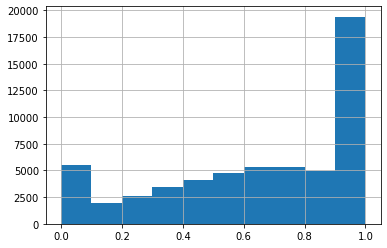

In [76]:
market_states[market_states.market_state == "hot"].liquidity_cost.hist()

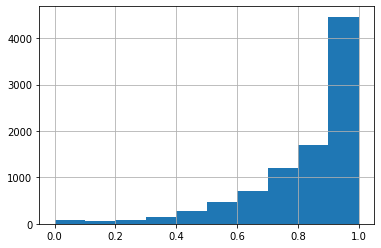

In [77]:
market_states[market_states.market_state == "cold"].liquidity_cost.hist()

In [78]:
(market_states.market_state == "hot").sum()

57401

In [79]:
(market_states.market_state == "cold").sum()

9174

In [81]:
market_states_df = np.concatenate([info_test[["unique_obj_id_clus",
          "address_geocoded_city",
          "address_geocoded_postalcode"]].values, market_states.reset_index(drop=True)],
                          axis=1 )

market_states_df = pd.DataFrame(market_states_df, columns =["unique_obj_id_clus",
          "address_geocoded_city",
          "address_geocoded_postalcode"] + market_states.columns.tolist() )



In [82]:
market_states_df

unique_obj_id_clus address_geocoded_city address_geocoded_postalcode  \
0                 640626    Aschau im Chiemgau                       83229   
1                388clu0                  Dill                       55487   
2                 897309                Werben                       03096   
3             282454clu1                Börßum                       38312   
4                  21219             Karlsruhe                       76137   
...                  ...                   ...                         ...   
66570             463027            Scharbeutz                       23684   
66571             437262             Karlsruhe                       76189   
66572            1257618    Mörfelden-Walldorf                       64546   
66573            1118207     Frankfurt am Main                       60433   
66574             858140             Wuppertal                       42349   

      market_state liquidity_cost week_expected_sale week_highest_opportunity  \
0              hot              1                  2                        7   
1              hot       0.208989                 14                       13   
2              hot       0.042045                 19                        7   
3              hot              0                 10                        5   
4             cold       0.710745                  4                        9   
...            ...            ...                ...                      ...   
66570          hot       0.924088                 18                       71   
66571          hot       0.518373                  4                        5   
66572          hot              1                  7                       18   
66573         cold       0.857638                  4                       15   
66574          hot              0                  4                        1   

      lifetime  
0            9  
1           26  
2           24  
3           43  
4           10  
...        ...  
66570       77  
66571       13  
66572       18  
66573       16  
66574       12  

[66575 rows x 8 columns]

In [83]:
info_test.columns

Index(['unique_obj_id_clus', 'address_geocoded_city',
       'address_geocoded_postalcode', 'offline_corrected', 'online_corrected',
       'season', 'object_type', 'balcony_available_True',
       'investment_rent_active_True', 'parking_available_True',
       'object_type_FARMHOUSE', 'object_type_HOUSE_UNKNOWN',
       'object_type_LOFT', 'object_type_MAISONETTE', 'object_type_MANSION',
       'object_type_MULTI_FAMILY_HOUSE', 'object_type_ONE_TWO_FAMILY_HOUSE',
       'object_type_PENTHOUSE', 'object_type_REGULAR_APARTMENT',
       'object_type_SEMI_DETACHED_HOUSE', 'object_type_SPECIAL_BUILDING',
       'object_type_TERRACED_HOUSE', 'season_Spring', 'season_Summer',
       'season_Winter', 'address_lat', 'address_lng',
       'construction_yearfinished', 'structure_area_living',
       'structure_rooms_living', 'zip_population_density',
       'object_type_ordinal', 'zip_market_size', 'city_distance',
       'time_online', 'expose_price_sqm', 'weeks_on_market', 'status',
       'ex

In [84]:
info_test["address_lat"].values

array([47.76527 , 49.913994, 51.79739 , ..., 50.00479 , 50.16516 ,
       51.20641 ], dtype=float32)

# Apply the Overpricing Heuristic

In [85]:
market_states_df["overprice"] = market_states_df.apply(lambda x: 1 if (x.market_state == "hot") & 
 (x.week_highest_opportunity-x.week_expected_sale <= 0)& 
(x.liquidity_cost <= 0.5) else 0,axis=1 )

In [86]:
market_states_df["latitude"] = info_test["address_lat"].values
market_states_df["longitude"] = info_test["address_lng"].values




In [87]:
market_states_df["overprice"].mean()

0.23779196395043184

In [88]:
market_states_df

unique_obj_id_clus address_geocoded_city address_geocoded_postalcode  \
0                 640626    Aschau im Chiemgau                       83229   
1                388clu0                  Dill                       55487   
2                 897309                Werben                       03096   
3             282454clu1                Börßum                       38312   
4                  21219             Karlsruhe                       76137   
...                  ...                   ...                         ...   
66570             463027            Scharbeutz                       23684   
66571             437262             Karlsruhe                       76189   
66572            1257618    Mörfelden-Walldorf                       64546   
66573            1118207     Frankfurt am Main                       60433   
66574             858140             Wuppertal                       42349   

      market_state liquidity_cost week_expected_sale week_highest_opportunity  \
0              hot              1                  2                        7   
1              hot       0.208989                 14                       13   
2              hot       0.042045                 19                        7   
3              hot              0                 10                        5   
4             cold       0.710745                  4                        9   
...            ...            ...                ...                      ...   
66570          hot       0.924088                 18                       71   
66571          hot       0.518373                  4                        5   
66572          hot              1                  7                       18   
66573         cold       0.857638                  4                       15   
66574          hot              0                  4                        1   

      lifetime  overprice   latitude  longitude  
0            9          0  47.765270  12.323950  
1           26          1  49.913994   7.338289  
2           24          1  51.797390  14.221970  
3           43          1  52.088348  10.595460  
4           10          0  49.003605   8.415483  
...        ...        ...        ...        ...  
66570       77          0  54.011360  10.682050  
66571       13          0  49.000980   8.337610  
66572       18          0  50.004791   8.576640  
66573       16          0  50.165161   8.672800  
66574       12          1  51.206409   7.140060  

[66575 rows x 11 columns]

In [89]:
#market_states_df.to_pickle("market_states_df.pkl")

In [11]:
market_states_df=pd.read_pickle("data/market_states_df.pkl")

# Convert the properties to a geopandas data frame and load SHAP values to merge them

In [12]:
import matplotlib.pyplot as plt
import descartes
import geopandas as gpd
from shapely.geometry import Point,Polygon
%matplotlib inline



ms_geo = gpd.GeoDataFrame(market_states_df,
                         crs= {"init":"epsg:4326"},
                          geometry=gpd.points_from_xy(market_states_df.longitude,
                                                      market_states_df.latitude)
                         )





In [13]:
import shap
import dill
shap.initjs()
with open("data/shap_values_dh_2001.pkl","rb") as handle:
    shap_values_DH=dill.load(handle)

In [14]:
human_readable= [
    'Balcony Available',
    'Actively Rented',
    'Parking Available',
    'SPRING',
    'SUMMER',
    'WINTER',
    'Latitude',
    'Longitude',
    'Construction Year',
    'Living Area',
    'Number of Rooms',
    'Population Density (Zip Code)',
    'Property Type (Ordinal)',
    'Market Size (Zip Code)',
    'Distance to the City Centroid',
    'Date of First Advertisement',
    'Expected Price per Square Meter',
    'DOP'
]


In [15]:
shap_df = np.concatenate([info_test[["unique_obj_id_clus",
                                    "address_geocoded_city",
                                    "address_geocoded_postalcode",
                                    "offline_corrected",
                                    "online_corrected",
                                    "season",
                                    "object_type","address_lng",
                                    "address_lat"]].values,shap_values_DH],axis=1)







In [16]:
shap_df 

array([['640626', 'Aschau im Chiemgau', '83229', ...,
        0.03815736960675503, 0.015255312217468786, 0.0],
       ['388clu0', 'Dill', '55487', ..., -0.023076641607224807,
        -0.01474404015596226, -0.006954848129755976],
       ['897309', 'Werben', '03096', ..., 0.02690812103577395,
        -0.01640404683030691, 0.0],
       ...,
       ['1257618', 'Mörfelden-Walldorf', '64546', ...,
        -0.0217714901867014, 0.00644536181298558, -0.0026889267531987147],
       ['1118207', 'Frankfurt am Main', '60433', ..., 0.0072642504306475,
        0.01691984245561803, -0.004672794993263341],
       ['858140', 'Wuppertal', '42349', ..., -0.005906796971776561,
        0.0017759075298822147, -0.007971105672235586]], dtype=object)

In [17]:
ot_remove=[element for element in df_test.columns.tolist() if element[:11] == 'object_type' and element != "object_type_ordinal"]
cols_leave = ['weeks_on_market','status',"expose_price_sqm"]+ot_remove


In [18]:
col_shap=("shap_"+df_test.drop(cols_leave, axis = 1).columns).tolist()

In [19]:
shap_df=pd.DataFrame(shap_df,
                    columns = ["unique_obj_id_clus",
                                    "address_geocoded_city",
                                    "address_geocoded_postalcode",
                                    "offline_corrected",
                                    "online_corrected",
                                    "season",
                                    "object_type","address_lng",
                                    "address_lat"] + col_shap)







In [20]:
shap_df

unique_obj_id_clus address_geocoded_city address_geocoded_postalcode  \
0                 640626    Aschau im Chiemgau                       83229   
1                388clu0                  Dill                       55487   
2                 897309                Werben                       03096   
3             282454clu1                Börßum                       38312   
4                  21219             Karlsruhe                       76137   
...                  ...                   ...                         ...   
66570             463027            Scharbeutz                       23684   
66571             437262             Karlsruhe                       76189   
66572            1257618    Mörfelden-Walldorf                       64546   
66573            1118207     Frankfurt am Main                       60433   
66574             858140             Wuppertal                       42349   

      offline_corrected online_corrected  season           object_type  \
0            2019-09-09       2019-03-18  Spring     REGULAR_APARTMENT   
1            2018-05-28       2018-01-01  Winter         HOUSE_UNKNOWN   
2            2019-07-01       2019-01-07  Winter              BUNGALOW   
3            2018-05-14       2018-05-14  Spring  ONE_TWO_FAMILY_HOUSE   
4            2018-04-02       2018-03-12  Spring     REGULAR_APARTMENT   
...                 ...              ...     ...                   ...   
66570        2018-10-01       2018-03-12  Spring  ONE_TWO_FAMILY_HOUSE   
66571        2018-11-12       2018-11-05    Fall        TERRACED_HOUSE   
66572        2018-07-16       2018-02-26  Winter    MULTI_FAMILY_HOUSE   
66573        2018-11-05       2018-10-29    Fall        TERRACED_HOUSE   
66574        2018-07-16       2018-07-09  Summer  ONE_TWO_FAMILY_HOUSE   

      address_lng address_lat shap_balcony_available_True  ...  \
0         12.3239     47.7653                 -0.00543517  ...   
1         7.33829      49.914                  0.00524102  ...   
2          14.222     51.7974                 -0.00241894  ...   
3         10.5955     52.0883                 -0.00316355  ...   
4         8.41548     49.0036                 -0.00457816  ...   
...           ...         ...                         ...  ...   
66570      10.682     54.0114                 -0.00589206  ...   
66571     8.33761      49.001                  0.00130156  ...   
66572     8.57664     50.0048                -0.000480586  ...   
66573      8.6728     50.1652                  -0.0045386  ...   
66574     7.14006     51.2064                  0.00143003  ...   

      shap_construction_yearfinished shap_structure_area_living  \
0                        -0.00436078                  0.0289663   
1                         -0.0150532                  0.0055091   
2                         -0.0317919                -0.00336336   
3                         -0.0437111                 -0.0176285   
4                        -0.00438971                  0.0347987   
...                              ...                        ...   
66570                     -0.0660947                 -0.0361271   
66571                     0.00354428                 -0.0158554   
66572                    -0.00140674                -0.00459333   
66573                     0.00707726                  0.0167886   
66574                     0.00273334                 0.00426845   

      shap_structure_rooms_living shap_zip_population_density  \
0                      -0.0117414                 -0.00238067   
1                       0.0027432                 -0.00459867   
2                               0                 -0.00195844   
3                     -0.00151162                 -0.00404583   
4                      -0.0103154                  0.00530357   
...                           ...                         ...   
66570                           0                 -0.00394113   
66571                   0.0113453                  0.00269813 

In [21]:
shap_df["total_shap"] =np.sum(shap_df[col_shap],axis=1)

In [22]:
shap_df["month_year"]=shap_df.online_corrected.dt.year.astype(str) +"_"+ shap_df.online_corrected.dt.month.astype(str)

In [23]:
import datetime as dt
shap_df['month_year'] = shap_df['month_year'].apply(lambda x: 
                                    dt.datetime.strptime(x,'%Y_%m'))



In [24]:
shap_df

unique_obj_id_clus address_geocoded_city address_geocoded_postalcode  \
0                 640626    Aschau im Chiemgau                       83229   
1                388clu0                  Dill                       55487   
2                 897309                Werben                       03096   
3             282454clu1                Börßum                       38312   
4                  21219             Karlsruhe                       76137   
...                  ...                   ...                         ...   
66570             463027            Scharbeutz                       23684   
66571             437262             Karlsruhe                       76189   
66572            1257618    Mörfelden-Walldorf                       64546   
66573            1118207     Frankfurt am Main                       60433   
66574             858140             Wuppertal                       42349   

      offline_corrected online_corrected  season           object_type  \
0            2019-09-09       2019-03-18  Spring     REGULAR_APARTMENT   
1            2018-05-28       2018-01-01  Winter         HOUSE_UNKNOWN   
2            2019-07-01       2019-01-07  Winter              BUNGALOW   
3            2018-05-14       2018-05-14  Spring  ONE_TWO_FAMILY_HOUSE   
4            2018-04-02       2018-03-12  Spring     REGULAR_APARTMENT   
...                 ...              ...     ...                   ...   
66570        2018-10-01       2018-03-12  Spring  ONE_TWO_FAMILY_HOUSE   
66571        2018-11-12       2018-11-05    Fall        TERRACED_HOUSE   
66572        2018-07-16       2018-02-26  Winter    MULTI_FAMILY_HOUSE   
66573        2018-11-05       2018-10-29    Fall        TERRACED_HOUSE   
66574        2018-07-16       2018-07-09  Summer  ONE_TWO_FAMILY_HOUSE   

      address_lng address_lat shap_balcony_available_True  ...  \
0         12.3239     47.7653                 -0.00543517  ...   
1         7.33829      49.914                  0.00524102  ...   
2          14.222     51.7974                 -0.00241894  ...   
3         10.5955     52.0883                 -0.00316355  ...   
4         8.41548     49.0036                 -0.00457816  ...   
...           ...         ...                         ...  ...   
66570      10.682     54.0114                 -0.00589206  ...   
66571     8.33761      49.001                  0.00130156  ...   
66572     8.57664     50.0048                -0.000480586  ...   
66573      8.6728     50.1652                  -0.0045386  ...   
66574     7.14006     51.2064                  0.00143003  ...   

      shap_structure_rooms_living shap_zip_population_density  \
0                      -0.0117414                 -0.00238067   
1                       0.0027432                 -0.00459867   
2                               0                 -0.00195844   
3                     -0.00151162                 -0.00404583   
4                      -0.0103154                  0.00530357   
...                           ...                         ...   
66570                           0                 -0.00394113   
66571                   0.0113453                  0.00269813   
66572                   0.0203669                           0   
66573                 -0.00298487                 0.000814711   
66574                   0.0150963                  0.00080102   

      shap_object_type_ordinal shap_zip_market_size shap_city_distance  \
0                   -0.0106674           0.00654136                  0   
1                    0.0192035           0.00908137        0.000794216   
2                  -0.00707233           0.00610621                  0   
3                    0.0098464           0.00779136                  0   
4                   -0.0110143           0.00716063                  0   
...                        ...                  ...                ...   
66570                 0.013117           0.00471942                  0   
66571         

In [25]:
berlin = shap_df[shap_df.address_geocoded_city =="Berlin"][["shap_DOP",
                                                           "total_shap",
                                                            "address_lng",
                                                            "address_lat"]]








In [26]:


berlin = gpd.GeoDataFrame(berlin,
                         crs= {"init":"epsg:4326"},
                          geometry=gpd.points_from_xy(berlin.address_lng,
                                                      berlin.address_lat)
                         )




# Read Berlin Polygons

In [27]:
bezirke_berlin=gpd.read_file("data/berlin_bezirke/bezirksgrenzen.shp",encoding="utf-8")

In [28]:
bezirke_berlin = bezirke_berlin[["Gemeinde_n","geometry"]]
bezirke_berlin["Gemeinde_n"] = ["Reinickendorf",
                            "Charlottenburg-Wilmersdorf",
                            "Treptow-Koepenick",
                            "Pankow",
                            "Neukoelln",
                            "Lichtenberg",
                            "Marzahn-\nHellersdorf",
                            "Spandau",
                            "Steglitz-Zehlendorf",
                            "Mitte",
                               "Friedrichshain-Kreuzberg",
                               "Tempelhof-\n Schoeneberg"]

In [29]:
berlin_final= gpd.sjoin(berlin,bezirke_berlin,how="right", op = "intersects")

In [30]:
berlin_final.shap_DOP=berlin_final.shap_DOP.astype("float")
berlin_final.total_shap=berlin_final.total_shap.astype("float")



In [31]:
berlin_summary = berlin_final[["shap_DOP","total_shap","Gemeinde_n"]].groupby("Gemeinde_n").mean()

In [32]:
berlin_summary

shap_DOP  total_shap
Gemeinde_n                                      
Charlottenburg-Wilmersdorf -0.000073   -0.051288
Friedrichshain-Kreuzberg    0.000147   -0.067780
Lichtenberg                -0.000190   -0.043768
Marzahn-\nHellersdorf       0.000426   -0.012458
Mitte                      -0.000810   -0.052050
Neukoelln                  -0.000214   -0.017108
Pankow                     -0.000491   -0.063422
Reinickendorf               0.000121   -0.023174
Spandau                    -0.000008   -0.013949
Steglitz-Zehlendorf        -0.000770   -0.033730
Tempelhof-\n Schoeneberg   -0.000766   -0.038911
Treptow-Koepenick          -0.000212   -0.038240

In [33]:
berlin_summary = pd.merge(berlin_summary, bezirke_berlin,
                         on = "Gemeinde_n")



In [34]:


berlin_summary = gpd.GeoDataFrame(berlin_summary,
                         crs= {"init":"epsg:4326"}
                         ) 

(13.05470703821578, 13.794799721550465, 52.32138244451099, 52.69237076520983)

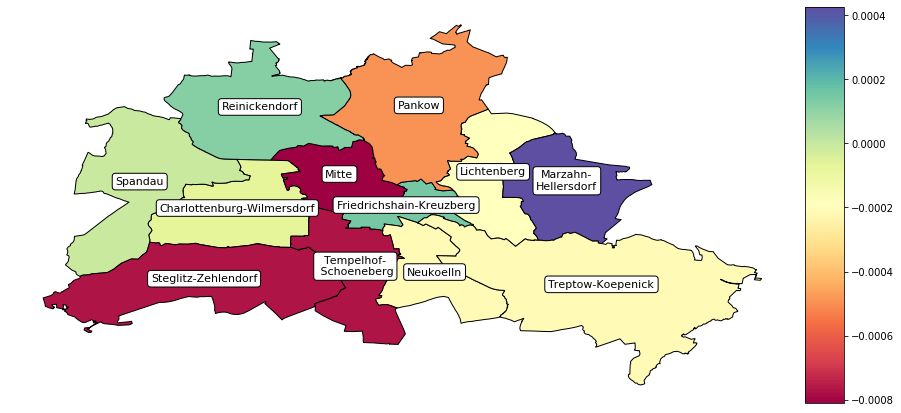

In [35]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mapclassify import Quantiles, UserDefined
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(15,15))
divider = make_axes_locatable(ax)

cax = divider.append_axes("right", size="5%", pad=0.1)



berlin_summary.plot(
            column="shap_DOP", ax=ax,cax=cax,
            legend=True,cmap='Spectral',
            edgecolor='black') 
berlin_summary.apply(lambda x: ax.annotate(s=x.Gemeinde_n, xy=x.geometry.centroid.coords[0], ha='center',
                                   fontsize=11,bbox=dict(boxstyle="round", fc="w")),axis=1);



ax.axis('off')
#plt.savefig("berlin_overprice_without_dots.pdf",bbox_inches = "tight",dpi=20)

(13.05470703821578, 13.794799721550465, 52.32138244451099, 52.69237076520983)

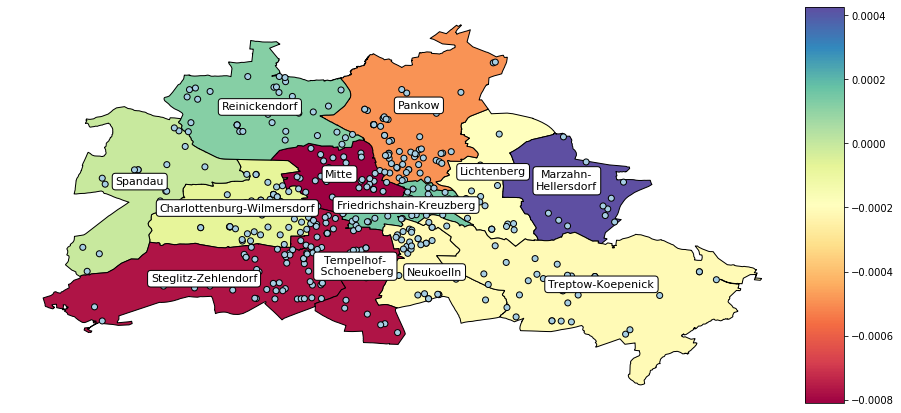

In [36]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mapclassify import Quantiles, UserDefined
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(15,15))
divider = make_axes_locatable(ax)

cax = divider.append_axes("right", size="5%", pad=0.1)



berlin_summary.plot(
            column="shap_DOP", ax=ax,cax=cax,
            legend=True,cmap='Spectral',
            edgecolor='black') 
berlin_summary.apply(lambda x: ax.annotate(s=x.Gemeinde_n, xy=x.geometry.centroid.coords[0], ha='center',
                                   fontsize=11,bbox=dict(boxstyle="round", fc="w")),axis=1);

ms_geo[(ms_geo.address_geocoded_city == "Berlin")
      & (ms_geo.overprice == 1)].plot(column="overprice", cmap = "Paired",edgecolor='black',
                                                      ax=ax)

ax.axis('off')
#plt.savefig("berlin_overprice_dots_blue.pdf",bbox_inches = "tight",dpi=20)

(13.05470703821578, 13.794799721550465, 52.32138244451099, 52.69237076520983)

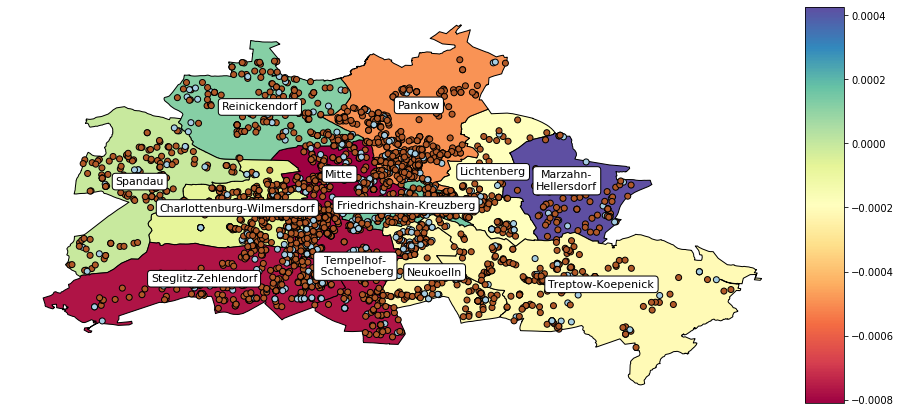

In [37]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mapclassify import Quantiles, UserDefined
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(15,15))
divider = make_axes_locatable(ax)

cax = divider.append_axes("right", size="5%", pad=0.1)



berlin_summary.plot(
            column="shap_DOP", ax=ax,cax=cax,
            legend=True,cmap='Spectral',
            edgecolor='black') 
berlin_summary.apply(lambda x: ax.annotate(s=x.Gemeinde_n, xy=x.geometry.centroid.coords[0], ha='center',
                                   fontsize=11,bbox=dict(boxstyle="round", fc="w")),axis=1);
ms_geo_copy=ms_geo.copy()
ms_geo_copy.overprice =-ms_geo_copy.overprice
ms_geo_copy[(ms_geo_copy.address_geocoded_city == "Berlin")].plot(column="overprice", cmap = "Paired",edgecolor='black',
                                                      ax=ax)

ax.axis('off')
#plt.savefig("berlin_overprice_dots.pdf",bbox_inches = "tight",dpi=20)